In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install pycountry
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 48.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 17.8 MB/s eta 0:00:0000:0100:01


In [3]:
import os
import pandas as pd
import numpy as np
from collections import Counter
import seaborn as sns
import plotly.express as px
from prophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet.plot import add_changepoints_to_plot
from prophet.plot import plot
import matplotlib.pyplot as plt
import pycountry
import random
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [4]:
list(pycountry.countries)[0]
Ecuador=pycountry.countries.get(name='Ecuador')
Ecuador

Country(alpha_2='EC', alpha_3='ECU', flag='🇪🇨', name='Ecuador', numeric='218', official_name='Republic of Ecuador')

In [5]:
# import pycountry
# from googletrans import Translator

# # Initialize the translator
# translator = Translator()

# # Get subdivisions for Ecuador (or any country)
# country_code = "EC"  # ISO code for Ecuador
# subdivisions = pycountry.subdivisions.get(country_code=country_code)

# # Translate names to English
# all_subdivs_english = []
# for subdivision in subdivisions:
#     # print(subdivision.name)
#     # translated_name = translator.translate(subdivision.name, src='auto', dest='en').text
#     all_subdivs_english.append(subdivision.name)
#     # print(f"Original: {subdivision.name}, Translated: {translated_name}")

# # Print the list of translated names
# print(all_subdivs_english)


In [6]:
for dirname, _, filenames in os.walk('data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        print(filename[:-4])
        file_name =filename[:-4]
        file_name=pd.read_csv(os.path.join(dirname, filename))
        print(file_name.head())
        print('*'*100)
        print(file_name.info())
        print('*'*100)
        print(file_name.describe())
        print('++'*100)

In [7]:
data='/kaggle/input/store-sales-time-series-forecasting'

In [8]:
my_test=pd.read_csv(f'{data}/test.csv',parse_dates=['date'])
oil=pd.read_csv(f'{data}/oil.csv',parse_dates=['date'])
train=pd.read_csv(f'{data}/train.csv',parse_dates=['date']) # main df # main df
stores=pd.read_csv(f'{data}/stores.csv') # can be merged with train - on store no
ts=pd.read_csv(f'{data}/transactions.csv',parse_dates=['date']) # can be merged with train - on store no and date
holiday=pd.read_csv(f'{data}/holidays_events.csv',parse_dates=['date'])

In [9]:
stores.rename(columns={'type':'store_type'},inplace=True)

In [10]:
holiday.head()

date     type    locale locale_name                    description  \
0 2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1 2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2 2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3 2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4 2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   

   transferred  
0        False  
1        False  
2        False  
3        False  
4        False

In [11]:
holiday['date']=pd.to_datetime(holiday['date'])

In [12]:
for col in holiday.columns:
    if holiday[col].dtype=='object': 
        print(col)
        print(holiday[col].unique())
        print('*'*10)

type
['Holiday' 'Transfer' 'Additional' 'Bridge' 'Work Day' 'Event']
**********
locale
['Local' 'Regional' 'National']
**********
locale_name
['Manta' 'Cotopaxi' 'Cuenca' 'Libertad' 'Riobamba' 'Puyo' 'Guaranda'
 'Imbabura' 'Latacunga' 'Machala' 'Santo Domingo' 'El Carmen' 'Cayambe'
 'Esmeraldas' 'Ecuador' 'Ambato' 'Ibarra' 'Quevedo'
 'Santo Domingo de los Tsachilas' 'Santa Elena' 'Quito' 'Loja' 'Salinas'
 'Guayaquil']
**********
description
['Fundacion de Manta' 'Provincializacion de Cotopaxi'
 'Fundacion de Cuenca' 'Cantonizacion de Libertad'
 'Cantonizacion de Riobamba' 'Cantonizacion del Puyo'
 'Cantonizacion de Guaranda' 'Provincializacion de Imbabura'
 'Cantonizacion de Latacunga' 'Fundacion de Machala'
 'Fundacion de Santo Domingo' 'Cantonizacion de El Carmen'
 'Cantonizacion de Cayambe' 'Fundacion de Esmeraldas'
 'Primer Grito de Independencia' 'Fundacion de Riobamba'
 'Fundacion de Ambato' 'Fundacion de Ibarra' 'Cantonizacion de Quevedo'
 'Independencia de Guayaquil' 'Traslado 

In [13]:
good_words=['Fundacion','Mundial','Cantonizacion','Independencia','Batalla','Navidad','futbol','Provincializacion','Carnaval','Friday','Dia','Monday','Viernes']
bad_words=['Terremoto']

In [14]:
# Create a regular expression pattern from the list of good words
pattern = '|'.join([f'\\b{word.lower()}\\b' for word in good_words])  # This ensures we match whole words
bad_pattern='|'.join([f'\\b{word.lower()}\\b' for word in bad_words])
# Apply the logic to classify holidays

holiday['category'] = np.where(holiday['description'].str.lower().str.contains(pattern, na=False), 'good', 'bad')


In [15]:
def classify_holiday(description):
    # Check for good words
    for word in good_words:
        if word.lower() in description.lower():
            return word  # Return 'good' if any word in good_words is found
    # Check for bad words
    for word in bad_words:
        if word.lower() in description.lower():
            return word  # Return 'bad' if any word in bad_words is found
    return 'neutral'  # Default to neutral if neither is found

# Apply the function to the DataFrame
holiday['category_reg'] = holiday['description'].apply(classify_holiday)

In [16]:
pattern

'\\bfundacion\\b|\\bmundial\\b|\\bcantonizacion\\b|\\bindependencia\\b|\\bbatalla\\b|\\bnavidad\\b|\\bfutbol\\b|\\bprovincializacion\\b|\\bcarnaval\\b|\\bfriday\\b|\\bdia\\b|\\bmonday\\b|\\bviernes\\b'

In [17]:
holiday[holiday['description'].str.contains('futbol')]

date   type    locale locale_name  \
106 2014-06-12  Event  National     Ecuador   
107 2014-06-15  Event  National     Ecuador   
108 2014-06-20  Event  National     Ecuador   
113 2014-06-25  Event  National     Ecuador   
114 2014-06-28  Event  National     Ecuador   
115 2014-06-29  Event  National     Ecuador   
116 2014-06-30  Event  National     Ecuador   
117 2014-07-01  Event  National     Ecuador   
120 2014-07-04  Event  National     Ecuador   
121 2014-07-05  Event  National     Ecuador   
122 2014-07-08  Event  National     Ecuador   
123 2014-07-09  Event  National     Ecuador   
124 2014-07-12  Event  National     Ecuador   
125 2014-07-13  Event  National     Ecuador   

                                         description  transferred category  \
106            Inauguracion Mundial de futbol Brasil        False     good   
107          Mundial de futbol Brasil: Ecuador-Suiza        False     good   
108       Mundial de futbol Brasil: Ecuador-Honduras        False     good   
113        Mundial de futbol Brasil: Ecuador-Francia        False     good   
114       Mundial de futbol Brasil: Octavos de Final        False     good   
115       Mundial de futbol Brasil: Octavos de Final        False     good   
116       Mundial de futbol Brasil: Octavos de Final        False     good   
117       Mundial de futbol Brasil: Octavos de Final        False     good   
120       Mundial de futbol Brasil: Cuartos de Final        False     good   
121       Mundial de futbol Brasil: Cuartos de Final        False     good   
122            Mundial de futbol Brasil: Semifinales        False     good   
123            Mundial de futbol Brasil: Semifinales        False     good   
124  Mundial de futbol Brasil: Tercer y cuarto lugar        False     good   
125                  Mundial de futbol Brasil: Final        False     good   

    category_reg  
106      Mundial  
107      Mundial  
108      Mundial  
113      Mundial  
114      Mundial  
115      Mundial  
116      Mundial  
117      Mundial  
120      Mundial  
121      Mundial  
122      Mundial  
123      Mundial  
124      Mundial  
125      Mundial

In [18]:
holiday[holiday['category'].str.contains('bad')].head()

date   type    locale locale_name         description  transferred  \
219 2016-04-16  Event  National     Ecuador    Terremoto Manabi        False   
220 2016-04-17  Event  National     Ecuador  Terremoto Manabi+1        False   
221 2016-04-18  Event  National     Ecuador  Terremoto Manabi+2        False   
222 2016-04-19  Event  National     Ecuador  Terremoto Manabi+3        False   
223 2016-04-20  Event  National     Ecuador  Terremoto Manabi+4        False   

    category category_reg  
219      bad    Terremoto  
220      bad    Terremoto  
221      bad    Terremoto  
222      bad    Terremoto  
223      bad    Terremoto

In [19]:
holiday[holiday['type']=='Event'].head()

date   type    locale locale_name  \
55  2013-05-12  Event  National     Ecuador   
103 2014-05-11  Event  National     Ecuador   
106 2014-06-12  Event  National     Ecuador   
107 2014-06-15  Event  National     Ecuador   
108 2014-06-20  Event  National     Ecuador   

                                    description  transferred category  \
55                              Dia de la Madre        False     good   
103                             Dia de la Madre        False     good   
106       Inauguracion Mundial de futbol Brasil        False     good   
107     Mundial de futbol Brasil: Ecuador-Suiza        False     good   
108  Mundial de futbol Brasil: Ecuador-Honduras        False     good   

    category_reg  
55           Dia  
103          Dia  
106      Mundial  
107      Mundial  
108      Mundial

In [20]:
Counter(holiday['description'].to_list())

Counter({'Fundacion de Manta': 6,
         'Provincializacion de Cotopaxi': 6,
         'Fundacion de Cuenca': 7,
         'Cantonizacion de Libertad': 6,
         'Cantonizacion de Riobamba': 6,
         'Cantonizacion del Puyo': 6,
         'Cantonizacion de Guaranda': 6,
         'Provincializacion de Imbabura': 6,
         'Cantonizacion de Latacunga': 6,
         'Fundacion de Machala': 6,
         'Fundacion de Santo Domingo': 6,
         'Cantonizacion de El Carmen': 6,
         'Cantonizacion de Cayambe': 6,
         'Fundacion de Esmeraldas': 6,
         'Primer Grito de Independencia': 6,
         'Fundacion de Riobamba': 6,
         'Fundacion de Ambato': 6,
         'Fundacion de Ibarra': 7,
         'Cantonizacion de Quevedo': 6,
         'Independencia de Guayaquil': 6,
         'Traslado Independencia de Guayaquil': 3,
         'Dia de Difuntos': 6,
         'Independencia de Cuenca': 6,
         'Provincializacion de Santo Domingo': 6,
         'Provincializacion Santa 

In [21]:
holiday['locale'].unique()

array(['Local', 'Regional', 'National'], dtype=object)

In [22]:
holiday[holiday['locale']=='Regional']['locale_name'].unique()

array(['Cotopaxi', 'Imbabura', 'Santo Domingo de los Tsachilas',
       'Santa Elena'], dtype=object)

In [23]:
holiday[holiday['locale']=='Local']['locale_name'].unique()

array(['Manta', 'Cuenca', 'Libertad', 'Riobamba', 'Puyo', 'Guaranda',
       'Latacunga', 'Machala', 'Santo Domingo', 'El Carmen', 'Cayambe',
       'Esmeraldas', 'Ambato', 'Ibarra', 'Quevedo', 'Quito', 'Loja',
       'Salinas', 'Guayaquil'], dtype=object)

In [24]:
train['family'].unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [25]:
holiday[holiday['description'].str.contains("Navidad")]

holiday[holiday['type'].str.contains("Work")]

date      type    locale locale_name  \
42  2013-01-05  Work Day  National     Ecuador   
43  2013-01-12  Work Day  National     Ecuador   
149 2014-12-20  Work Day  National     Ecuador   
161 2015-01-10  Work Day  National     Ecuador   
283 2016-11-12  Work Day  National     Ecuador   

                            description  transferred category category_reg  
42              Recupero puente Navidad        False     good      Navidad  
43   Recupero puente primer dia del ano        False     good          Dia  
149             Recupero Puente Navidad        False     good      Navidad  
161  Recupero Puente Primer dia del ano        False     good          Dia  
283     Recupero Puente Dia de Difuntos        False     good          Dia

In [26]:
holiday_national=holiday[holiday['locale'].str.contains("National")]
holiday_Regional=holiday[holiday['locale'].str.contains("Regional")]
holiday_Local=holiday[holiday['locale'].str.contains("Local")]


In [27]:
df=train.merge(stores,on='store_nbr',how='left')


In [28]:
df['state'].unique()

array(['Pichincha', 'Cotopaxi', 'Chimborazo', 'Imbabura',
       'Santo Domingo de los Tsachilas', 'Bolivar', 'Pastaza',
       'Tungurahua', 'Guayas', 'Santa Elena', 'Los Rios', 'Azuay', 'Loja',
       'El Oro', 'Esmeraldas', 'Manabi'], dtype=object)

In [29]:
df

id       date  store_nbr                      family     sales  \
0              0 2013-01-01          1                  AUTOMOTIVE     0.000   
1              1 2013-01-01          1                   BABY CARE     0.000   
2              2 2013-01-01          1                      BEAUTY     0.000   
3              3 2013-01-01          1                   BEVERAGES     0.000   
4              4 2013-01-01          1                       BOOKS     0.000   
...          ...        ...        ...                         ...       ...   
3000883  3000883 2017-08-15          9                     POULTRY   438.133   
3000884  3000884 2017-08-15          9              PREPARED FOODS   154.553   
3000885  3000885 2017-08-15          9                     PRODUCE  2419.729   
3000886  3000886 2017-08-15          9  SCHOOL AND OFFICE SUPPLIES   121.000   
3000887  3000887 2017-08-15          9                     SEAFOOD    16.000   

         onpromotion   city      state store_type  cluster  
0                  0  Quito  Pichincha          D       13  
1                  0  Quito  Pichincha          D       13  
2                  0  Quito  Pichincha          D       13  
3                  0  Quito  Pichincha          D       13  
4                  0  Quito  Pichincha          D       13  
...              ...    ...        ...        ...      ...  
3000883            0  Quito  Pichincha          B        6  
3000884            1  Quito  Pichincha          B        6  
3000885          148  Quito  Pichincha          B        6  
3000886            8  Quito  Pichincha          B        6  
3000887            0  Quito  Pichincha          B        6  

[3000888 rows x 10 columns]

In [30]:
df['city'].unique()
holiday_Local['locale_name'].unique()

array(['Manta', 'Cuenca', 'Libertad', 'Riobamba', 'Puyo', 'Guaranda',
       'Latacunga', 'Machala', 'Santo Domingo', 'El Carmen', 'Cayambe',
       'Esmeraldas', 'Ambato', 'Ibarra', 'Quevedo', 'Quito', 'Loja',
       'Salinas', 'Guayaquil'], dtype=object)

In [31]:
# all_subdivs_english

In [32]:
# result = pd.Series(df['state'].unique()).isin(all_subdivs_english).all()
# result

In [33]:
# set(df['state'].unique())-set(all_subdivs_english)

In [34]:
df=df.merge(ts,on=['date','store_nbr'],how='left')
# df['date']=pd.to_datetime(df['date'])
# df=df.merge(holiday[holiday['type'].str.contains("Work ")],on='date',how='right')

In [35]:
df['family'].unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [36]:
def plot_graphs(data):
    sns.lineplot(data=data,x='date',y='sales')
    

In [37]:
# df.groupby(by=['store_nbr','family']).apply(plot_graphs)

In [38]:
my_test

id       date  store_nbr                      family  onpromotion
0      3000888 2017-08-16          1                  AUTOMOTIVE            0
1      3000889 2017-08-16          1                   BABY CARE            0
2      3000890 2017-08-16          1                      BEAUTY            2
3      3000891 2017-08-16          1                   BEVERAGES           20
4      3000892 2017-08-16          1                       BOOKS            0
...        ...        ...        ...                         ...          ...
28507  3029395 2017-08-31          9                     POULTRY            1
28508  3029396 2017-08-31          9              PREPARED FOODS            0
28509  3029397 2017-08-31          9                     PRODUCE            1
28510  3029398 2017-08-31          9  SCHOOL AND OFFICE SUPPLIES            9
28511  3029399 2017-08-31          9                     SEAFOOD            0

[28512 rows x 5 columns]

In [39]:
date_data=df.groupby(by=['store_nbr','family'])['date'].agg(['min','max']).reset_index()

In [40]:
date_data['diff']=np.where(date_data['min']!=date_data['max'],1,0)

In [41]:
date_data['min'].unique(),date_data['max'].unique()

(<DatetimeArray>
 ['2013-01-01 00:00:00']
 Length: 1, dtype: datetime64[ns],
 <DatetimeArray>
 ['2017-08-15 00:00:00']
 Length: 1, dtype: datetime64[ns])

In [42]:
date_data

store_nbr                      family        min        max  diff
0             1                  AUTOMOTIVE 2013-01-01 2017-08-15     1
1             1                   BABY CARE 2013-01-01 2017-08-15     1
2             1                      BEAUTY 2013-01-01 2017-08-15     1
3             1                   BEVERAGES 2013-01-01 2017-08-15     1
4             1                       BOOKS 2013-01-01 2017-08-15     1
...         ...                         ...        ...        ...   ...
1777         54                     POULTRY 2013-01-01 2017-08-15     1
1778         54              PREPARED FOODS 2013-01-01 2017-08-15     1
1779         54                     PRODUCE 2013-01-01 2017-08-15     1
1780         54  SCHOOL AND OFFICE SUPPLIES 2013-01-01 2017-08-15     1
1781         54                     SEAFOOD 2013-01-01 2017-08-15     1

[1782 rows x 5 columns]

In [43]:
# df['default_rank'] = df.groupby(['store_nbr', 'family']).cumcount() + 1

In [44]:
df

id       date  store_nbr                      family     sales  \
0              0 2013-01-01          1                  AUTOMOTIVE     0.000   
1              1 2013-01-01          1                   BABY CARE     0.000   
2              2 2013-01-01          1                      BEAUTY     0.000   
3              3 2013-01-01          1                   BEVERAGES     0.000   
4              4 2013-01-01          1                       BOOKS     0.000   
...          ...        ...        ...                         ...       ...   
3000883  3000883 2017-08-15          9                     POULTRY   438.133   
3000884  3000884 2017-08-15          9              PREPARED FOODS   154.553   
3000885  3000885 2017-08-15          9                     PRODUCE  2419.729   
3000886  3000886 2017-08-15          9  SCHOOL AND OFFICE SUPPLIES   121.000   
3000887  3000887 2017-08-15          9                     SEAFOOD    16.000   

         onpromotion   city      state store_type  cluster  transactions  
0                  0  Quito  Pichincha          D       13           NaN  
1                  0  Quito  Pichincha          D       13           NaN  
2                  0  Quito  Pichincha          D       13           NaN  
3                  0  Quito  Pichincha          D       13           NaN  
4                  0  Quito  Pichincha          D       13           NaN  
...              ...    ...        ...        ...      ...           ...  
3000883            0  Quito  Pichincha          B        6        2155.0  
3000884            1  Quito  Pichincha          B        6        2155.0  
3000885          148  Quito  Pichincha          B        6        2155.0  
3000886            8  Quito  Pichincha          B        6        2155.0  
3000887            0  Quito  Pichincha          B        6        2155.0  

[3000888 rows x 11 columns]

In [45]:
unique_data=df.groupby(by=['store_nbr','family'])['date'].agg(['min','max']).reset_index()

In [46]:
unique_data['default_rank'] = unique_data.index+1

In [47]:
unique_data['comb']=unique_data['store_nbr'].astype(str)+str('_')+unique_data['family'].astype(str)

In [48]:
unique_data

store_nbr                      family        min        max  \
0             1                  AUTOMOTIVE 2013-01-01 2017-08-15   
1             1                   BABY CARE 2013-01-01 2017-08-15   
2             1                      BEAUTY 2013-01-01 2017-08-15   
3             1                   BEVERAGES 2013-01-01 2017-08-15   
4             1                       BOOKS 2013-01-01 2017-08-15   
...         ...                         ...        ...        ...   
1777         54                     POULTRY 2013-01-01 2017-08-15   
1778         54              PREPARED FOODS 2013-01-01 2017-08-15   
1779         54                     PRODUCE 2013-01-01 2017-08-15   
1780         54  SCHOOL AND OFFICE SUPPLIES 2013-01-01 2017-08-15   
1781         54                     SEAFOOD 2013-01-01 2017-08-15   

      default_rank                           comb  
0                1                   1_AUTOMOTIVE  
1                2                    1_BABY CARE  
2                3                       1_BEAUTY  
3                4                    1_BEVERAGES  
4                5                        1_BOOKS  
...            ...                            ...  
1777          1778                     54_POULTRY  
1778          1779              54_PREPARED FOODS  
1779          1780                     54_PRODUCE  
1780          1781  54_SCHOOL AND OFFICE SUPPLIES  
1781          1782                     54_SEAFOOD  

[1782 rows x 6 columns]

In [49]:
df['comb']=df['store_nbr'].astype(str)+str('_')+df['family'].astype(str)

In [50]:
df=unique_data.merge(df,on=['comb'],how='right')

In [51]:
df.columns

Index(['store_nbr_x', 'family_x', 'min', 'max', 'default_rank', 'comb', 'id',
       'date', 'store_nbr_y', 'family_y', 'sales', 'onpromotion', 'city',
       'state', 'store_type', 'cluster', 'transactions'],
      dtype='object')

In [52]:
df=df[['store_nbr_x', 'family_x', 'min', 'max', 'default_rank', 'comb', 'id',
       'date', 'sales', 'onpromotion', 'city',
       'state', 'store_type', 'cluster', 'transactions']].rename(columns={'store_nbr_x':'store_nbr', 'family_x':'family'})

In [53]:
len(df['default_rank'].unique())

1782

In [54]:
df

store_nbr                      family        min        max  \
0                1                  AUTOMOTIVE 2013-01-01 2017-08-15   
1                1                   BABY CARE 2013-01-01 2017-08-15   
2                1                      BEAUTY 2013-01-01 2017-08-15   
3                1                   BEVERAGES 2013-01-01 2017-08-15   
4                1                       BOOKS 2013-01-01 2017-08-15   
...            ...                         ...        ...        ...   
3000883          9                     POULTRY 2013-01-01 2017-08-15   
3000884          9              PREPARED FOODS 2013-01-01 2017-08-15   
3000885          9                     PRODUCE 2013-01-01 2017-08-15   
3000886          9  SCHOOL AND OFFICE SUPPLIES 2013-01-01 2017-08-15   
3000887          9                     SEAFOOD 2013-01-01 2017-08-15   

         default_rank                          comb       id       date  \
0                   1                  1_AUTOMOTIVE        0 2013-01-01   
1                   2                   1_BABY CARE        1 2013-01-01   
2                   3                      1_BEAUTY        2 2013-01-01   
3                   4                   1_BEVERAGES        3 2013-01-01   
4                   5                       1_BOOKS        4 2013-01-01   
...               ...                           ...      ...        ...   
3000883           293                     9_POULTRY  3000883 2017-08-15   
3000884           294              9_PREPARED FOODS  3000884 2017-08-15   
3000885           295                     9_PRODUCE  3000885 2017-08-15   
3000886           296  9_SCHOOL AND OFFICE SUPPLIES  3000886 2017-08-15   
3000887           297                     9_SEAFOOD  3000887 2017-08-15   

            sales  onpromotion   city      state store_type  cluster  \
0           0.000            0  Quito  Pichincha          D       13   
1           0.000            0  Quito  Pichincha          D       13   
2           0.000            0  Quito  Pichincha          D       13   
3           0.000            0  Quito  Pichincha          D       13   
4           0.000            0  Quito  Pichincha          D       13   
...           ...          ...    ...        ...        ...      ...   
3000883   438.133            0  Quito  Pichincha          B        6   
3000884   154.553            1  Quito  Pichincha          B        6   
3000885  2419.729          148  Quito  Pichincha          B        6   
3000886   121.000            8  Quito  Pichincha          B        6   
3000887    16.000            0  Quito  Pichincha          B        6   

         transactions  
0                 NaN  
1                 NaN  
2                 NaN  
3                 NaN  
4                 NaN  
...               ...  
3000883        2155.0  
3000884        2155.0  
3000885        2155.0  
3000886        2155.0  
3000887        2155.0  

[3000888 rows x 15 columns]

In [55]:
def filter_data_for_group(df,groupno,group_value=None):
    if groupno:
        new_data=df[df['default_rank']==groupno]
    elif group_value:
        new_data=df[df['comb']==group_value]
    return new_data

In [56]:
filter_data_for_group(df=df,groupno=56)

store_nbr            family        min        max  default_rank  \
385              2  LIQUOR,WINE,BEER 2013-01-01 2017-08-15            56   
2167             2  LIQUOR,WINE,BEER 2013-01-01 2017-08-15            56   
3949             2  LIQUOR,WINE,BEER 2013-01-01 2017-08-15            56   
5731             2  LIQUOR,WINE,BEER 2013-01-01 2017-08-15            56   
7513             2  LIQUOR,WINE,BEER 2013-01-01 2017-08-15            56   
...            ...               ...        ...        ...           ...   
2992363          2  LIQUOR,WINE,BEER 2013-01-01 2017-08-15            56   
2994145          2  LIQUOR,WINE,BEER 2013-01-01 2017-08-15            56   
2995927          2  LIQUOR,WINE,BEER 2013-01-01 2017-08-15            56   
2997709          2  LIQUOR,WINE,BEER 2013-01-01 2017-08-15            56   
2999491          2  LIQUOR,WINE,BEER 2013-01-01 2017-08-15            56   

                       comb       id       date  sales  onpromotion   city  \
385      2_LIQUOR,WINE,BEER      385 2013-01-01    0.0            0  Quito   
2167     2_LIQUOR,WINE,BEER     2167 2013-01-02   29.0            0  Quito   
3949     2_LIQUOR,WINE,BEER     3949 2013-01-03   22.0            0  Quito   
5731     2_LIQUOR,WINE,BEER     5731 2013-01-04   80.0            0  Quito   
7513     2_LIQUOR,WINE,BEER     7513 2013-01-05  105.0            0  Quito   
...                     ...      ...        ...    ...          ...    ...   
2992363  2_LIQUOR,WINE,BEER  2992363 2017-08-11  157.0            8  Quito   
2994145  2_LIQUOR,WINE,BEER  2994145 2017-08-12  159.0            6  Quito   
2995927  2_LIQUOR,WINE,BEER  2995927 2017-08-13  100.0            7  Quito   
2997709  2_LIQUOR,WINE,BEER  2997709 2017-08-14   58.0            5  Quito   
2999491  2_LIQUOR,WINE,BEER  2999491 2017-08-15   65.0            3  Quito   

             state store_type  cluster  transactions  
385      Pichincha          D       13           NaN  
2167     Pichincha          D       13        2358.0  
3949     Pichincha          D       13        2033.0  
5731     Pichincha          D       13        2066.0  
7513     Pichincha          D       13        2062.0  
...            ...        ...      ...           ...  
2992363  Pichincha          D       13        1698.0  
2994145  Pichincha          D       13        1613.0  
2995927  Pichincha          D       13        1658.0  
2997709  Pichincha          D       13        1788.0  
2999491  Pichincha          D       13        1737.0  

[1684 rows x 15 columns]

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Empty DataFrame
Columns: []
Index: []

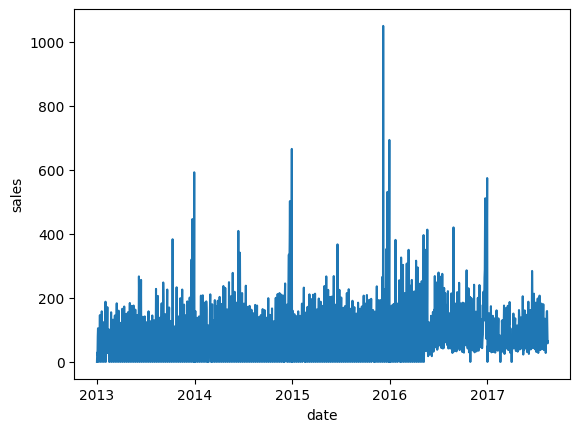

In [57]:
filter_data_for_group(df=df,groupno=56).groupby(by=['store_nbr','family']).apply(plot_graphs)

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 15 columns):
 #   Column        Dtype         
---  ------        -----         
 0   store_nbr     int64         
 1   family        object        
 2   min           datetime64[ns]
 3   max           datetime64[ns]
 4   default_rank  int64         
 5   comb          object        
 6   id            int64         
 7   date          datetime64[ns]
 8   sales         float64       
 9   onpromotion   int64         
 10  city          object        
 11  state         object        
 12  store_type    object        
 13  cluster       int64         
 14  transactions  float64       
dtypes: datetime64[ns](3), float64(2), int64(5), object(5)
memory usage: 343.4+ MB


In [59]:
holiday.info()
holiday.set_index('date',inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          350 non-null    datetime64[ns]
 1   type          350 non-null    object        
 2   locale        350 non-null    object        
 3   locale_name   350 non-null    object        
 4   description   350 non-null    object        
 5   transferred   350 non-null    bool          
 6   category      350 non-null    object        
 7   category_reg  350 non-null    object        
dtypes: bool(1), datetime64[ns](1), object(6)
memory usage: 19.6+ KB


In [60]:
holiday.index

DatetimeIndex(['2012-03-02', '2012-04-01', '2012-04-12', '2012-04-14',
               '2012-04-21', '2012-05-12', '2012-06-23', '2012-06-25',
               '2012-06-25', '2012-06-25',
               ...
               '2017-12-06', '2017-12-08', '2017-12-08', '2017-12-21',
               '2017-12-22', '2017-12-22', '2017-12-23', '2017-12-24',
               '2017-12-25', '2017-12-26'],
              dtype='datetime64[ns]', name='date', length=350, freq=None)

In [61]:
holiday.type.unique()

array(['Holiday', 'Transfer', 'Additional', 'Bridge', 'Work Day', 'Event'],
      dtype=object)

In [62]:
def filter_data_year(data, year):
    # print(type(year))
    
    # Check if the year is a list with two elements
    if isinstance(year, list):  # Use isinstance instead of type() to check list
        data = data[(data.index.year >= year[0]) & (data.index.year <= year[1])]  # Use & instead of and for element-wise comparison
        # print('using list filter')
    else:
        data = data[data.index.year >= year]
    
    return data

def filter_data_month(data, month):
    # print(type(year))
    
    # Check if the year is a list with two elements
    if isinstance(month, list):  # Use isinstance instead of type() to check list
        data = data[(data.index >= month[0]) & (data.index <= month[1])]  # Use & instead of and for element-wise comparison
        # print('using list filter')
    else:
        data = data[data.index >= month]
    
    return data


In [63]:
holiday['category'].unique()

array(['good', 'bad'], dtype=object)

In [64]:
holiday_Local

date        type locale locale_name                  description  \
0   2012-03-02     Holiday  Local       Manta           Fundacion de Manta   
2   2012-04-12     Holiday  Local      Cuenca          Fundacion de Cuenca   
3   2012-04-14     Holiday  Local    Libertad    Cantonizacion de Libertad   
4   2012-04-21     Holiday  Local    Riobamba    Cantonizacion de Riobamba   
5   2012-05-12     Holiday  Local        Puyo       Cantonizacion del Puyo   
..         ...         ...    ...         ...                          ...   
339 2017-12-05  Additional  Local       Quito         Fundacion de Quito-1   
340 2017-12-06     Holiday  Local       Quito           Fundacion de Quito   
341 2017-12-08     Holiday  Local        Loja            Fundacion de Loja   
342 2017-12-08    Transfer  Local       Quito  Traslado Fundacion de Quito   
344 2017-12-22     Holiday  Local     Salinas     Cantonizacion de Salinas   

     transferred category   category_reg  
0          False     good      Fundacion  
2          False     good      Fundacion  
3          False     good  Cantonizacion  
4          False     good  Cantonizacion  
5          False     good  Cantonizacion  
..           ...      ...            ...  
339        False     good      Fundacion  
340         True     good      Fundacion  
341        False     good      Fundacion  
342        False     good      Fundacion  
344        False     good  Cantonizacion  

[152 rows x 8 columns]

In [65]:
df.head()

store_nbr      family        min        max  default_rank          comb  \
0          1  AUTOMOTIVE 2013-01-01 2017-08-15             1  1_AUTOMOTIVE   
1          1   BABY CARE 2013-01-01 2017-08-15             2   1_BABY CARE   
2          1      BEAUTY 2013-01-01 2017-08-15             3      1_BEAUTY   
3          1   BEVERAGES 2013-01-01 2017-08-15             4   1_BEVERAGES   
4          1       BOOKS 2013-01-01 2017-08-15             5       1_BOOKS   

   id       date  sales  onpromotion   city      state store_type  cluster  \
0   0 2013-01-01    0.0            0  Quito  Pichincha          D       13   
1   1 2013-01-01    0.0            0  Quito  Pichincha          D       13   
2   2 2013-01-01    0.0            0  Quito  Pichincha          D       13   
3   3 2013-01-01    0.0            0  Quito  Pichincha          D       13   
4   4 2013-01-01    0.0            0  Quito  Pichincha          D       13   

   transactions  
0           NaN  
1           NaN  
2           NaN  
3           NaN  
4           NaN

In [66]:
df_hol=df.merge(holiday_Local.reset_index(),left_on=['date','city'],right_on=['date','locale_name'],how='left')
df_hol['local_holiday']=np.where(df_hol['locale_name'].isna(),False,True)
df_hol=df_hol[df.columns.to_list()+['local_holiday']]
df_hol=df_hol.merge(holiday_Regional.reset_index(),left_on=['date','state'],right_on=['date','locale_name'],how='left')
df_hol['regional_holiday']=np.where(df_hol['locale_name'].isna(),False,True)
df_hol=df_hol[df.columns.to_list()+['local_holiday','regional_holiday']]
df_hol=df_hol.merge(holiday_national.reset_index(),left_on=['date'],right_on=['date'],how='left')
df_hol['national_holiday']=np.where(df_hol['locale_name'].isna(),False,True)
# df_hol=df_hol[df.columns.to_list()+['local_holiday','regional_holiday','national_holiday']]
df_hol['holiday_true']=df_hol['local_holiday'] | df_hol['regional_holiday'] |df_hol['national_holiday']

In [67]:
# df_hol['_merge'].unique()
df_hol.to_csv('sales_holiday.csv',index=False)
df_hol.set_index('date').index.year.unique().to_list()

[2013, 2014, 2015, 2016, 2017]

In [68]:
df_hol.head()

store_nbr      family        min        max  default_rank          comb  \
0          1  AUTOMOTIVE 2013-01-01 2017-08-15             1  1_AUTOMOTIVE   
1          1   BABY CARE 2013-01-01 2017-08-15             2   1_BABY CARE   
2          1      BEAUTY 2013-01-01 2017-08-15             3      1_BEAUTY   
3          1   BEVERAGES 2013-01-01 2017-08-15             4   1_BEVERAGES   
4          1       BOOKS 2013-01-01 2017-08-15             5       1_BOOKS   

   id       date  sales  onpromotion  ... index     type    locale  \
0   0 2013-01-01    0.0            0  ...  41.0  Holiday  National   
1   1 2013-01-01    0.0            0  ...  41.0  Holiday  National   
2   2 2013-01-01    0.0            0  ...  41.0  Holiday  National   
3   3 2013-01-01    0.0            0  ...  41.0  Holiday  National   
4   4 2013-01-01    0.0            0  ...  41.0  Holiday  National   

   locale_name         description  transferred  category  category_reg  \
0      Ecuador  Primer dia del ano        False      good           Dia   
1      Ecuador  Primer dia del ano        False      good           Dia   
2      Ecuador  Primer dia del ano        False      good           Dia   
3      Ecuador  Primer dia del ano        False      good           Dia   
4      Ecuador  Primer dia del ano        False      good           Dia   

  national_holiday holiday_true  
0             True         True  
1             True         True  
2             True         True  
3             True         True  
4             True         True  

[5 rows x 27 columns]

In [69]:
# pd.notna(df_hol[df_hol['_merge']=='left_only']['store_nbr']).unique()

In [70]:
df_hol.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3008280 entries, 0 to 3008279
Data columns (total 27 columns):
 #   Column            Dtype         
---  ------            -----         
 0   store_nbr         int64         
 1   family            object        
 2   min               datetime64[ns]
 3   max               datetime64[ns]
 4   default_rank      int64         
 5   comb              object        
 6   id                int64         
 7   date              datetime64[ns]
 8   sales             float64       
 9   onpromotion       int64         
 10  city              object        
 11  state             object        
 12  store_type        object        
 13  cluster           int64         
 14  transactions      float64       
 15  local_holiday     bool          
 16  regional_holiday  bool          
 17  index             float64       
 18  type              object        
 19  locale            object        
 20  locale_name       object        
 21  descript

In [71]:
# data=df_hol[df_hol['category_reg']=='Dia'].set_index('date')
data=df_hol.set_index('date')
data=data[data.index.year == 2017]
data=data[data['holiday_true']==True]
data=data[data['default_rank']==55]
data.shape

(12, 26)

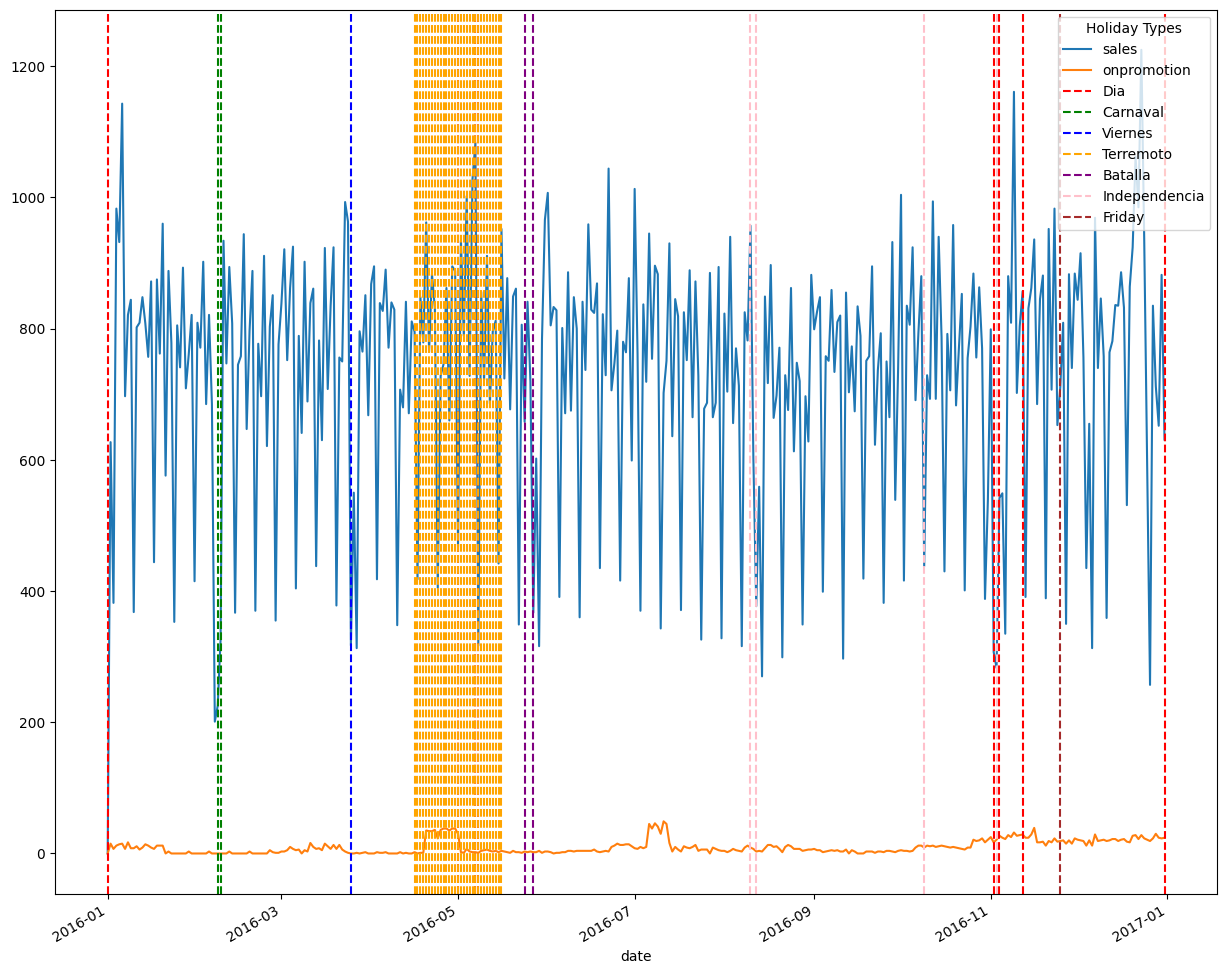

In [72]:
year_range=[2016,2016]

# Filter data to include only rows for years greater than 2015
filtered_data = filter_data_for_group(df=df_hol, groupno=9).set_index('date')

# Resample the data by month (MS - Month Start) and sum the values for 'sales' and 'onpromotion'
filtered_data.resample('MS')['sales', 'onpromotion'].sum()
filtered_data = filter_data_year(filtered_data,year_range)  # Filter by year

filtered_data.plot(y=['sales', 'onpromotion'], figsize=(15, 13))


unique_colors = ['red', 'green', 'blue', 'orange', 'purple', 'pink', 'brown']  # Replace with your actual colors list

# # Create a dictionary for color-to-label mapping
# color_to_label = {color: hol_day for color, hol_day in zip(unique_colors, holiday['category_reg'].unique())}

# for color, hol_day in zip(unique_colors, holiday['category_reg'].unique()):
#     holiday_data = holiday[holiday['category_reg'] == hol_day]
#     holiday_data = filter_data_year(holiday_data,year_range)
#     for date in holiday_data.index:
#         # Plot each vertical line and assign a label to the color
#         plt.axvline(x=date, color=color, linestyle='--', label=color_to_label[color] if date == holiday_data.index[0] else "")

# # Display the legend
# plt.legend(title='Holiday Types', loc='upper right')
filtered_holiday_data=filtered_data[filtered_data['holiday_true']==True]
color_to_label = {color: hol_day for color, hol_day in zip(unique_colors, filtered_holiday_data['category_reg'].unique())}
# print(color_to_label)

for color, hol_day in zip(unique_colors, filtered_holiday_data['category_reg'].unique()):
    filtered_holiday = filtered_holiday_data[filtered_holiday_data['category_reg'] == hol_day]
    # print(filtered_holiday_data)
    # print(filtered_holiday_data.shape)
    for date in filtered_holiday.index:
        # print(date)
        plt.axvline(x=date, color=color, linestyle='--', label=color_to_label[color]  if date == filtered_holiday.index[0] else "")
    
plt.legend(title='Holiday Types', loc='upper right')
plt.show()

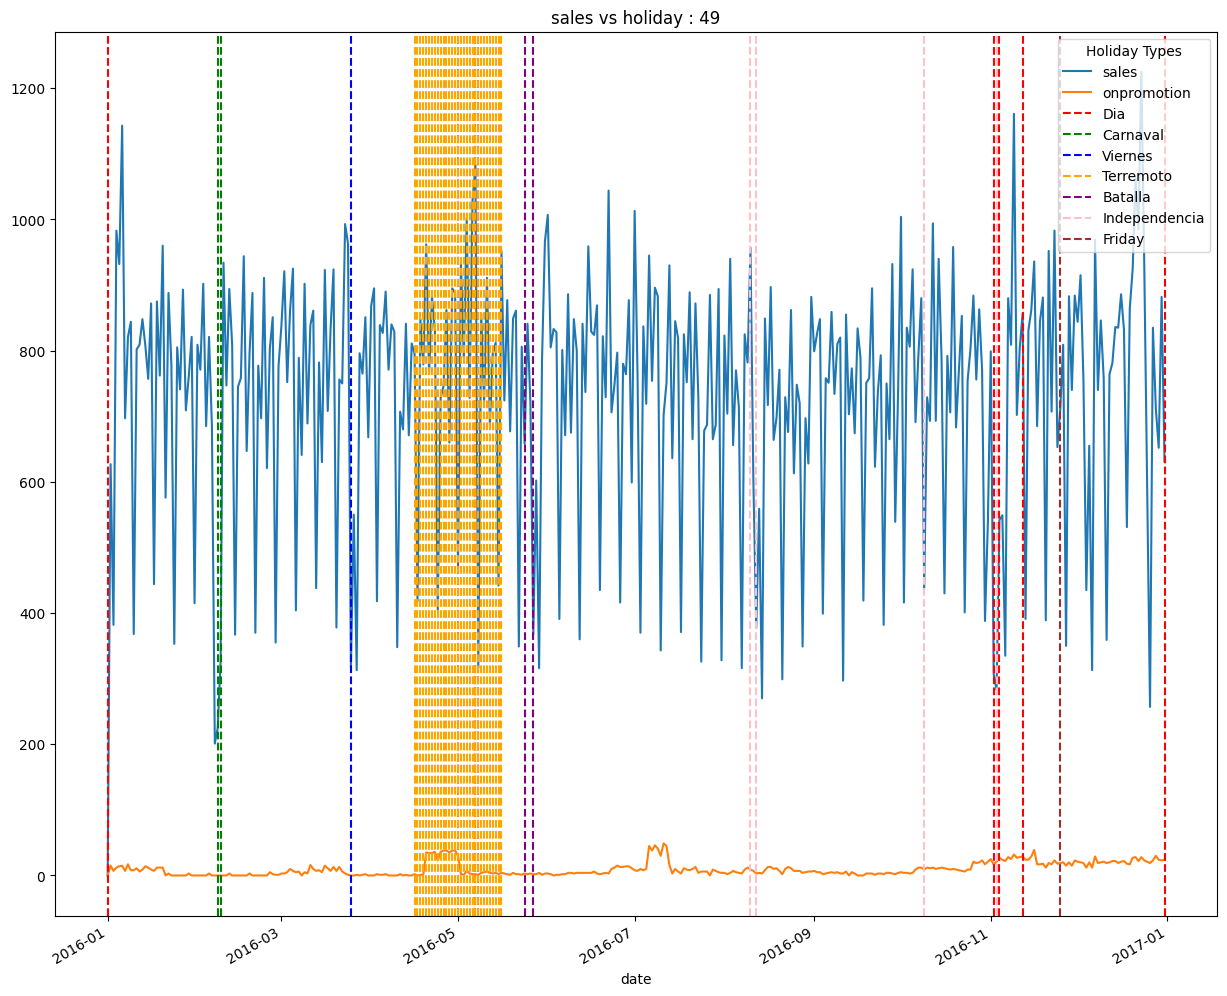

In [73]:
year_range=[2016,2016]
month_range=['2016-01-01','2016-12-31']
filtered_data=filter_data_for_group(df=df_hol,groupno=9).set_index('date')
filtered_data=filter_data_month(filtered_data,month_range)
filtered_data.plot(y=['sales','onpromotion'],figsize=(15,13))


unique_colors = ['red', 'green', 'blue', 'orange', 'purple', 'pink', 'brown']  # Replace with your actual colors list

# # Create a dictionary for color-to-label mapping
# color_to_label = {color: hol_day for color, hol_day in zip(unique_colors, holiday['category_reg'].unique())}

# for color, hol_day in zip(unique_colors, holiday['category_reg'].unique()):
#     holiday_data = holiday[holiday['category_reg'] == hol_day]
#     holiday_data = filter_data_year(holiday_data,year_range)
#     for date in holiday_data.index:
#         # Plot each vertical line and assign a label to the color
#         plt.axvline(x=date, color=color, linestyle='--', label=color_to_label[color] if date == holiday_data.index[0] else "")

# # Display the legend
# plt.legend(title='Holiday Types', loc='upper right')

filtered_holiday_data=filtered_data[filtered_data['holiday_true']==True]
color_to_label = {color: hol_day for color, hol_day in zip(unique_colors, filtered_holiday_data['category_reg'].unique())}
# print(color_to_label)
count=0
for color, hol_day in zip(unique_colors, filtered_holiday_data['category_reg'].unique()):
    filtered_holiday = filtered_holiday_data[filtered_holiday_data['category_reg'] == hol_day]
    # print(filtered_holiday)
    # print(filtered_holiday.shape)
    for date in filtered_holiday.index:
        # print(date)
        
        plt.axvline(x=date, color=color, linestyle='--', label=color_to_label[color]  if date == filtered_holiday.index[0] else "")
        count=count+1
plt.title(f"sales vs holiday : {count}")  
plt.legend(title='Holiday Types', loc='upper right')
plt.show()

In [74]:
for i in range(10):
    groupno=random.randint(1,100)
    

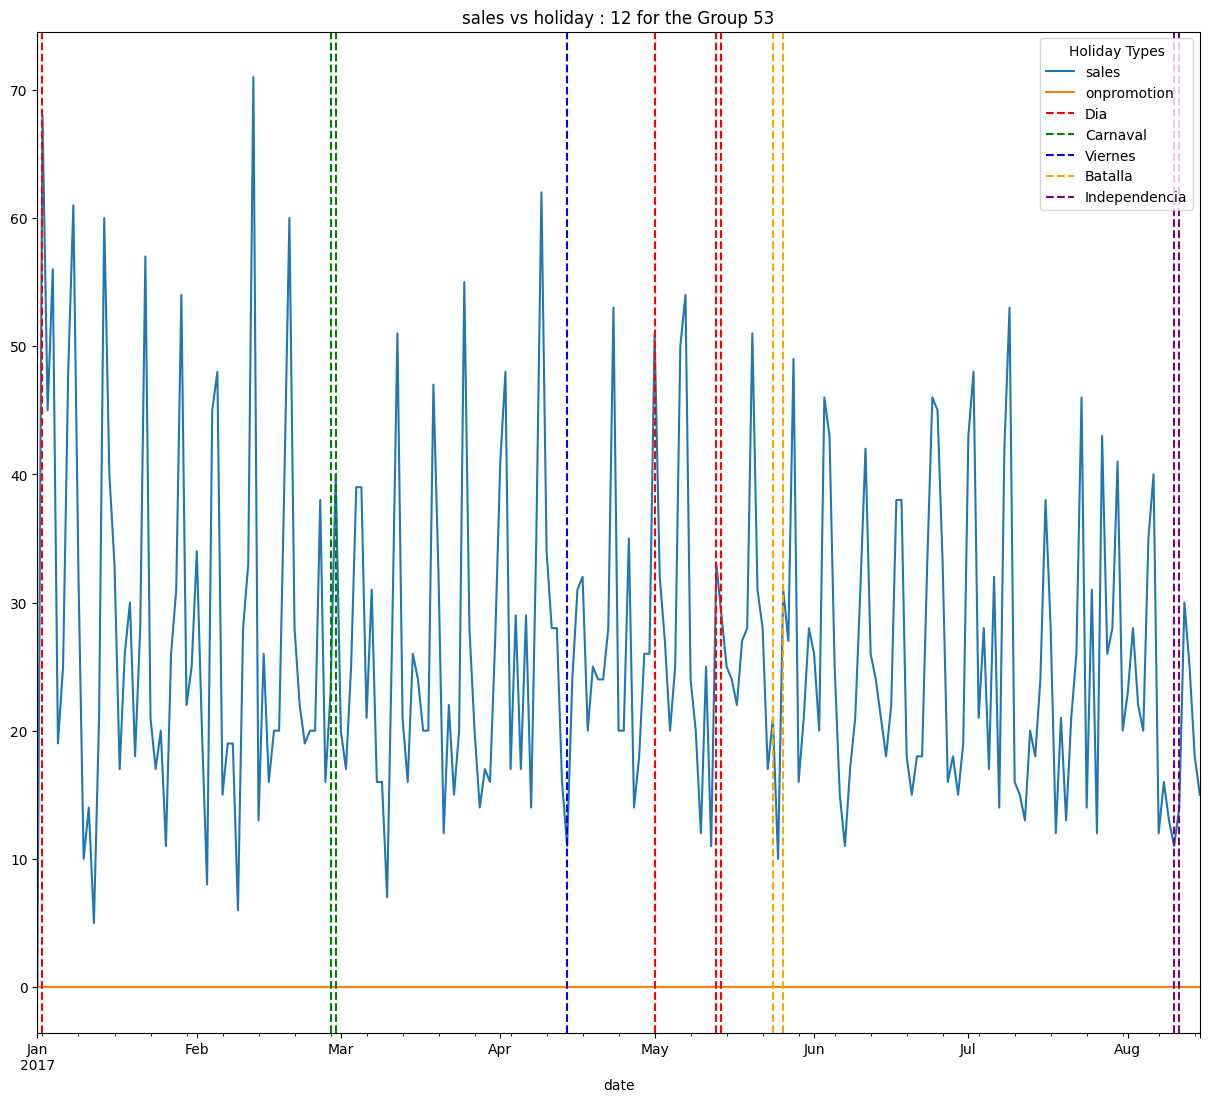

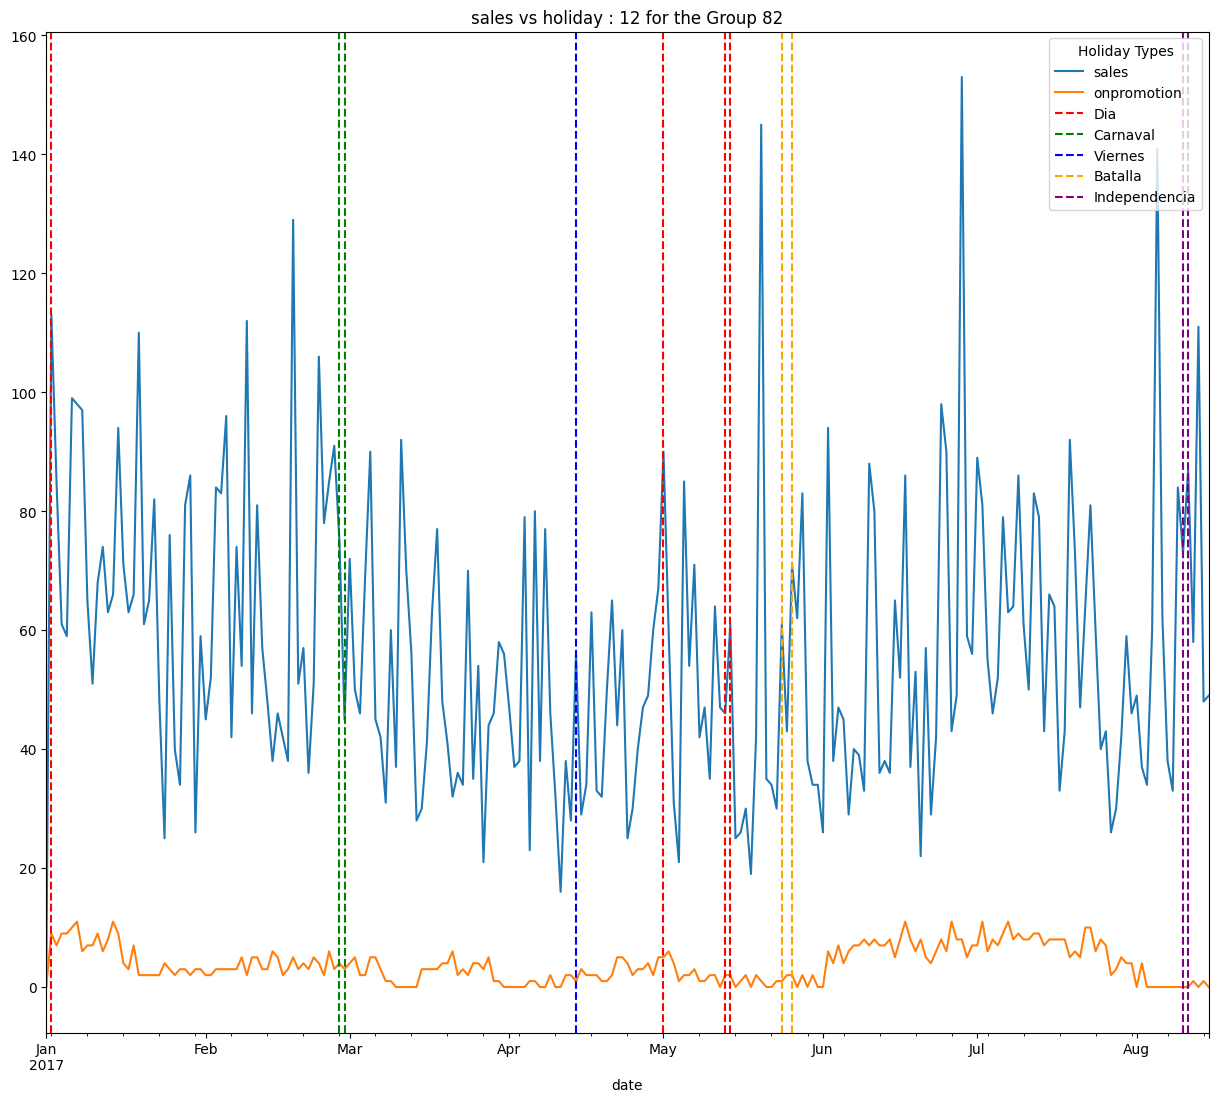

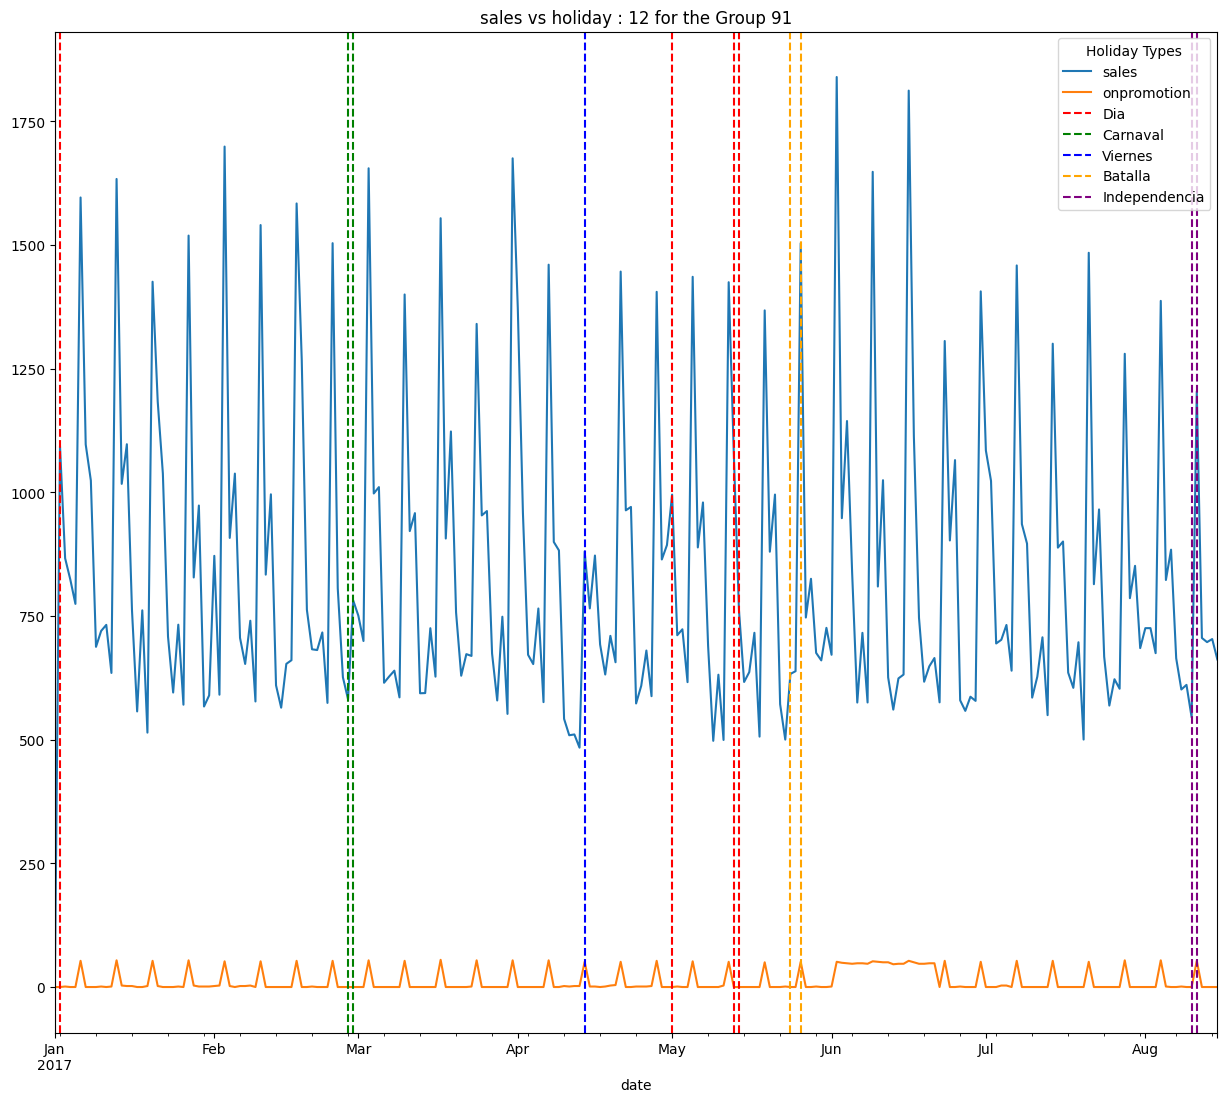

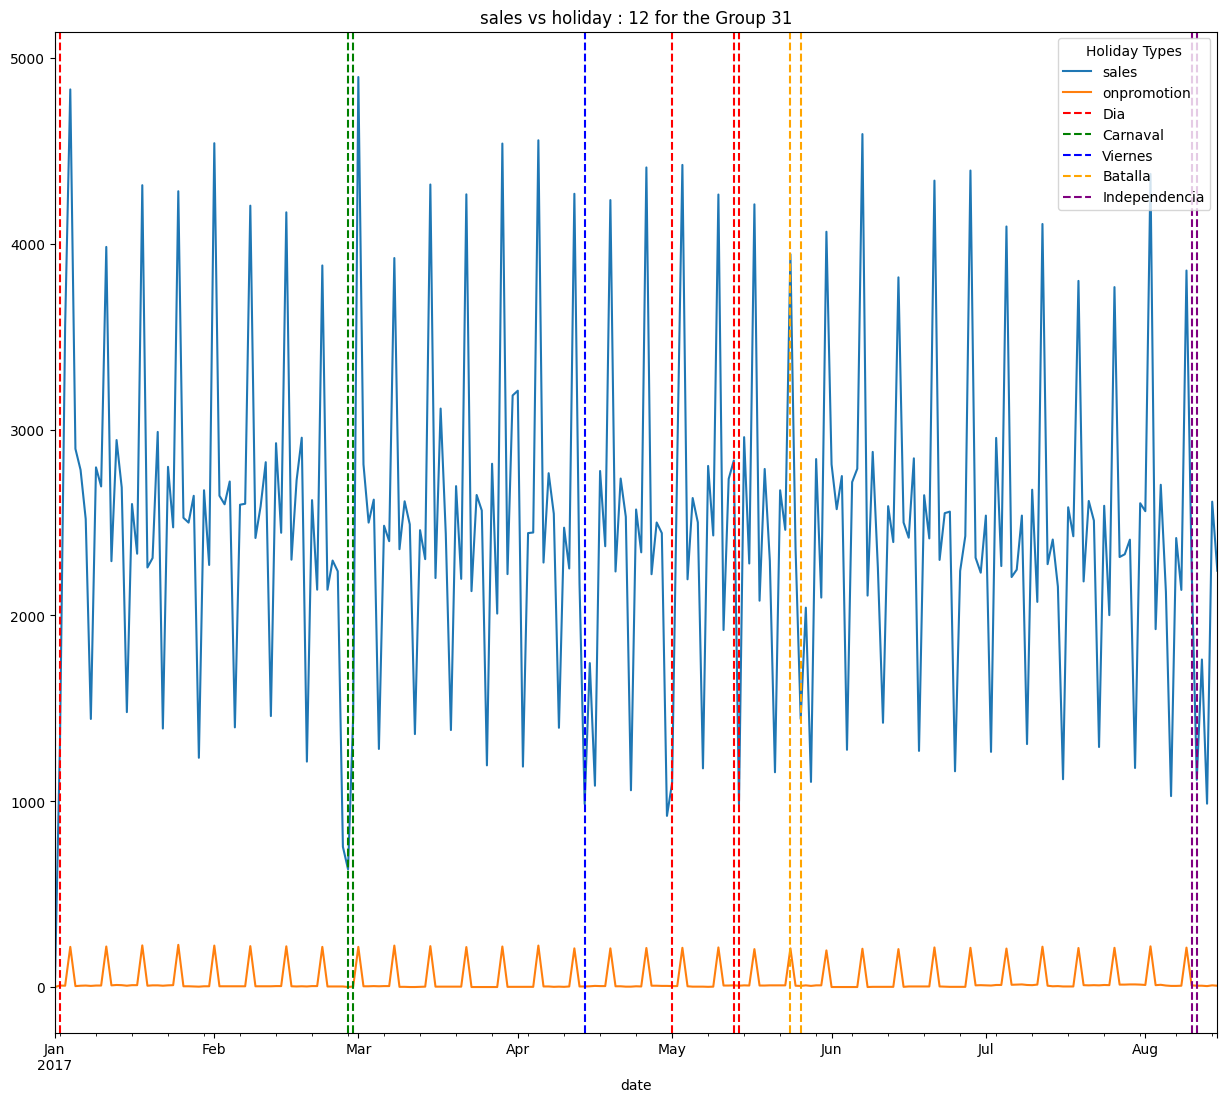

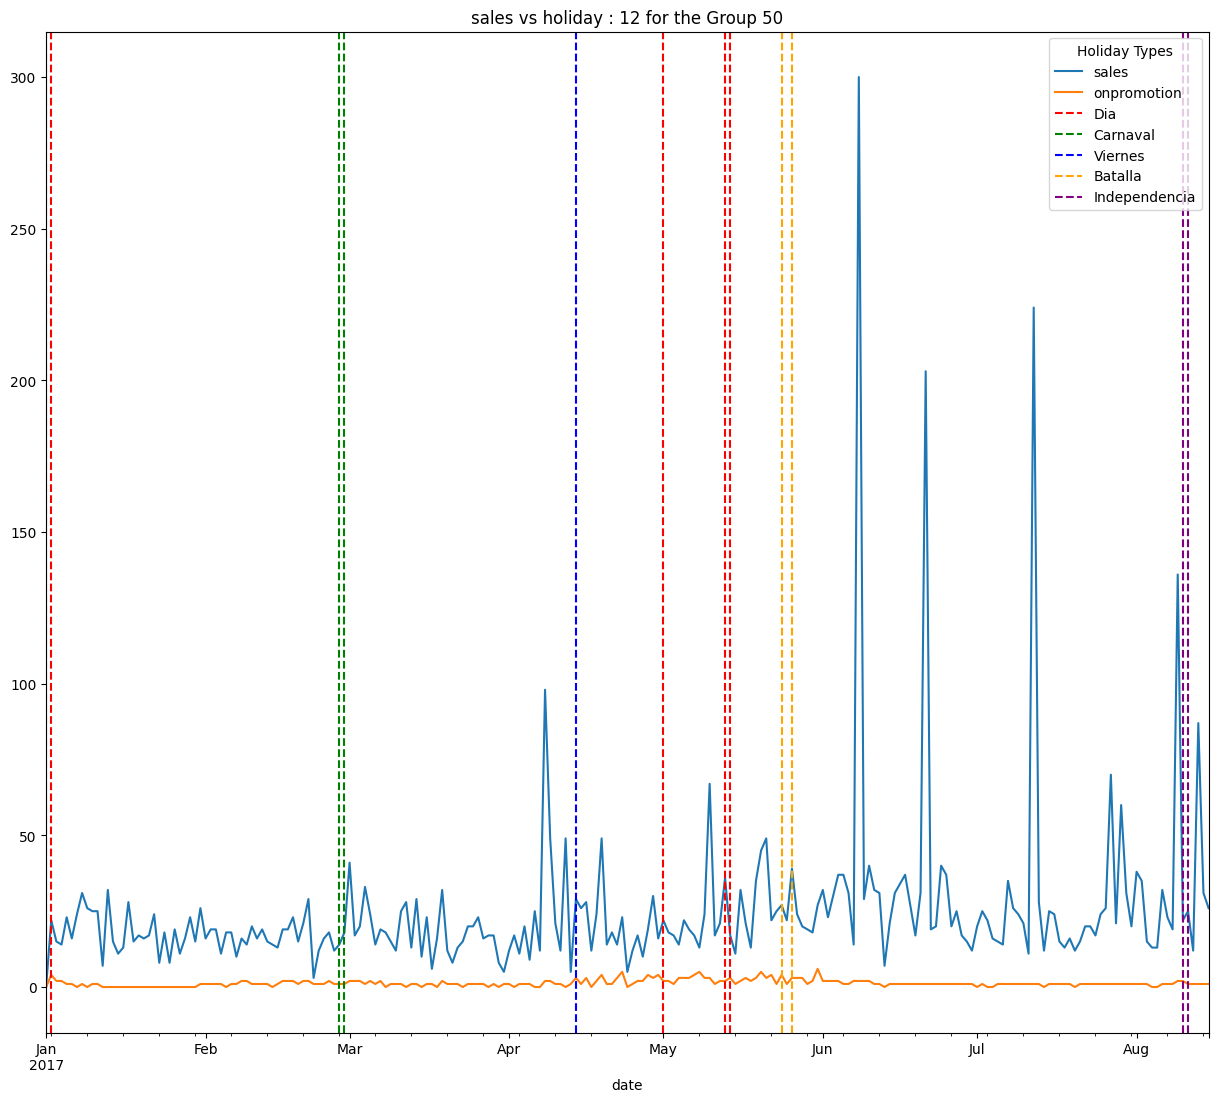

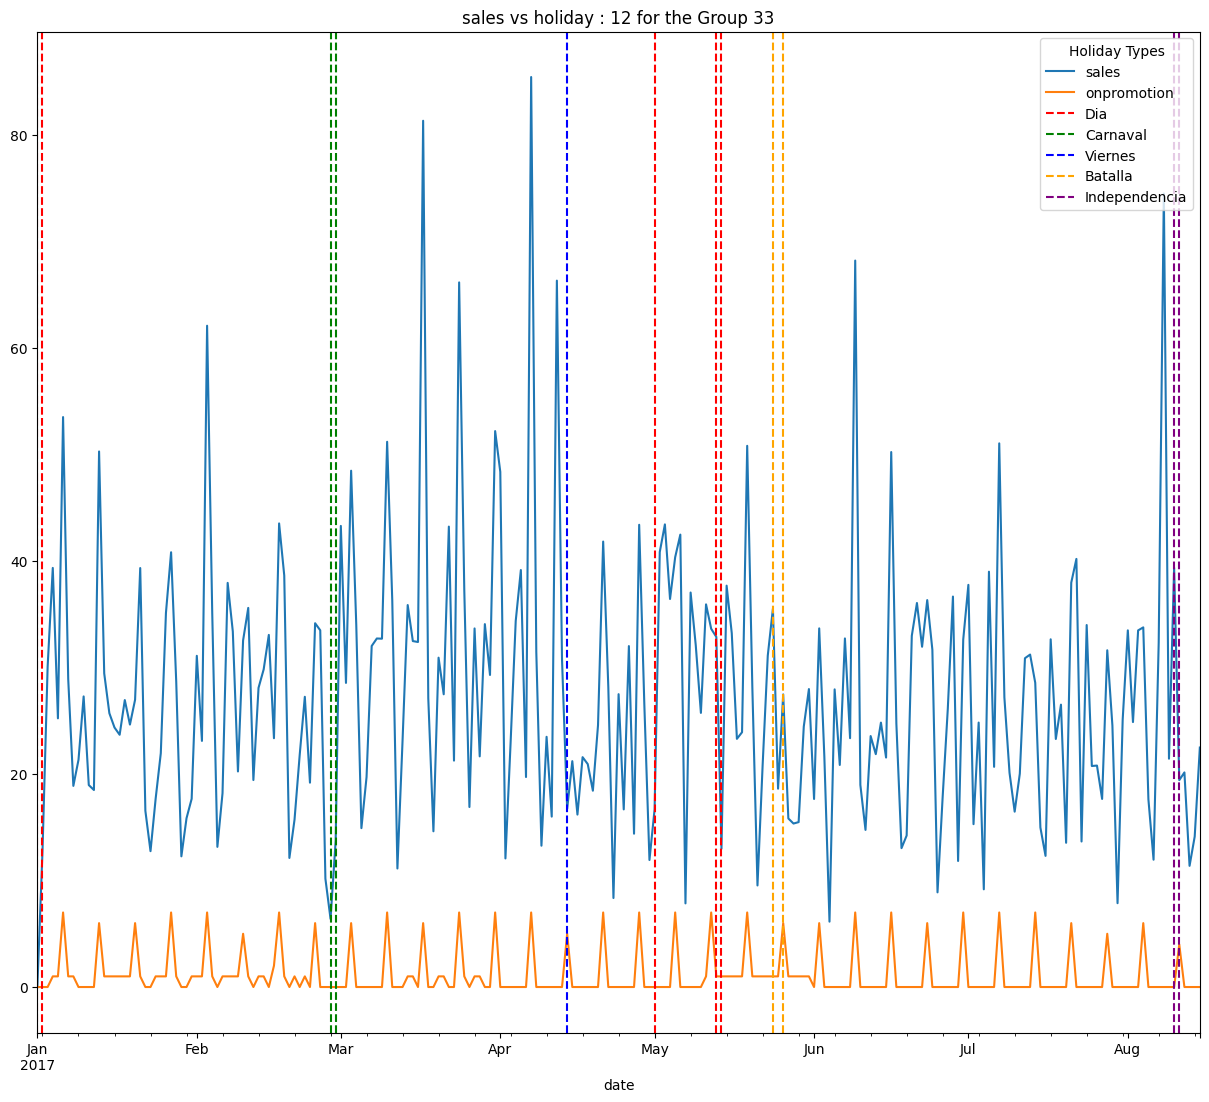

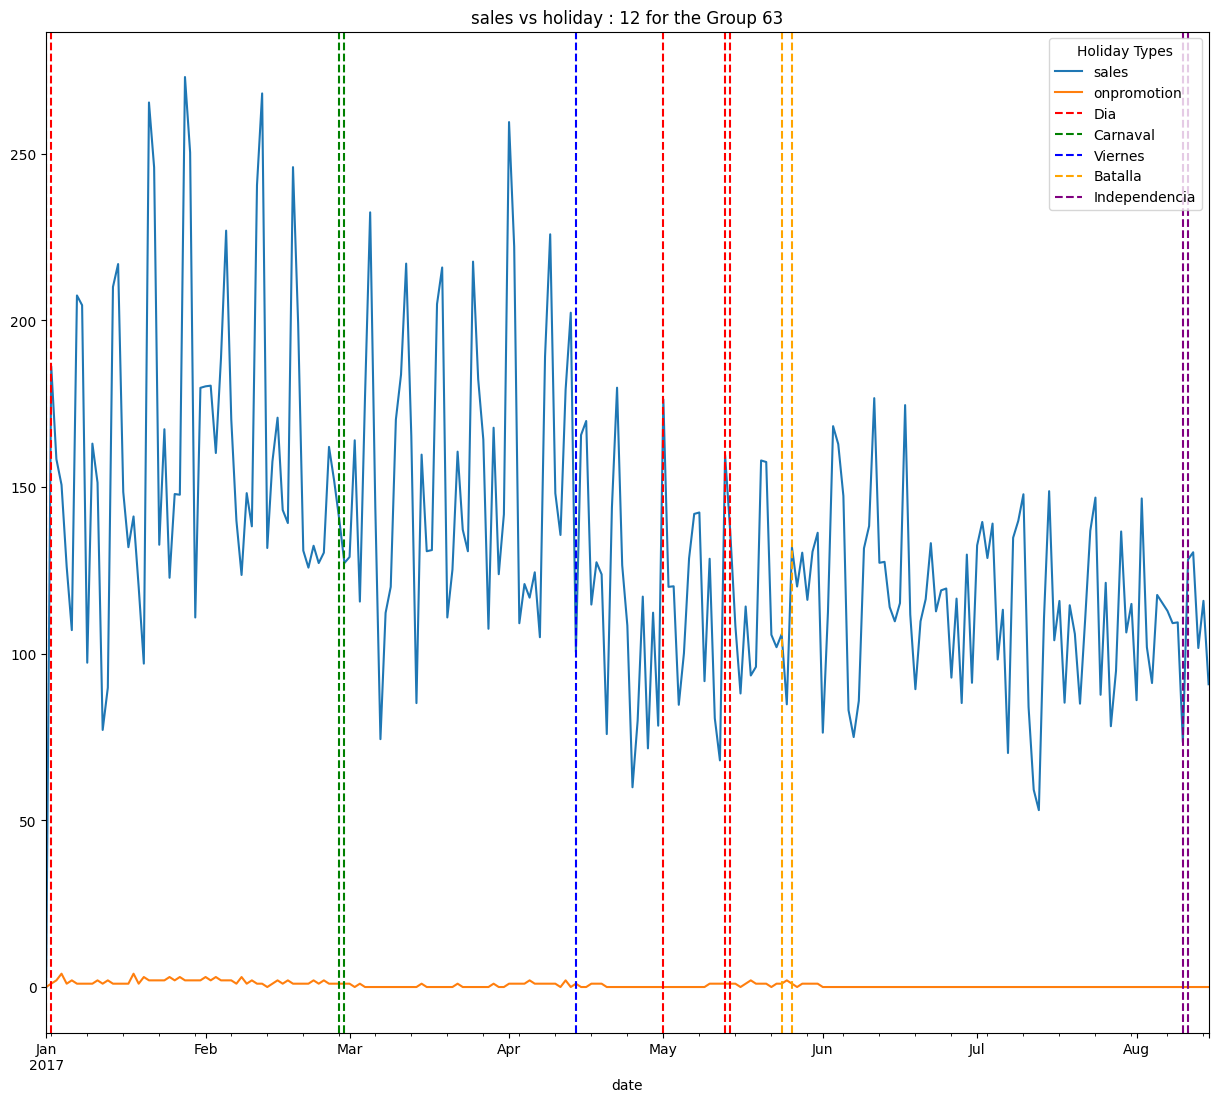

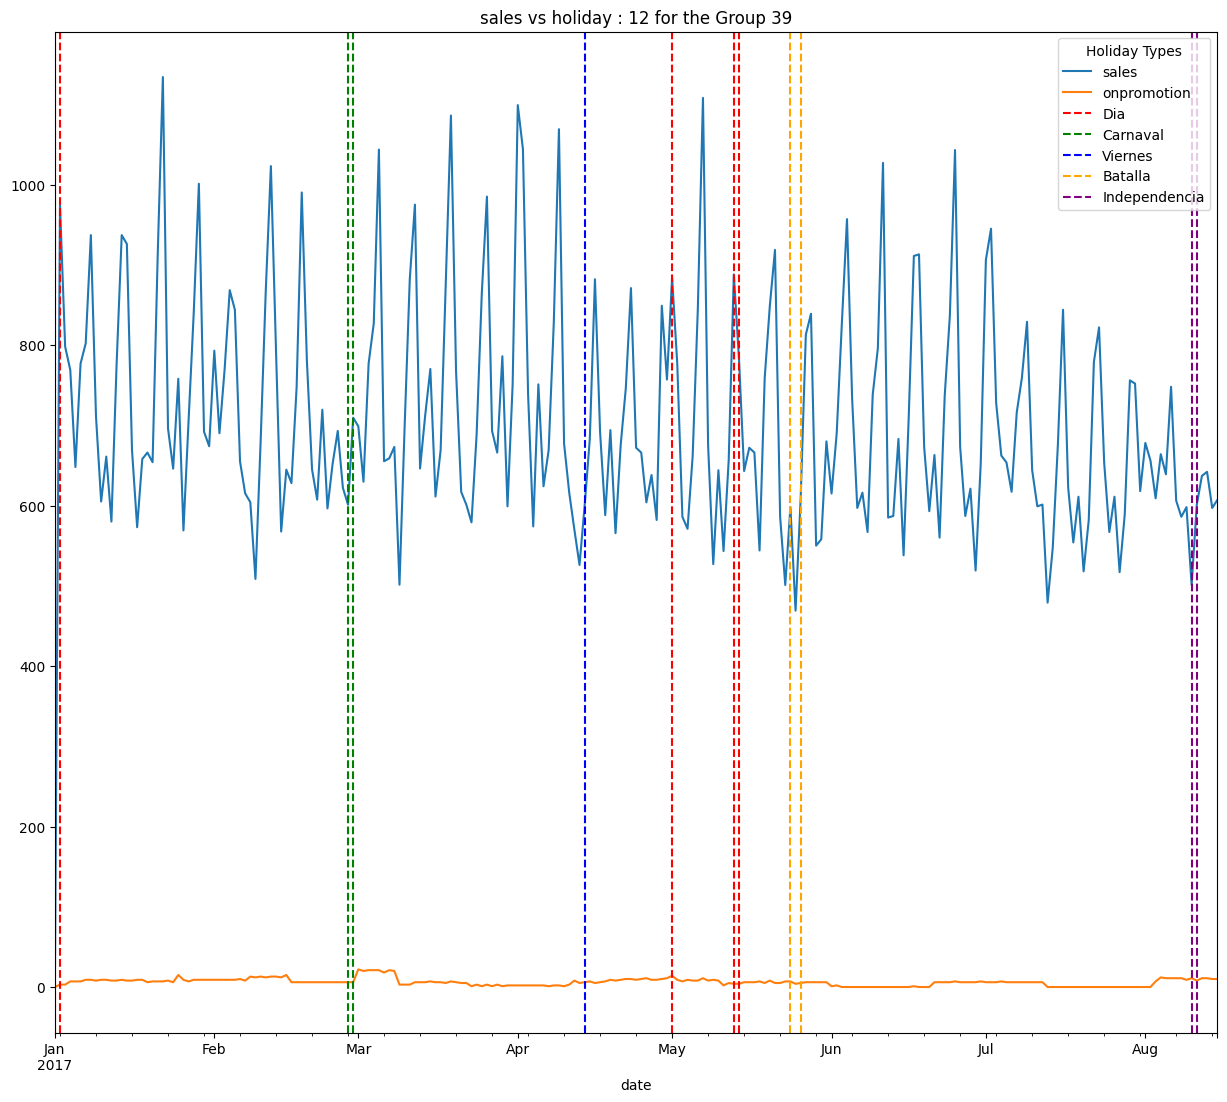

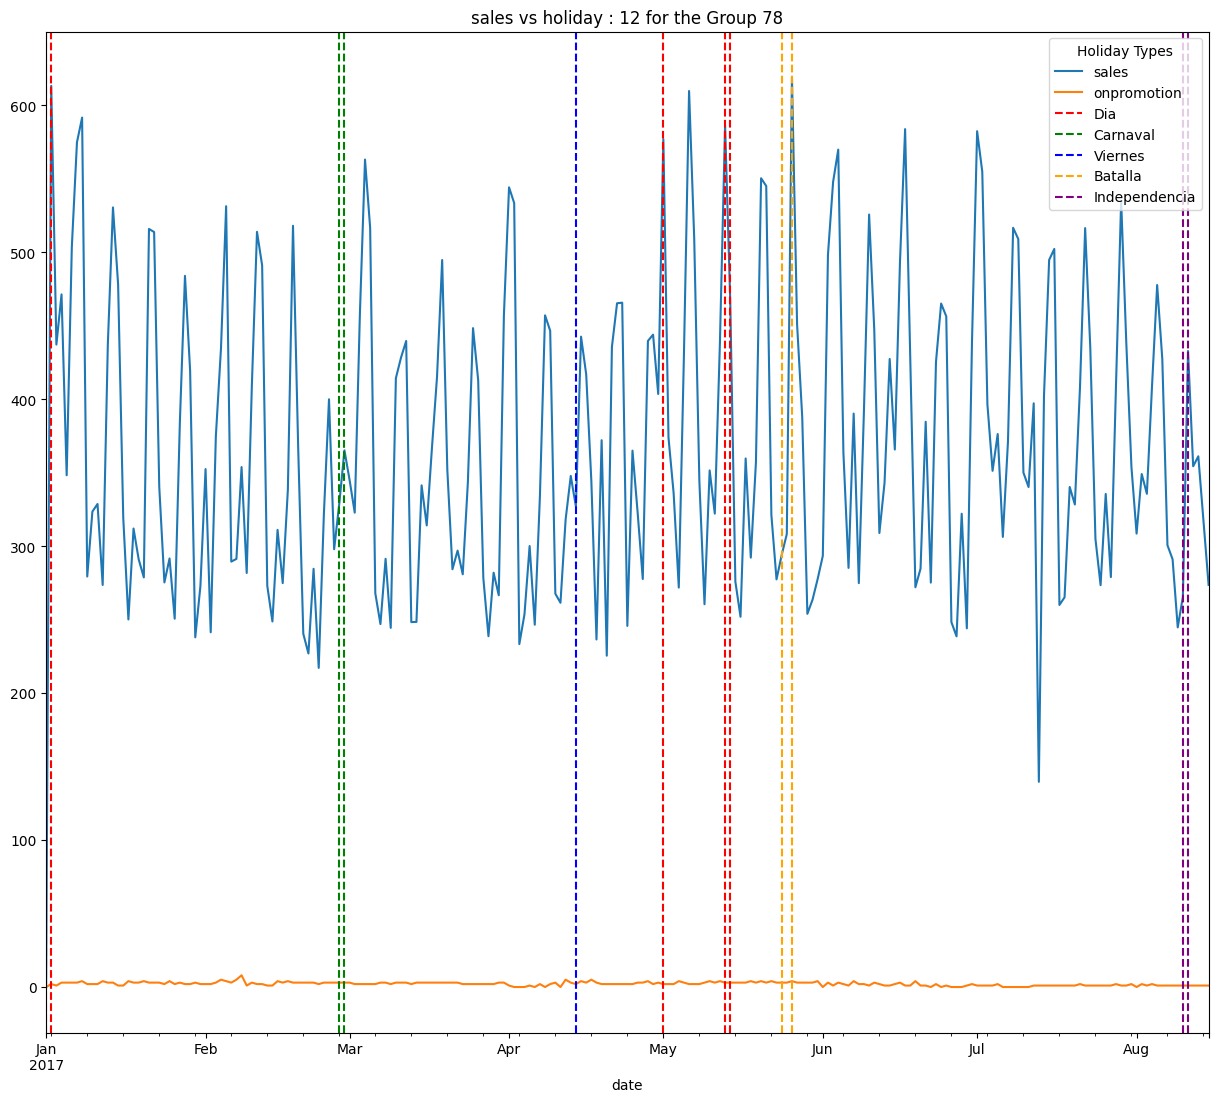

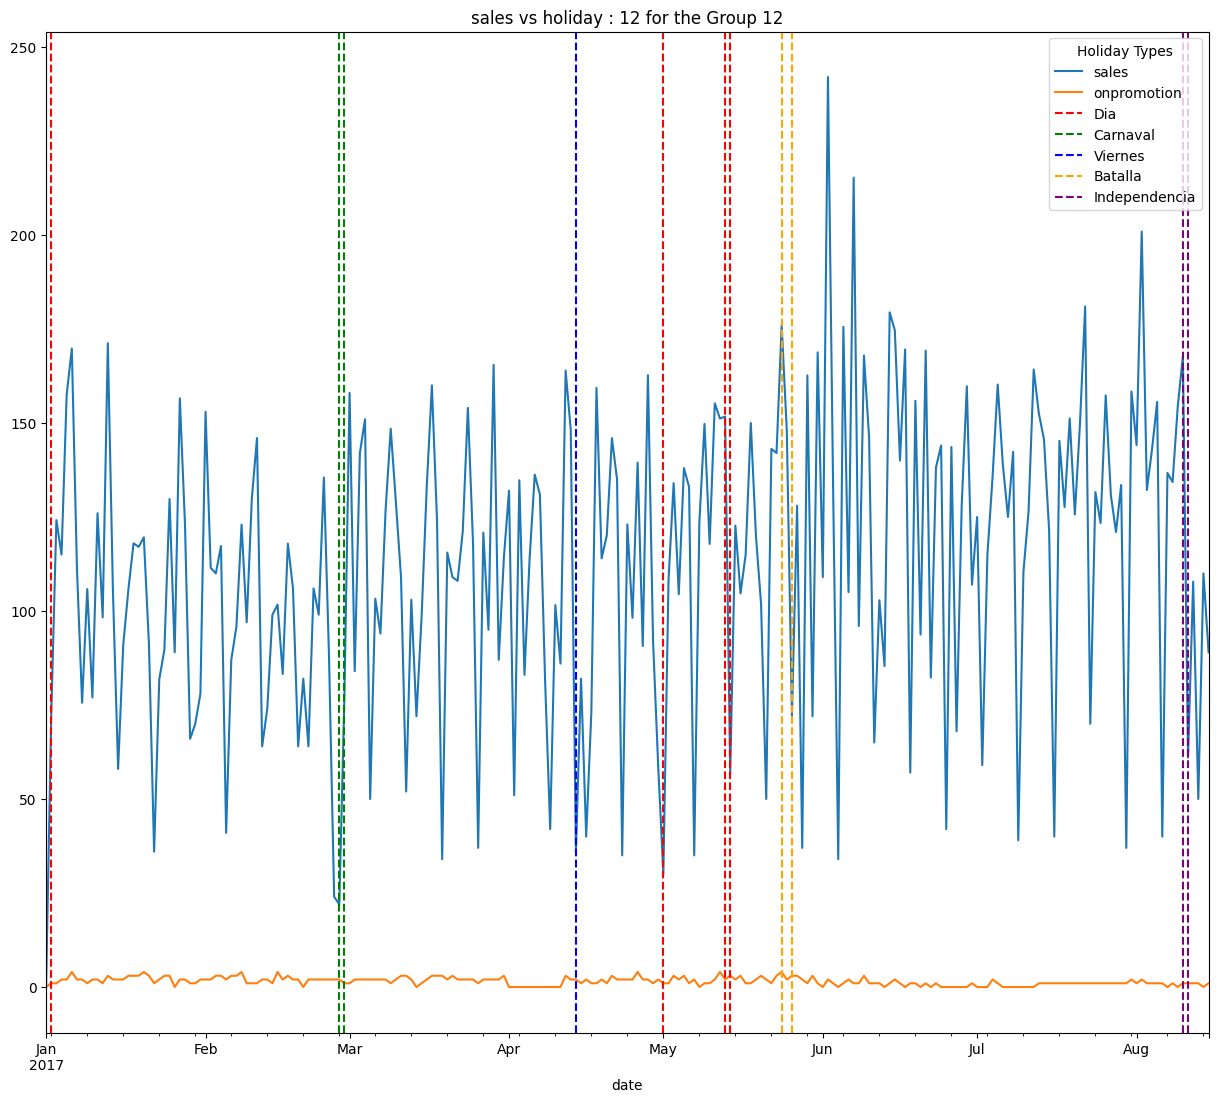

In [75]:
for i in range(10):
    groupno=random.randint(1,100)
    month_range=['2017-01-01','2017-12-31']
    filtered_data=filter_data_for_group(df=df_hol,groupno=groupno).set_index('date')
    filtered_data=filter_data_month(filtered_data,month_range)
    filtered_data.plot(y=['sales','onpromotion'],figsize=(15,13))
    
    
    unique_colors = ['red', 'green', 'blue', 'orange', 'purple', 'pink', 'brown']  # Replace with your actual colors list
    
    # # Create a dictionary for color-to-label mapping
    # color_to_label = {color: hol_day for color, hol_day in zip(unique_colors, holiday['category_reg'].unique())}
    
    # for color, hol_day in zip(unique_colors, holiday['category_reg'].unique()):
    #     holiday_data = holiday[holiday['category_reg'] == hol_day]
    #     holiday_data = filter_data_year(holiday_data,year_range)
    #     for date in holiday_data.index:
    #         # Plot each vertical line and assign a label to the color
    #         plt.axvline(x=date, color=color, linestyle='--', label=color_to_label[color] if date == holiday_data.index[0] else "")
    
    # # Display the legend
    # plt.legend(title='Holiday Types', loc='upper right')
    filtered_holiday_data=filtered_data[filtered_data['holiday_true']==True]
    color_to_label = {color: hol_day for color, hol_day in zip(unique_colors, filtered_holiday_data['category_reg'].unique())}
    # print(color_to_label)
    count=0
    for color, hol_day in zip(unique_colors, filtered_holiday_data['category_reg'].unique()):
        filtered_holiday = filtered_holiday_data[filtered_holiday_data['category_reg'] == hol_day]
        # print(filtered_holiday)
        # print(filtered_holiday.shape)
        for date in filtered_holiday.index:
            # print(date)
            
            plt.axvline(x=date, color=color, linestyle='--', label=color_to_label[color]  if date == filtered_holiday.index[0] else "")
            count=count+1
    plt.title(f"sales vs holiday : {count} for the Group {groupno}" )  
    plt.legend(title='Holiday Types', loc='upper right')
    plt.show()

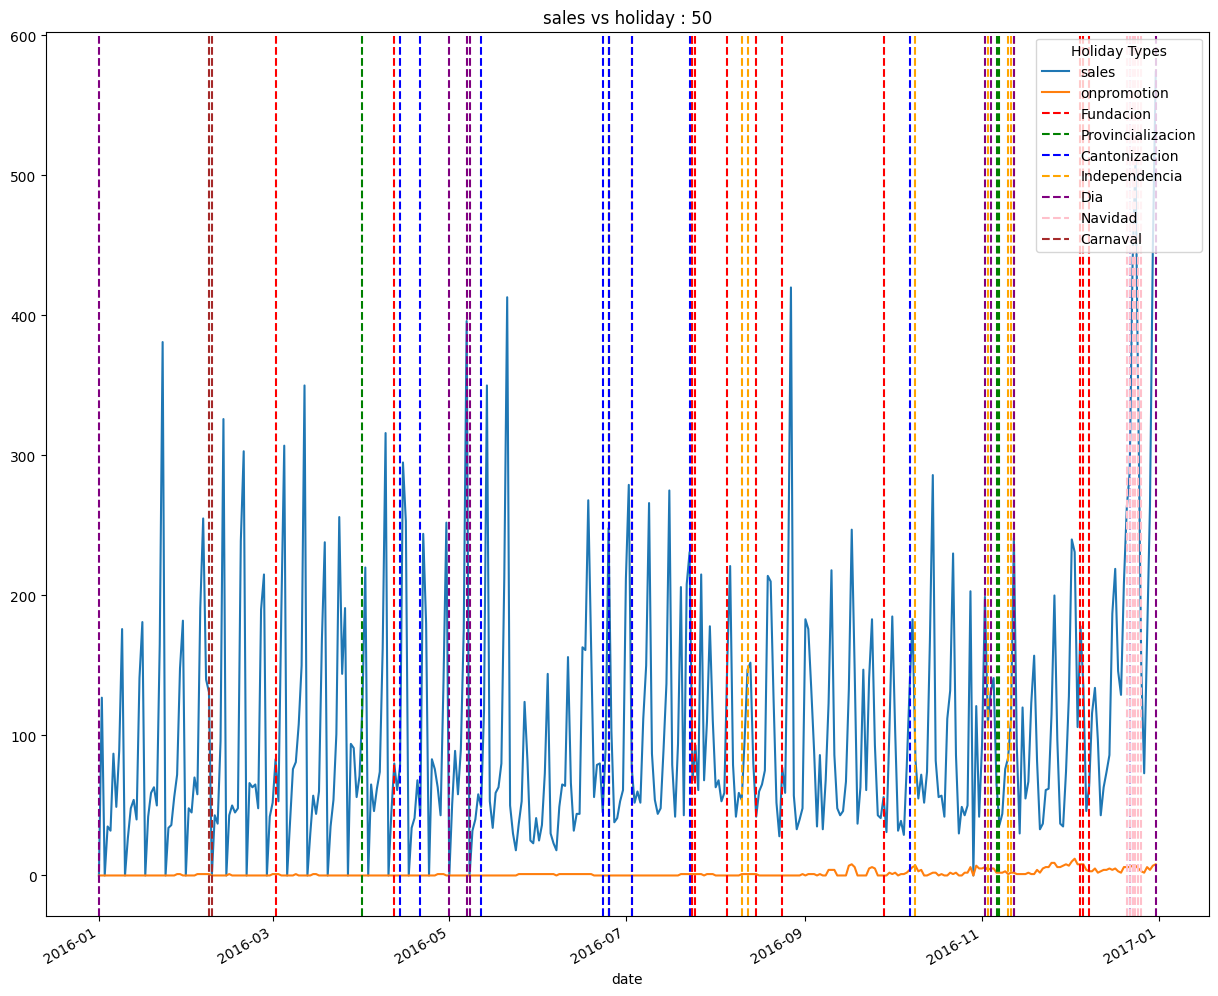

In [76]:
year_range=[2016,2016]

# Filter data to include only rows for years greater than 2015
filtered_data = filter_data_for_group(df=df, groupno=56).set_index('date')

# Resample the data by month (MS - Month Start) and sum the values for 'sales' and 'onpromotion'
filtered_data.resample('MS')['sales', 'onpromotion'].sum()
filtered_data = filter_data_year(filtered_data,year_range)  # Filter by year

filtered_data.plot(y=['sales', 'onpromotion'], figsize=(15, 13))


unique_colors = ['red', 'green', 'blue', 'orange', 'purple', 'pink', 'brown']  # Replace with your actual colors list

# Create a dictionary for color-to-label mapping
color_to_label = {color: hol_day for color, hol_day in zip(unique_colors, holiday['category_reg'].unique())}
count=0
for color, hol_day in zip(unique_colors, holiday['category_reg'].unique()):
    holiday_data = holiday[holiday['category_reg'] == hol_day]
    holiday_data = filter_data_year(holiday_data,year_range)
    for date in holiday_data.index:
        # Plot each vertical line and assign a label to the color
        plt.axvline(x=date, color=color, linestyle='--', label=color_to_label[color] if date == holiday_data.index[0] else "")
        count=count+1

# Display the legend
plt.legend(title='Holiday Types', loc='upper right')
plt.title(f"sales vs holiday : {count}")
plt.show()



In [77]:
# fdata[fdata.index>'2015-01-05']

In [78]:
# month_range=['2015-01-05','2015-03-05']
# filter_data_month(fdata,month_range)

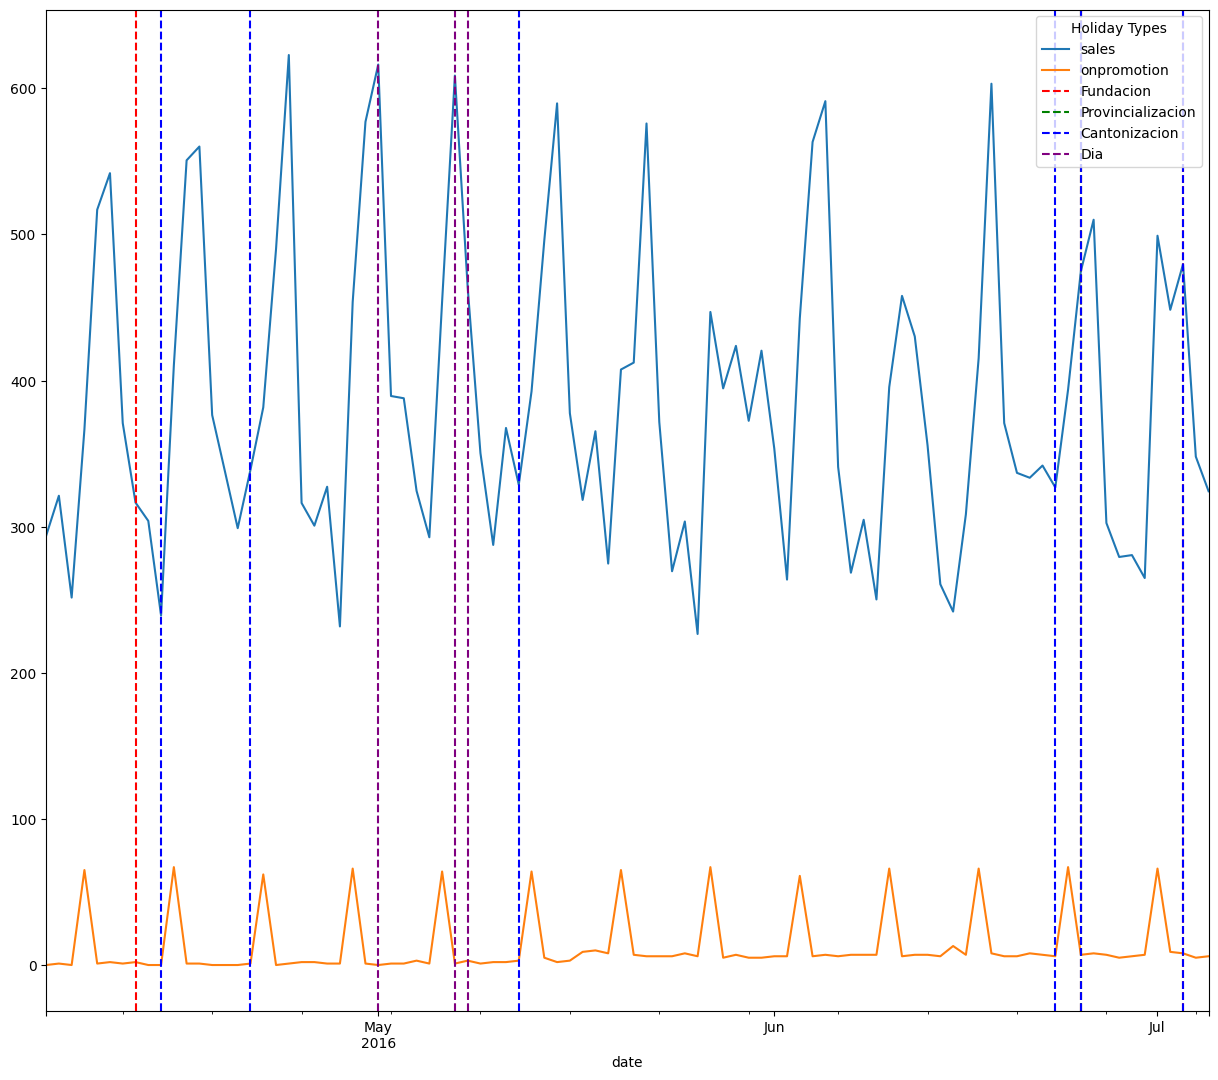

In [79]:
month_range=['2016-04-05','2016-07-05']
fdata=filter_data_for_group(df=df,groupno=76).set_index('date')
fdata=filter_data_month(fdata,month_range)
fdata.plot(y=['sales','onpromotion'],figsize=(15,13))

unique_colors = ['red', 'green', 'blue', 'orange', 'purple', 'pink', 'brown']  # Replace with your actual colors list

# Create a dictionary for color-to-label mapping
color_to_label = {color: hol_day for color, hol_day in zip(unique_colors, holiday['category_reg'].unique())}

for color, hol_day in zip(unique_colors, holiday['category_reg'].unique()):
    holiday_data = holiday[holiday['category_reg'] == hol_day]
    holiday_data=filter_data_month(holiday_data,month_range)
    for date in holiday_data.index:
        # Plot each vertical line and assign a label to the color
        plt.axvline(x=date, color=color, linestyle='--', label=color_to_label[color] if date == holiday_data.index[0] else "")

# Display the legend
plt.legend(title='Holiday Types', loc='upper right')

plt.show()

In [80]:
def Split_data(df,groupno):
    filter_data=filter_data_for_group(df=df,groupno=groupno)
    train_cuttoff=60
    train_data=filter_data[:-train_cuttoff]
    test_data=filter_data[-train_cuttoff:]
    return train_data,test_data,filter_data

In [81]:
def ComplexProphetPlot(model,forecast,train,test,df):
    fig=plot(m=model, fcst=forecast, ax=None, uncertainty=True, plot_cap=True, xlabel='dates', ylabel='y_pred',
    figsize=(10, 6), include_legend=True);
    a=add_changepoints_to_plot(fig.gca(),m=model,fcst=forecast)
    train.set_index('ds').plot(ax=fig.gca(),legend=True,ls='--',c='red')
    test.set_index('ds').rename(columns={'y':'y_true'}).plot(ax=fig.gca(),legend=True,ls='dashdot',c='black')
    #df.set_index('ds').rename(columns={'y':'y_full_data'}).plot(ax=fig.gca(),legend=True,ls='dotted',c='black',marker='*')

In [82]:
def ProphetModel(df,groupno):
    train_data,test_data,all_data=Split_data(df,groupno)
    train_data=train_data[['date','sales','onpromotion','holiday_true']]
    test_data=test_data[['date','sales','onpromotion','holiday_true']]
    train_data.rename(columns={'date':'ds','sales':'y'},inplace=True)
    test_data.rename(columns={'date':'ds','sales':'y'},inplace=True)
    
    scaler_sales = MinMaxScaler()
    scaler_onpromotion = MinMaxScaler()
    
    train_data['y'] = scaler_sales.fit_transform(train_data[['y']])
    test_data['y'] = scaler_sales.transform(test_data[['y']])
    
    train_data['onpromotion'] = scaler_onpromotion.fit_transform(train_data[['onpromotion']])
    test_data['onpromotion'] = scaler_onpromotion.transform(test_data[['onpromotion']])

    
    test_data.to_csv('test_data.csv',index=False)
    model=Prophet(daily_seasonality=True)
    model.add_regressor('holiday_true')
    model.add_regressor('onpromotion')
    model.fit(train_data)
    future_dfs=model.make_future_dataframe(periods=60)
    future_dfs.to_csv('future_data.csv',index=False)
    future_dfs = future_dfs.merge(
    test_data[['ds', 'holiday_true', 'onpromotion']],
    on='ds',
    how='left'
    )
    future_dfs.fillna({'holiday_true': 0, 'onpromotion': 0}, inplace=True)

    future_dfs=future_dfs.tail(60).head(60)
    future_dfs.to_csv('future_dfs.csv',index=False)
    preds=model.predict(future_dfs)
    # preds.merge(train_data,on='ds',how='left').set_index('ds')[['y','yhat']].plot(figsize=(15,13))
    #ComplexProphetPlot(model,preds,train_data,test_data,df)
    preds['yhat'] = scaler_sales.inverse_transform(preds[['yhat']])
    preds['yhat_lower'] = scaler_sales.inverse_transform(preds[['yhat_lower']])
    preds['yhat_upper'] = scaler_sales.inverse_transform(preds[['yhat_upper']])
    
    # Inverse transform test data to original scale for evaluation
    test_data['y'] = scaler_sales.inverse_transform(test_data[['y']])
    
    return preds,train_data,test_data

In [83]:
# ProphetModel(df_hol,groupno=88)

In [84]:
req_columns=['default_rank','comb','date','sales','onpromotion','holiday_true']
df_Prophet=df_hol[req_columns]
# df_Prophet=df_Prophet.set_index('date')
df_Prophet.loc[:,'holiday_true']=df_Prophet['holiday_true'].astype('int64')
df_Prophet

default_rank                          comb       date     sales  \
0                   1                  1_AUTOMOTIVE 2013-01-01     0.000   
1                   2                   1_BABY CARE 2013-01-01     0.000   
2                   3                      1_BEAUTY 2013-01-01     0.000   
3                   4                   1_BEVERAGES 2013-01-01     0.000   
4                   5                       1_BOOKS 2013-01-01     0.000   
...               ...                           ...        ...       ...   
3008275           293                     9_POULTRY 2017-08-15   438.133   
3008276           294              9_PREPARED FOODS 2017-08-15   154.553   
3008277           295                     9_PRODUCE 2017-08-15  2419.729   
3008278           296  9_SCHOOL AND OFFICE SUPPLIES 2017-08-15   121.000   
3008279           297                     9_SEAFOOD 2017-08-15    16.000   

         onpromotion  holiday_true  
0                  0             1  
1                  0             1  
2                  0             1  
3                  0             1  
4                  0             1  
...              ...           ...  
3008275            0             0  
3008276            1             0  
3008277          148             0  
3008278            8             0  
3008279            0             0  

[3008280 rows x 6 columns]

In [85]:
def fillMissingDates(df_df,unique_cols,frequency,freq,grain_with_time,sales_column,date_index=False):
    date_ranges = df_df.groupby(unique_cols).apply(
            lambda group: pd.date_range(group[frequency].min(), group[frequency].max(), freq=freq)
        ).reset_index(name=frequency)


    # Step 4: Create a new DataFrame that combines item-location combinations with the generated date ranges
    date_ranges = date_ranges.explode(frequency).reset_index(drop=True)


    # Step 5: Merge the generated date ranges with the original data to get sales_quantity for each date
    df_filled = pd.merge(date_ranges, df_df[grain_with_time+sales_column],
                         on=unique_cols+[frequency], how='left')

    # Step 6: Fill missing sales_quantity values with 0
    df_filled[sales_column] = df_filled[sales_column].fillna(0)
    if date_index:
        return df_filled
    # Step 7: Optionally, reset index if you want
    else:
        df_filled.reset_index(drop=True, inplace=True)
        return df_filled

In [86]:
df_Prophet=fillMissingDates(df_Prophet,unique_cols=['default_rank'],frequency='date',freq='D',grain_with_time=['default_rank','date'],sales_column=['sales','onpromotion','holiday_true'])

In [87]:
df_Prophet

default_rank       date  sales  onpromotion  holiday_true
0                   1 2013-01-01    0.0          0.0           1.0
1                   1 2013-01-02    2.0          0.0           0.0
2                   1 2013-01-03    3.0          0.0           0.0
3                   1 2013-01-04    3.0          0.0           0.0
4                   1 2013-01-05    5.0          0.0           1.0
...               ...        ...    ...          ...           ...
3015403          1782 2017-08-11    0.0          0.0           1.0
3015404          1782 2017-08-12    1.0          1.0           0.0
3015405          1782 2017-08-13    2.0          0.0           0.0
3015406          1782 2017-08-14    0.0          0.0           0.0
3015407          1782 2017-08-15    3.0          0.0           0.0

[3015408 rows x 5 columns]

In [88]:
# scaler=MinMaxScaler()
# df_Prophet.loc[:,'sales']=scaler.fit_transform(df_Prophet[['sales']])
# df_Prophet.loc[:,'onpromotion']=scaler.fit_transform(df_Prophet[['onpromotion']])

In [89]:
df_Prophet=df_Prophet.fillna(0)

In [90]:
pred_data,train_data,test_data=ProphetModel(df_Prophet,groupno=88)

10:41:19 - cmdstanpy - INFO - Chain [1] start processing
10:41:19 - cmdstanpy - INFO - Chain [1] done processing


In [91]:
pred_data.tail(60).head()

ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2017-06-17 -0.037998   11.823929   44.244583    -0.037998    -0.037998   
1 2017-06-18 -0.037926   11.529243   44.859238    -0.037926    -0.037926   
2 2017-06-19 -0.037853    5.361832   38.504730    -0.037853    -0.037853   
3 2017-06-20 -0.037781    5.966564   39.402069    -0.037781    -0.037781   
4 2017-06-21 -0.037708    5.639649   38.187476    -0.037708    -0.037708   

   additive_terms  additive_terms_lower  additive_terms_upper     daily  ...  \
0        0.218529              0.218529              0.218529  0.211043  ...   
1        0.221017              0.221017              0.221017  0.211043  ...   
2        0.183531              0.183531              0.183531  0.211043  ...   
3        0.182579              0.182579              0.182579  0.211043  ...   
4        0.178341              0.178341              0.178341  0.211043  ...   

     weekly  weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
0  0.025175      0.025175      0.025175 -0.016378     -0.016378     -0.016378   
1  0.027668      0.027668      0.027668 -0.016384     -0.016384     -0.016384   
2 -0.009892     -0.009892     -0.009892 -0.016310     -0.016310     -0.016310   
3 -0.011025     -0.011025     -0.011025 -0.016128     -0.016128     -0.016128   
4 -0.015579     -0.015579     -0.015579 -0.015813     -0.015813     -0.015813   

   multiplicative_terms  multiplicative_terms_lower  \
0                   0.0                         0.0   
1                   0.0                         0.0   
2                   0.0                         0.0   
3                   0.0                         0.0   
4                   0.0                         0.0   

   multiplicative_terms_upper       yhat  
0                         0.0  28.162887  
1                         0.0  28.562186  
2                         0.0  22.725708  
3                         0.0  22.588569  
4                         0.0  21.938704  

[5 rows x 31 columns]

In [92]:
test_data

ds     y  onpromotion  holiday_true
148836 2017-06-17  17.0          0.0           0.0
148837 2017-06-18  11.0          0.0           0.0
148838 2017-06-19  20.0          0.0           0.0
148839 2017-06-20  53.0          0.0           0.0
148840 2017-06-21  25.0          0.0           0.0
148841 2017-06-22  22.0          0.0           0.0
148842 2017-06-23  30.0          0.0           0.0
148843 2017-06-24  30.0          0.0           0.0
148844 2017-06-25  29.0          0.0           0.0
148845 2017-06-26  18.0          0.0           0.0
148846 2017-06-27  27.0          0.0           0.0
148847 2017-06-28  31.0          0.0           0.0
148848 2017-06-29  32.0          0.0           0.0
148849 2017-06-30  23.0          0.0           0.0
148850 2017-07-01  53.0          0.0           0.0
148851 2017-07-02  33.0          0.0           0.0
148852 2017-07-03  27.0          0.0           0.0
148853 2017-07-04  13.0          0.0           0.0
148854 2017-07-05  23.0          0.0           0.0
148855 2017-07-06   6.0          0.0           0.0
148856 2017-07-07  19.0          0.0           0.0
148857 2017-07-08  29.0          0.0           0.0
148858 2017-07-09  23.0          0.0           0.0
148859 2017-07-10   9.0          0.0           0.0
148860 2017-07-11  23.0          0.0           0.0
148861 2017-07-12  18.0          0.0           0.0
148862 2017-07-13  11.0          0.0           0.0
148863 2017-07-14  23.0          0.0           0.0
148864 2017-07-15  21.0          0.0           0.0
148865 2017-07-16  27.0          0.0           0.0
148866 2017-07-17  21.0          0.0           0.0
148867 2017-07-18  19.0          0.0           0.0
148868 2017-07-19  16.0          0.0           0.0
148869 2017-07-20   8.0          0.0           0.0
148870 2017-07-21  14.0          0.0           0.0
148871 2017-07-22  22.0          0.0           0.0
148872 2017-07-23  20.0          0.0           0.0
148873 2017-07-24  27.0          0.0           0.0
148874 2017-07-25  24.0          0.0           0.0
148875 2017-07-26  15.0          0.0           0.0
148876 2017-07-27   9.0          0.0           0.0
148877 2017-07-28  24.0          0.0           0.0
148878 2017-07-29  20.0          0.0           0.0
148879 2017-07-30  41.0          0.0           0.0
148880 2017-07-31  25.0          0.0           0.0
148881 2017-08-01  16.0          0.0           0.0
148882 2017-08-02  30.0          0.5           0.0
148883 2017-08-03  45.0          0.5           0.0
148884 2017-08-04  30.0          2.5           0.0
148885 2017-08-05  20.0          1.0           0.0
148886 2017-08-06  19.0          0.5           0.0
148887 2017-08-07  16.0          1.0           0.0
148888 2017-08-08  25.0          0.0           0.0
148889 2017-08-09  12.0          1.0           0.0
148890 2017-08-10  23.0          0.5           1.0
148891 2017-08-11  18.0          0.5           1.0
148892 2017-08-12  27.0          2.0           0.0
148893 2017-08-13  28.0          1.0           0.0
148894 2017-08-14  23.0          1.5           0.0
148895 2017-08-15  28.0          0.5           0.0

In [93]:
pred_data_prophet=test_data[['ds','y']].merge(pred_data[['ds','yhat','yhat_lower','yhat_upper']],on='ds',how='left')

In [94]:
pred_data_prophet.head()

ds     y       yhat  yhat_lower  yhat_upper
0 2017-06-17  17.0  28.162887   11.823929   44.244583
1 2017-06-18  11.0  28.562186   11.529243   44.859238
2 2017-06-19  20.0  22.725708    5.361832   38.504730
3 2017-06-20  53.0  22.588569    5.966564   39.402069
4 2017-06-21  25.0  21.938704    5.639649   38.187476

In [95]:
np.sqrt(mean_squared_error(pred_data_prophet['y'],pred_data_prophet['yhat']))

11.89414653009387

In [96]:
np.sqrt(mean_squared_error(pred_data_prophet['y'],pred_data_prophet['yhat_lower']))

14.70012396506967

In [97]:
np.sqrt(mean_squared_error(pred_data_prophet['y'],pred_data_prophet['yhat_upper']))

24.52838604874508

In [98]:
import numpy as np

def rmsle(y_true, y_pred):
    """
    Calculate Root Mean Squared Logarithmic Error (RMSLE).

    Parameters:
    - y_true (array-like): Actual values (ground truth).
    - y_pred (array-like): Predicted values.

    Returns:
    - float: RMSLE value.
    """
    # Ensure no negative predictions
    y_pred = np.maximum(y_pred, 0)
    
    # Apply the formula
    log_true = np.log1p(y_true)
    log_pred = np.log1p(y_pred)
    squared_log_error = np.square(log_true - log_pred)
    rmsle_value = np.sqrt(np.mean(squared_log_error))
    
    return rmsle_value


In [99]:
rmsle(pred_data_prophet['y'],pred_data_prophet['yhat_upper']),rmsle(pred_data_prophet['y'],pred_data_prophet['yhat'])

(0.8284547003663975, 0.5067400467968024)

In [100]:
px.line(pred_data_prophet,x='ds',y=pred_data_prophet.columns)

In [101]:
def season_plots(data):
    seasonal_data=seasonal_decompose(x=data,
    model="additive",
    filt=None,
    period=None,
    two_sided=True,
    extrapolate_trend=0,
)
    seasonal_data.plot()
    return seasonal_data.trend,seasonal_data.seasonal,seasonal_data.resid

In [102]:
groupno=10
data=filter_data_for_group(df=df_hol,groupno=groupno).set_index('date')[['sales']]

In [103]:
data=data.resample('D').sum()


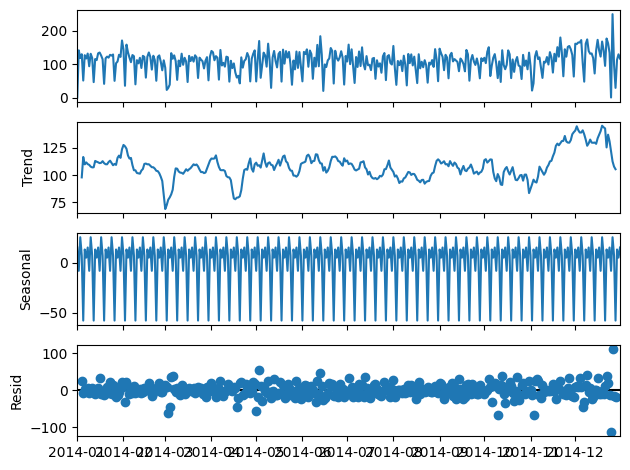

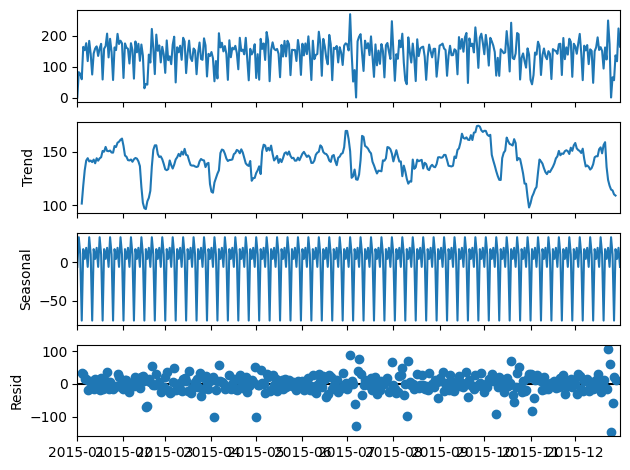

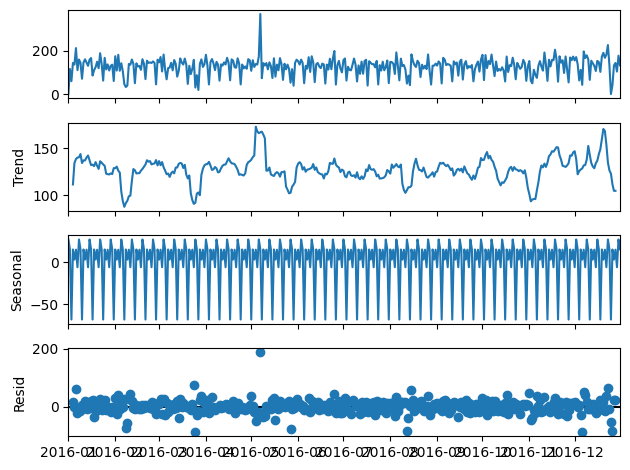

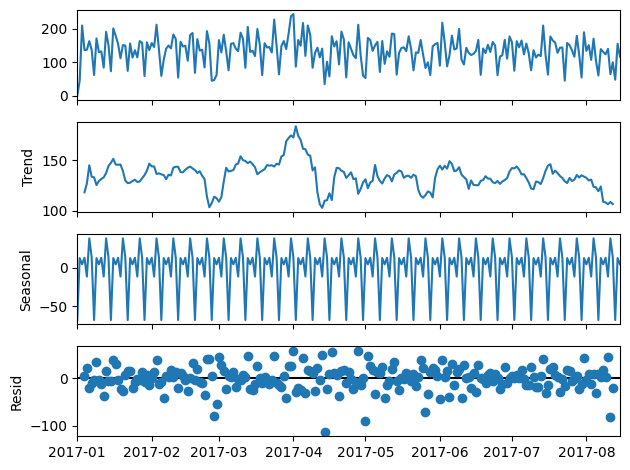

In [104]:
trend_14,season_14,resid_14=season_plots(data[data.index.year==2014]);
trend_15,season_15,resid_15=season_plots(data[data.index.year==2015]);
trend_16,season_16,resid_16=season_plots(data[data.index.year==2016]);
trend_17,season_17,resid_17=season_plots(data[data.index.year==2017]);

In [105]:
type(trend_14)

pandas.core.series.Series

In [106]:
trend_data_14=trend_14.reset_index().rename(columns={'trend':'trend_14'})
trend_data_15=trend_15.reset_index().rename(columns={'trend':'trend_15'})
trend_data_16=trend_16.reset_index().rename(columns={'trend':'trend_16'})
trend_data_17=trend_17.reset_index().rename(columns={'trend':'trend_17'})

In [107]:
trend_data_15['date'] = trend_data_15['date'] - pd.DateOffset(years=1)
trend_data_16['date'] = trend_data_16['date'] - pd.DateOffset(years=2)
trend_data_17['date'] = trend_data_17['date'] - pd.DateOffset(years=3)

In [108]:
trend_data=trend_data_15.merge(trend_data_14,on='date',how='left').merge(trend_data_16,on='date',how='left').merge(trend_data_17,on='date',how='left')

In [109]:
px.line(trend_data,x='date',y=['trend_14','trend_15','trend_16','trend_17'])

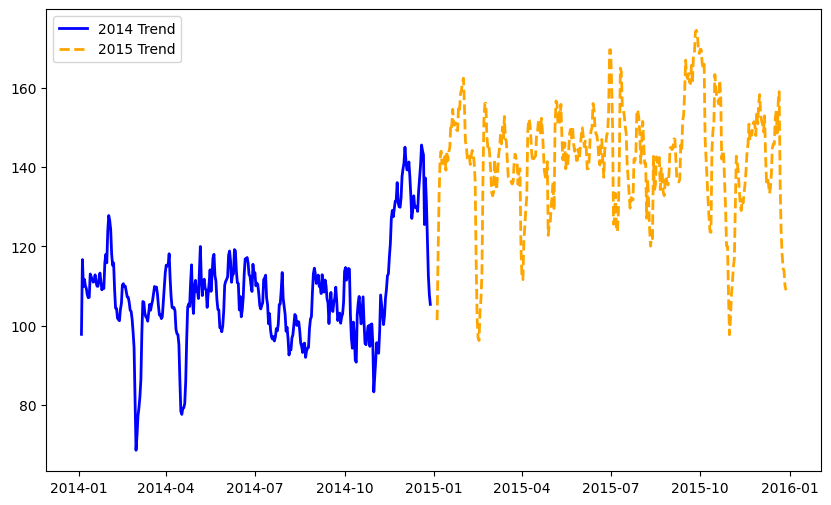

In [110]:
plt.figure(figsize=(10, 6))
plt.plot(trend_14, label='2014 Trend', color='blue', linestyle='-', linewidth=2)
plt.plot(trend_15, label='2015 Trend', color='orange', linestyle='--', linewidth=2)
plt.legend()
plt.show()

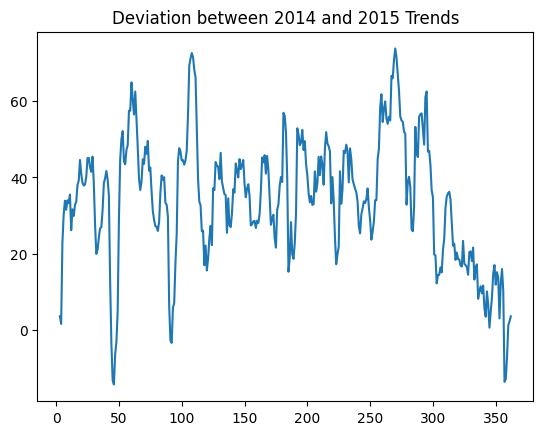

In [111]:
deviation = trend_data['trend_15'] - trend_data['trend_14']
deviation.plot(kind='line', title='Deviation between 2014 and 2015 Trends')
plt.show()

In [112]:
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults

In [164]:
def MyAutoArima(data,x=None):
    arima_model=auto_arima(y=data,
    X=x,
    start_p=2,
    d=None,
    start_q=2,
    max_p=10,
    max_d=10,
    max_q=10,
    start_P=1,
    D=None,
    start_Q=1,
    max_P=10,
    max_D=10,
    max_Q=10,
    max_order=5,
    m=1,
    seasonal=True,
    stationary=False,
    information_criterion='aic',
    alpha=0.05,
    test='kpss',
    seasonal_test='ocsb',
    stepwise=False,
    n_jobs=-1,
    start_params=None,
    trend=None,
    method='lbfgs',
    maxiter=500,
    offset_test_args=None,
    seasonal_test_args=None,
    suppress_warnings=True,
    error_action='trace',
    trace=False,
    random=False,
    random_state=None,
    n_fits=100,
    return_valid_fits=False,
    out_of_sample_size=0,
    scoring='mse',
    scoring_args=None,
    with_intercept="auto")
    return arima_model

In [114]:
req_columns=['default_rank','comb','date','sales','onpromotion','holiday_true']
df_arima_main=df_hol[req_columns]
# df_Prophet=df_Prophet.set_index('date')
df_arima_main.loc[:,'holiday_true']=df_arima_main['holiday_true'].astype('int64')
df_arima_main

default_rank                          comb       date     sales  \
0                   1                  1_AUTOMOTIVE 2013-01-01     0.000   
1                   2                   1_BABY CARE 2013-01-01     0.000   
2                   3                      1_BEAUTY 2013-01-01     0.000   
3                   4                   1_BEVERAGES 2013-01-01     0.000   
4                   5                       1_BOOKS 2013-01-01     0.000   
...               ...                           ...        ...       ...   
3008275           293                     9_POULTRY 2017-08-15   438.133   
3008276           294              9_PREPARED FOODS 2017-08-15   154.553   
3008277           295                     9_PRODUCE 2017-08-15  2419.729   
3008278           296  9_SCHOOL AND OFFICE SUPPLIES 2017-08-15   121.000   
3008279           297                     9_SEAFOOD 2017-08-15    16.000   

         onpromotion  holiday_true  
0                  0             1  
1                  0             1  
2                  0             1  
3                  0             1  
4                  0             1  
...              ...           ...  
3008275            0             0  
3008276            1             0  
3008277          148             0  
3008278            8             0  
3008279            0             0  

[3008280 rows x 6 columns]

In [115]:
df_arima=fillMissingDates(df_arima_main,unique_cols=['default_rank'],frequency='date',freq='D',grain_with_time=['default_rank','date'],sales_column=['sales','onpromotion','holiday_true'])

In [116]:
df_arima

default_rank       date  sales  onpromotion  holiday_true
0                   1 2013-01-01    0.0          0.0           1.0
1                   1 2013-01-02    2.0          0.0           0.0
2                   1 2013-01-03    3.0          0.0           0.0
3                   1 2013-01-04    3.0          0.0           0.0
4                   1 2013-01-05    5.0          0.0           1.0
...               ...        ...    ...          ...           ...
3015403          1782 2017-08-11    0.0          0.0           1.0
3015404          1782 2017-08-12    1.0          1.0           0.0
3015405          1782 2017-08-13    2.0          0.0           0.0
3015406          1782 2017-08-14    0.0          0.0           0.0
3015407          1782 2017-08-15    3.0          0.0           0.0

[3015408 rows x 5 columns]

In [117]:
groupno=45
train_data,test_data,alll_data=Split_data(df=df_arima,groupno=groupno)
# arima_model=MyAutoArima(data)
arima_scaler_sales = MinMaxScaler()
arima_scaler_onpromotion = MinMaxScaler()

train_data['sales'] = arima_scaler_sales.fit_transform(train_data[['sales']])
test_data['sales'] = arima_scaler_sales.transform(test_data[['sales']])

train_data['onpromotion'] = arima_scaler_onpromotion.fit_transform(train_data[['onpromotion']])
test_data['onpromotion'] = arima_scaler_onpromotion.transform(test_data[['onpromotion']])


train=train_data.set_index('date')[['sales']]
x=train_data.set_index('date')[['holiday_true','onpromotion']]
x_test=test_data.set_index('date')[['holiday_true','onpromotion']]



<ipython-input-117-c06d9744e970>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-117-c06d9744e970>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-117-c06d9744e970>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-117-c0

In [118]:

# Resample to daily frequency to fill missing dates


In [119]:
train['group']=1
train.reset_index(inplace=True)
train=fillMissingDates(train,unique_cols=['group'],frequency='date',freq='D',grain_with_time=['group','date'],sales_column=['sales'])
train.set_index('date',inplace=True)
train.index = pd.to_datetime(train.index)
if train.index.duplicated().any():
    print("Duplicate entries found. Resolving...")
    train = train[~train.index.duplicated(keep='first')]
train.index.freq='D'
train=train[['sales']]

Duplicate entries found. Resolving...


In [120]:
x['group']=1
x.reset_index(inplace=True)
x=fillMissingDates(x,unique_cols=['group'],frequency='date',freq='D',grain_with_time=['group','date'],sales_column=['holiday_true','onpromotion'])
x.set_index('date',inplace=True)
x.index = pd.to_datetime(x.index)
if x.index.duplicated().any():
    print("Duplicate entries found. Resolving...")
    x = x[~x.index.duplicated(keep='first')]
x.index.freq='D'
x=x[['holiday_true','onpromotion']]

Duplicate entries found. Resolving...


In [121]:
if train.index.duplicated().any():
    print("Duplicate entries found. Resolving...")
    train = train[~train.index.duplicated(keep='first')]


In [122]:
train

sales
date                
2013-01-01  0.000000
2013-01-02  0.029722
2013-01-03  0.015855
2013-01-04  0.020230
2013-01-05  0.032234
...              ...
2017-06-12  0.034025
2017-06-13  0.025902
2017-06-14  0.042324
2017-06-15  0.022903
2017-06-16  0.036981

[1628 rows x 1 columns]

In [123]:
# arima_model=MyAutoArima(train,x)
# arima_model

In [124]:
# arima_model

In [125]:
x

holiday_true  onpromotion
date                                 
2013-01-01           1.0     0.000000
2013-01-02           0.0     0.000000
2013-01-03           0.0     0.000000
2013-01-04           0.0     0.000000
2013-01-05           1.0     0.000000
...                  ...          ...
2017-06-12           0.0     0.090909
2017-06-13           0.0     0.272727
2017-06-14           0.0     0.090909
2017-06-15           0.0     0.090909
2017-06-16           0.0     0.181818

[1628 rows x 2 columns]

In [126]:
train.columns

Index(['sales'], dtype='object')

In [127]:
test_data.columns

Index(['default_rank', 'date', 'sales', 'onpromotion', 'holiday_true'], dtype='object')

In [128]:
data=train
data.shape,x.shape

((1628, 1), (1628, 2))

In [129]:

arima_model=ARIMA(endog=data,                  
      exog=x,
      order=(7, 1, 7), 
      seasonal_order=(0, 0, 0, 0), 
      trend=None,
      enforce_stationarity=True, 
      enforce_invertibility=True,
      concentrate_scale=False, 
      trend_offset=1, 
      dates=None,
      freq=None,
      missing='none', 
      validate_specification=True)

In [130]:
res = arima_model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [131]:
end=len(train)+len(test_data)-1
start=len(train)
pred_data=res.predict(start=len(train),end=len(train)+len(test_data)-1,exog=x_test).rename('Predicted_717V2_group88')


In [132]:
predicted_df=pd.DataFrame(pred_data)
predicted_df.head()

Predicted_717V2_group88
2017-06-17                 0.033202
2017-06-18                 0.031855
2017-06-19                 0.029451
2017-06-20                 0.028008
2017-06-21                 0.030335

In [133]:
predicted_df=predicted_df.reset_index().rename(columns={'index':'date'})

In [134]:
predicted_df['Predicted_717V2_group88']=arima_scaler_sales.inverse_transform(predicted_df[['Predicted_717V2_group88']])
test_data['sales']=arima_scaler_sales.inverse_transform(test_data[['sales']])

<ipython-input-134-1f8af544590a>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [135]:
predicted_df.head()

date  Predicted_717V2_group88
0 2017-06-17               124.110964
1 2017-06-18               119.075951
2 2017-06-19               110.086787
3 2017-06-20               104.693548
4 2017-06-21               113.390658

In [136]:

test_pred=test_data[['date','sales']].merge(predicted_df,on='date',how='left')


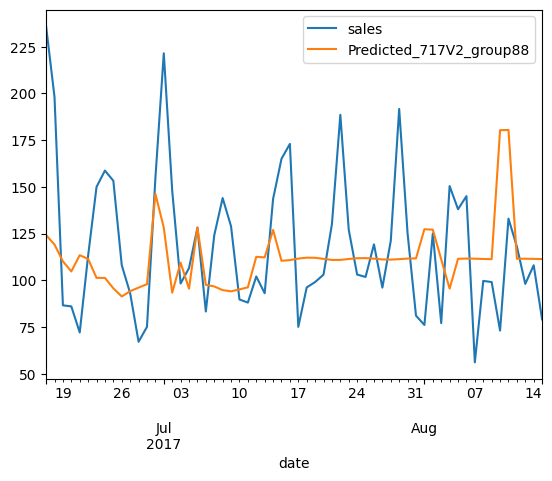

In [137]:
test_pred.set_index('date').plot()
plt.show()

In [138]:
px.line(test_pred,x='date',y=test_pred.columns)

In [139]:
# np.sqrt(mean_squared_error(test_pred['sales'],test_pred['Predicted_717V2_y']))

In [140]:
rmsle(test_pred['sales'],test_pred['Predicted_717V2_group88'])

0.3231824102442063

In [141]:
# my_test=pd.read_csv('data/test.csv',parse_dates=['date'])
# oil=pd.read_csv('data/oil.csv',parse_dates=['date'])
# train=pd.read_csv('data/train.csv',parse_dates=['date']) # main df # main df

# stores=pd.read_csv('data/stores.csv') # can be merged with train - on store no
# stores.rename(columns={'type':'store_type'},inplace=True)
# ts=pd.read_csv('data/transactions.csv',parse_dates=['date']) # can be merged with train - on store no and date

In [142]:
data='/kaggle/input/store-sales-time-series-forecasting'

In [143]:
my_test=pd.read_csv(f'{data}/test.csv',parse_dates=['date'])
oil=pd.read_csv(f'{data}/oil.csv',parse_dates=['date'])
train=pd.read_csv(f'{data}/train.csv',parse_dates=['date']) # main df # main df

stores=pd.read_csv(f'{data}/stores.csv') # can be merged with train - on store no
stores.rename(columns={'type':'store_type'},inplace=True)
ts=pd.read_csv(f'{data}/transactions.csv',parse_dates=['date']) # can be merged with train - on store no and date

In [144]:
ts

date  store_nbr  transactions
0     2013-01-01         25           770
1     2013-01-02          1          2111
2     2013-01-02          2          2358
3     2013-01-02          3          3487
4     2013-01-02          4          1922
...          ...        ...           ...
83483 2017-08-15         50          2804
83484 2017-08-15         51          1573
83485 2017-08-15         52          2255
83486 2017-08-15         53           932
83487 2017-08-15         54           802

[83488 rows x 3 columns]

In [145]:
rand_comb=df_hol[['default_rank','comb']].drop_duplicates()

In [146]:
test_data=my_test.copy(deep=True)
test_data

id       date  store_nbr                      family  onpromotion
0      3000888 2017-08-16          1                  AUTOMOTIVE            0
1      3000889 2017-08-16          1                   BABY CARE            0
2      3000890 2017-08-16          1                      BEAUTY            2
3      3000891 2017-08-16          1                   BEVERAGES           20
4      3000892 2017-08-16          1                       BOOKS            0
...        ...        ...        ...                         ...          ...
28507  3029395 2017-08-31          9                     POULTRY            1
28508  3029396 2017-08-31          9              PREPARED FOODS            0
28509  3029397 2017-08-31          9                     PRODUCE            1
28510  3029398 2017-08-31          9  SCHOOL AND OFFICE SUPPLIES            9
28511  3029399 2017-08-31          9                     SEAFOOD            0

[28512 rows x 5 columns]

In [147]:
test_data['comb']=test_data['store_nbr'].astype(str)+'_'+test_data['family']
test_data=test_data.merge(rand_comb,on='comb',how='outer',indicator=True)


In [148]:
test_data['_merge'].unique()

['both']
Categories (3, object): ['left_only', 'right_only', 'both']

In [149]:
test_data=test_data.merge(stores,on='store_nbr',how='left')
test_data

id       date  store_nbr      family  onpromotion          comb  \
0      3000888 2017-08-16          1  AUTOMOTIVE            0  1_AUTOMOTIVE   
1      3002670 2017-08-17          1  AUTOMOTIVE            0  1_AUTOMOTIVE   
2      3004452 2017-08-18          1  AUTOMOTIVE            0  1_AUTOMOTIVE   
3      3006234 2017-08-19          1  AUTOMOTIVE            0  1_AUTOMOTIVE   
4      3008016 2017-08-20          1  AUTOMOTIVE            0  1_AUTOMOTIVE   
...        ...        ...        ...         ...          ...           ...   
28507  3022271 2017-08-27          9     SEAFOOD            0     9_SEAFOOD   
28508  3024053 2017-08-28          9     SEAFOOD            0     9_SEAFOOD   
28509  3025835 2017-08-29          9     SEAFOOD            0     9_SEAFOOD   
28510  3027617 2017-08-30          9     SEAFOOD            0     9_SEAFOOD   
28511  3029399 2017-08-31          9     SEAFOOD            0     9_SEAFOOD   

       default_rank _merge   city      state store_type  cluster  
0                 1   both  Quito  Pichincha          D       13  
1                 1   both  Quito  Pichincha          D       13  
2                 1   both  Quito  Pichincha          D       13  
3                 1   both  Quito  Pichincha          D       13  
4                 1   both  Quito  Pichincha          D       13  
...             ...    ...    ...        ...        ...      ...  
28507           297   both  Quito  Pichincha          B        6  
28508           297   both  Quito  Pichincha          B        6  
28509           297   both  Quito  Pichincha          B        6  
28510           297   both  Quito  Pichincha          B        6  
28511           297   both  Quito  Pichincha          B        6  

[28512 rows x 12 columns]

In [150]:
# df_hol=df.merge(holiday_Local.reset_index(),left_on=['date','city'],right_on=['date','locale_name'],how='left')
# df_hol['local_holiday']=np.where(df_hol['locale_name'].isna(),False,True)
# df_hol=df_hol[df.columns.to_list()+['local_holiday']]
# df_hol=df_hol.merge(holiday_Regional.reset_index(),left_on=['date','state'],right_on=['date','locale_name'],how='left')
# df_hol['regional_holiday']=np.where(df_hol['locale_name'].isna(),False,True)
# df_hol=df_hol[df.columns.to_list()+['local_holiday','regional_holiday']]
# df_hol=df_hol.merge(holiday_national.reset_index(),left_on=['date'],right_on=['date'],how='left')
# df_hol['national_holiday']=np.where(df_hol['locale_name'].isna(),False,True)
# # df_hol=df_hol[df.columns.to_list()+['local_holiday','regional_holiday','national_holiday']]
# df_hol['holiday_true']=df_hol['local_holiday'] | df_hol['regional_holiday'] |df_hol['national_holiday']

In [151]:
test_data_hol=test_data.merge(holiday_Local.reset_index(),left_on=['date','city'],right_on=['date','locale_name'],how='left')
test_data_hol['local_holiday']=np.where(test_data_hol['locale_name'].isna(),False,True)
test_data_hol=test_data_hol[test_data.columns.to_list()+['local_holiday']]
test_data_hol=test_data_hol.merge(holiday_Regional.reset_index(),left_on=['date','state'],right_on=['date','locale_name'],how='left')
test_data_hol['regional_holiday']=np.where(test_data_hol['locale_name'].isna(),False,True)
test_data_hol=test_data_hol[test_data.columns.to_list()+['local_holiday','regional_holiday']]
test_data_hol=test_data_hol.merge(holiday_national.reset_index(),left_on=['date'],right_on=['date'],how='left')
test_data_hol['national_holiday']=np.where(test_data_hol['locale_name'].isna(),False,True)
# df_hol=df_hol[df.columns.to_list()+['local_holiday','regional_holiday','national_holiday']]
test_data_hol['holiday_true']=test_data_hol['local_holiday'] | test_data_hol['regional_holiday'] |test_data_hol['national_holiday']

In [152]:
test_data_hol

id       date  store_nbr      family  onpromotion          comb  \
0      3000888 2017-08-16          1  AUTOMOTIVE            0  1_AUTOMOTIVE   
1      3002670 2017-08-17          1  AUTOMOTIVE            0  1_AUTOMOTIVE   
2      3004452 2017-08-18          1  AUTOMOTIVE            0  1_AUTOMOTIVE   
3      3006234 2017-08-19          1  AUTOMOTIVE            0  1_AUTOMOTIVE   
4      3008016 2017-08-20          1  AUTOMOTIVE            0  1_AUTOMOTIVE   
...        ...        ...        ...         ...          ...           ...   
28507  3022271 2017-08-27          9     SEAFOOD            0     9_SEAFOOD   
28508  3024053 2017-08-28          9     SEAFOOD            0     9_SEAFOOD   
28509  3025835 2017-08-29          9     SEAFOOD            0     9_SEAFOOD   
28510  3027617 2017-08-30          9     SEAFOOD            0     9_SEAFOOD   
28511  3029399 2017-08-31          9     SEAFOOD            0     9_SEAFOOD   

       default_rank _merge   city      state  ... index  type  locale  \
0                 1   both  Quito  Pichincha  ...   NaN   NaN     NaN   
1                 1   both  Quito  Pichincha  ...   NaN   NaN     NaN   
2                 1   both  Quito  Pichincha  ...   NaN   NaN     NaN   
3                 1   both  Quito  Pichincha  ...   NaN   NaN     NaN   
4                 1   both  Quito  Pichincha  ...   NaN   NaN     NaN   
...             ...    ...    ...        ...  ...   ...   ...     ...   
28507           297   both  Quito  Pichincha  ...   NaN   NaN     NaN   
28508           297   both  Quito  Pichincha  ...   NaN   NaN     NaN   
28509           297   both  Quito  Pichincha  ...   NaN   NaN     NaN   
28510           297   both  Quito  Pichincha  ...   NaN   NaN     NaN   
28511           297   both  Quito  Pichincha  ...   NaN   NaN     NaN   

       locale_name  description transferred category category_reg  \
0              NaN          NaN         NaN      NaN          NaN   
1              NaN          NaN         NaN      NaN          NaN   
2              NaN          NaN         NaN      NaN          NaN   
3              NaN          NaN         NaN      NaN          NaN   
4              NaN          NaN         NaN      NaN          NaN   
...            ...          ...         ...      ...          ...   
28507          NaN          NaN         NaN      NaN          NaN   
28508          NaN          NaN         NaN      NaN          NaN   
28509          NaN          NaN         NaN      NaN          NaN   
28510          NaN          NaN         NaN      NaN          NaN   
28511          NaN          NaN         NaN      NaN          NaN   

      national_holiday holiday_true  
0                False        False  
1                False        False  
2                False        False  
3                False        False  
4                False        False  
...                ...          ...  
28507            False        False  
28508            False        False  
28509            False        False  
28510            False        False  
28511            False        False  

[28512 rows x 24 columns]

In [153]:
def Train_Predict(train,test,groupno):
    # filter the train and test data
    train_data=filter_data_for_group(train,groupno)
    test_data=filter_data_for_group(test,groupno)

    #filter required columns
    req_columns_train=['default_rank','comb','date','sales','onpromotion','holiday_true']
    req_columns_test=['default_rank','comb','date','onpromotion','holiday_true']
    train_data_f=train_data[req_columns_train]
    test_data_f=test_data[req_columns_test]

    # change holiday data into ints
    train_data_f.loc[:,'holiday_true']=train_data_f['holiday_true'].astype('int64')
    test_data_f.loc[:,'holiday_true']=test_data_f['holiday_true'].astype('int64')

    #fill missing dates
    train_data_ff=fillMissingDates(train_data_f,unique_cols=['default_rank'],frequency='date',freq='D',grain_with_time=['default_rank','date'],sales_column=['sales','onpromotion','holiday_true'])
    test_data_ff=fillMissingDates(test_data_f,unique_cols=['default_rank'],frequency='date',freq='D',grain_with_time=['default_rank','date'],sales_column=['onpromotion','holiday_true'])


    # min max scaler

    arima_scaler_sales = MinMaxScaler()
    arima_scaler_onpromotion = MinMaxScaler()
    
    train_data_ff['sales'] = arima_scaler_sales.fit_transform(train_data_ff[['sales']])
    # test_data_ff['sales'] = arima_scaler_sales.transform(test_data_ff[['sales']])
    
    train_data_ff['onpromotion'] = arima_scaler_onpromotion.fit_transform(train_data_ff[['onpromotion']])
    test_data_ff['onpromotion'] = arima_scaler_onpromotion.transform(test_data_ff[['onpromotion']])
    
    
    train_data_fff=train_data_ff.set_index('date')[['sales']]
    x=train_data_ff.set_index('date')[['holiday_true','onpromotion']]
    
    # handle the frq of the train and test data and exog variables data   
    train_data_fff['group']=1
    train_data_fff.reset_index(inplace=True)
    train_data_ffff=fillMissingDates(train_data_fff,unique_cols=['group'],frequency='date',freq='D',grain_with_time=['group','date'],sales_column=['sales'])
    train_data_ffff.set_index('date',inplace=True)
    train_data_ffff.index = pd.to_datetime(train_data_ffff.index)
    if train_data_ffff.index.duplicated().any():
        print("Duplicate entries found. Resolving...")
        train_data_ffff = train_data_ffff[~train_data_ffff.index.duplicated(keep='first')]
    train_data_ffff.index.freq='D'
    train_data_ffff=train_data_ffff[['sales']]
    

    x['group']=1
    x.reset_index(inplace=True)
    x=fillMissingDates(x,unique_cols=['group'],frequency='date',freq='D',grain_with_time=['group','date'],sales_column=['holiday_true','onpromotion'])
    x.set_index('date',inplace=True)
    x.index = pd.to_datetime(x.index)
    if x.index.duplicated().any():
        print("Duplicate entries found. Resolving...")
        x = x[~x.index.duplicated(keep='first')]
    x.index.freq='D'
    x=x[['holiday_true','onpromotion']]

    
    x_test=test_data_ff.set_index('date')[['holiday_true','onpromotion']]

    arima_model=MyAutoArima(train_data_ffff,x)
    res=arima_model.fit(y=train_data_ffff,X=x)
    
    start = len(train_data_ffff)
    end = start + len(x_test) - 1
    
    assert x.shape[1] == x_test.shape[1], "Mismatch in number of columns between training and test exogenous variables."
    assert len(x_test) == (end - start + 1), "Mismatch between prediction period and test exogenous variables."



    
    
    # Predict with exogenous variables
    pred_data = res.predict(n_periods=len(x_test), X=x_test).rename('sales')


    predicted_df=pd.DataFrame(pred_data)

    predicted_df['sales']=arima_scaler_sales.inverse_transform(predicted_df[['sales']]) 

    predicted_df=predicted_df.reset_index().rename(columns={'index':'date'})

    predicted_df=test_data[['id','date']].merge(predicted_df,on='date',how='left')
    predicted_df['Group']=groupno
    
    # # Output predictions
    return res,x_test,end,start,predicted_df,train_data_f,test_data
    

In [154]:
res,x_test,end,start,predicted_df,train_data_f,test_data=Train_Predict(df_hol,test_data_hol,77)

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...

Best model:  ARIMA(5,0,0)(0,0,0)[1] intercept
Total fit time: 31.876 seconds


In [155]:
# ??res.predict


In [156]:
predicted_df

id       date       sales  Group
0   3001624 2017-08-16  541.486938     77
1   3003406 2017-08-17  567.772289     77
2   3005188 2017-08-18  620.704315     77
3   3006970 2017-08-19  520.408179     77
4   3008752 2017-08-20  530.536574     77
5   3010534 2017-08-21  489.245886     77
6   3012316 2017-08-22  475.825994     77
7   3014098 2017-08-23  505.653280     77
8   3015880 2017-08-24  520.008415     77
9   3017662 2017-08-25  617.039212     77
10  3019444 2017-08-26  522.126931     77
11  3021226 2017-08-27  520.989288     77
12  3023008 2017-08-28  506.340915     77
13  3024790 2017-08-29  499.058025     77
14  3026572 2017-08-30  503.998599     77
15  3028354 2017-08-31  508.709409     77

In [157]:
all_groups=test_data_hol['default_rank'].unique()
all_groups

array([  1,   2,   3, ..., 295, 296, 297])

In [158]:
# all_predicted_data=[]
# for group in all_groups:
#     res,x_test,end,start,predicted_df,train_data_f,test_data=Train_Predict(df_hol,test_data_hol,group)
#     all_predicted_data.append(predicted_df)

In [159]:
import pandas as pd
import os
from tqdm import tqdm

# Function to save data periodically
def save_batch_data(data_list, save_path, batch_number):
    if not os.path.exists(save_path):
        os.makedirs(save_path)  # Create directory if it doesn't exist
    
    combined_df = pd.concat(data_list, ignore_index=True)
    file_name = f"predicted_batch_{batch_number}.csv"
    file_path = os.path.join(save_path, file_name)
    combined_df.to_csv(file_path, index=False)
    print(f"Batch {batch_number} saved to {file_path}")

# Main processing loop with tqdm for progress bar
def process_all_groups(df_hol, test_data_hol, all_groups, save_interval=100, save_path="predicted_data"):
    all_predicted_data = []
    batch_counter = 0  # To track number of processed batches

    # Loop through groups with tqdm
    for i, group in enumerate(tqdm(all_groups, desc="Processing Groups"), start=1):
        # Process group data
        res, x_test, end, start, predicted_df, train_data_f, test_data = Train_Predict(df_hol, test_data_hol, group)
        all_predicted_data.append(predicted_df)
        
        # Check if it's time to save the data
        if i % save_interval == 0:
            batch_counter += 1
            save_batch_data(all_predicted_data, save_path, batch_counter)
            all_predicted_data.clear()  # Clear the list after saving to free memory

    # Save remaining data if any after the loop ends
    if all_predicted_data:
        batch_counter += 1
        save_batch_data(all_predicted_data, save_path, batch_counter)


In [ ]:
from tqdm import tqdm

if __name__ == '__main__':
    all_groups = df_hol['default_rank'].unique()  # Assuming 'group' is a column in df_hol
    process_all_groups(df_hol, test_data_hol, all_groups, save_interval=10, save_path="predicted_data")

Processing Groups:   0%|          | 0/1782 [00:00<?, ?it/s]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   0%|          | 1/1782 [00:40<19:49:35, 40.08s/it]/usr/local/lib/python3.10/dist-packages/pmdarima/arima/auto.py:444: UserWarning:

Input time-series is completely constant; returning a (0, 0, 0) ARMA.



Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   0%|          | 3/1782 [01:05<10:08:04, 20.51s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   0%|          | 4/1782 [01:45<13:58:03, 28.28s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   0%|          | 5/1782 [02:16<14:22:18, 29.12s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   0%|          | 6/1782 [03:02<17:14:34, 34.95s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   0%|          | 7/1782 [03:28<15:47:06, 32.01s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   0%|          | 8/1782 [04:29<20:19:15, 41.24s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   1%|          | 9/1782 [05:41<24:57:35, 50.68s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   1%|          | 10/1782 [06:21<23:24:19, 47.55s/it]

Batch 1 saved to predicted_data/predicted_batch_1.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   1%|          | 11/1782 [07:10<23:39:57, 48.11s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   1%|          | 12/1782 [07:50<22:20:27, 45.44s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   1%|          | 13/1782 [08:39<22:56:31, 46.69s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   1%|          | 14/1782 [09:11<20:45:15, 42.26s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   1%|          | 15/1782 [09:45<19:25:21, 39.57s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   1%|          | 16/1782 [10:20<18:48:01, 38.32s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   1%|          | 17/1782 [10:58<18:42:11, 38.15s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   1%|          | 18/1782 [11:21<16:28:07, 33.61s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   1%|          | 19/1782 [12:10<18:46:30, 38.34s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   1%|          | 20/1782 [12:40<17:33:27, 35.87s/it]

Batch 2 saved to predicted_data/predicted_batch_2.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   1%|          | 21/1782 [13:21<18:11:22, 37.18s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   1%|          | 22/1782 [13:52<17:14:46, 35.28s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   1%|▏         | 23/1782 [14:36<18:37:54, 38.13s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   1%|▏         | 24/1782 [15:18<19:10:12, 39.26s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   1%|▏         | 25/1782 [16:23<22:52:50, 46.88s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   1%|▏         | 26/1782 [17:13<23:20:53, 47.87s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   2%|▏         | 27/1782 [17:42<20:37:10, 42.30s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   2%|▏         | 28/1782 [18:22<20:11:09, 41.43s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   2%|▏         | 29/1782 [19:24<23:10:43, 47.60s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   2%|▏         | 30/1782 [20:04<22:02:27, 45.29s/it]

Batch 3 saved to predicted_data/predicted_batch_3.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   2%|▏         | 31/1782 [20:40<20:39:54, 42.49s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   2%|▏         | 32/1782 [21:16<19:44:04, 40.60s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   2%|▏         | 33/1782 [21:56<19:39:21, 40.46s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   2%|▏         | 34/1782 [22:30<18:43:18, 38.56s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   2%|▏         | 35/1782 [23:02<17:44:55, 36.57s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   2%|▏         | 36/1782 [23:33<16:57:25, 34.96s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   2%|▏         | 37/1782 [24:17<18:11:26, 37.53s/it]/usr/local/lib/python3.10/dist-packages/pmdarima/arima/auto.py:444: UserWarning:

Input time-series is completely constant; returning a (0, 0, 0) ARMA.



Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   2%|▏         | 38/1782 [24:17<12:50:20, 26.50s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   2%|▏         | 39/1782 [25:00<15:08:40, 31.28s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   2%|▏         | 40/1782 [25:35<15:37:30, 32.29s/it]

Batch 4 saved to predicted_data/predicted_batch_4.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   2%|▏         | 41/1782 [26:00<14:37:46, 30.25s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   2%|▏         | 42/1782 [26:54<18:03:15, 37.35s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   2%|▏         | 43/1782 [27:33<18:20:45, 37.98s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   2%|▏         | 44/1782 [28:15<18:52:47, 39.11s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   3%|▎         | 45/1782 [28:53<18:43:44, 38.82s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   3%|▎         | 46/1782 [29:38<19:36:46, 40.67s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   3%|▎         | 47/1782 [30:19<19:36:02, 40.67s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   3%|▎         | 48/1782 [30:49<18:01:12, 37.41s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   3%|▎         | 49/1782 [31:16<16:32:59, 34.38s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   3%|▎         | 50/1782 [31:54<17:04:11, 35.48s/it]

Batch 5 saved to predicted_data/predicted_batch_5.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   3%|▎         | 51/1782 [32:26<16:30:50, 34.34s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   3%|▎         | 52/1782 [32:52<15:22:44, 32.00s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   3%|▎         | 53/1782 [33:44<18:09:37, 37.81s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   3%|▎         | 54/1782 [34:01<15:11:15, 31.64s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   3%|▎         | 55/1782 [34:29<14:37:41, 30.49s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   3%|▎         | 56/1782 [35:10<16:08:05, 33.65s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   3%|▎         | 57/1782 [35:39<15:31:17, 32.39s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   3%|▎         | 58/1782 [36:23<17:10:21, 35.86s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   3%|▎         | 59/1782 [37:07<18:18:01, 38.24s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   3%|▎         | 60/1782 [37:59<20:13:21, 42.28s/it]

Batch 6 saved to predicted_data/predicted_batch_6.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   3%|▎         | 61/1782 [38:40<20:02:46, 41.93s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   3%|▎         | 62/1782 [39:29<21:01:33, 44.01s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   4%|▎         | 63/1782 [40:12<20:53:55, 43.77s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   4%|▎         | 64/1782 [40:49<19:57:30, 41.82s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   4%|▎         | 65/1782 [41:31<19:55:39, 41.78s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   4%|▎         | 66/1782 [41:56<17:33:28, 36.83s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   4%|▍         | 67/1782 [42:26<16:30:23, 34.65s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   4%|▍         | 68/1782 [43:16<18:44:50, 39.38s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   4%|▍         | 69/1782 [43:54<18:34:57, 39.05s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   4%|▍         | 70/1782 [44:39<19:19:03, 40.62s/it]

Batch 7 saved to predicted_data/predicted_batch_7.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


/usr/local/lib/python3.10/dist-packages/pmdarima/arima/auto.py:444: UserWarning:

Input time-series is completely constant; returning a (0, 0, 0) ARMA.

Processing Groups:   4%|▍         | 71/1782 [44:39<13:37:40, 28.67s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   4%|▍         | 72/1782 [45:35<17:23:02, 36.60s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   4%|▍         | 73/1782 [46:13<17:39:02, 37.18s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   4%|▍         | 74/1782 [47:08<20:12:31, 42.59s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   4%|▍         | 75/1782 [48:17<23:56:21, 50.49s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   4%|▍         | 76/1782 [49:05<23:30:03, 49.59s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   4%|▍         | 77/1782 [49:44<22:03:37, 46.58s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   4%|▍         | 78/1782 [50:29<21:43:48, 45.91s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   4%|▍         | 79/1782 [51:21<22:37:05, 47.81s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   4%|▍         | 80/1782 [51:52<20:11:00, 42.69s/it]

Batch 8 saved to predicted_data/predicted_batch_8.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   5%|▍         | 81/1782 [52:18<17:50:04, 37.75s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   5%|▍         | 82/1782 [53:02<18:42:17, 39.61s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   5%|▍         | 83/1782 [53:42<18:45:36, 39.75s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   5%|▍         | 84/1782 [54:32<20:10:31, 42.77s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   5%|▍         | 85/1782 [55:12<19:47:07, 41.97s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   5%|▍         | 86/1782 [55:46<18:39:58, 39.62s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   5%|▍         | 87/1782 [56:21<18:01:17, 38.28s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   5%|▍         | 88/1782 [56:48<16:23:28, 34.83s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   5%|▍         | 89/1782 [57:29<17:18:43, 36.81s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   5%|▌         | 90/1782 [58:16<18:41:18, 39.76s/it]

Batch 9 saved to predicted_data/predicted_batch_9.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   5%|▌         | 91/1782 [58:55<18:35:46, 39.59s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   5%|▌         | 92/1782 [59:39<19:09:16, 40.80s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   5%|▌         | 93/1782 [1:00:17<18:45:26, 39.98s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   5%|▌         | 94/1782 [1:00:49<17:39:00, 37.64s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   5%|▌         | 95/1782 [1:01:42<19:48:06, 42.26s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   5%|▌         | 96/1782 [1:02:15<18:29:56, 39.50s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   5%|▌         | 97/1782 [1:02:50<17:47:28, 38.01s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   5%|▌         | 98/1782 [1:03:27<17:38:37, 37.72s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   6%|▌         | 99/1782 [1:03:59<16:51:49, 36.07s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   6%|▌         | 100/1782 [1:04:35<16:49:52, 36.02s/it]

Batch 10 saved to predicted_data/predicted_batch_10.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   6%|▌         | 101/1782 [1:05:04<15:55:41, 34.11s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   6%|▌         | 102/1782 [1:06:01<19:03:44, 40.85s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   6%|▌         | 103/1782 [1:06:43<19:12:05, 41.17s/it]/usr/local/lib/python3.10/dist-packages/pmdarima/arima/auto.py:444: UserWarning:

Input time-series is completely constant; returning a (0, 0, 0) ARMA.



Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   6%|▌         | 104/1782 [1:06:44<13:32:46, 29.06s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   6%|▌         | 105/1782 [1:07:15<13:51:16, 29.74s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   6%|▌         | 106/1782 [1:07:47<14:13:22, 30.55s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   6%|▌         | 107/1782 [1:08:31<16:01:13, 34.43s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   6%|▌         | 108/1782 [1:09:24<18:36:19, 40.01s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   6%|▌         | 109/1782 [1:10:05<18:43:11, 40.28s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   6%|▌         | 110/1782 [1:10:39<17:51:56, 38.47s/it]

Batch 11 saved to predicted_data/predicted_batch_11.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   6%|▌         | 111/1782 [1:11:25<18:54:26, 40.73s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   6%|▋         | 112/1782 [1:12:04<18:33:35, 40.01s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   6%|▋         | 113/1782 [1:12:41<18:14:24, 39.34s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   6%|▋         | 114/1782 [1:13:17<17:46:51, 38.38s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   6%|▋         | 115/1782 [1:13:46<16:22:09, 35.35s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   7%|▋         | 116/1782 [1:14:19<16:02:10, 34.65s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   7%|▋         | 117/1782 [1:14:46<15:03:48, 32.57s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   7%|▋         | 118/1782 [1:15:30<16:36:35, 35.94s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   7%|▋         | 119/1782 [1:15:52<14:40:18, 31.76s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   7%|▋         | 120/1782 [1:16:03<11:44:05, 25.42s/it]

Batch 12 saved to predicted_data/predicted_batch_12.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   7%|▋         | 121/1782 [1:16:31<12:09:28, 26.35s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   7%|▋         | 122/1782 [1:17:05<13:11:17, 28.60s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   7%|▋         | 123/1782 [1:17:44<14:32:22, 31.55s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   7%|▋         | 124/1782 [1:17:57<11:58:15, 25.99s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   7%|▋         | 125/1782 [1:18:30<12:57:42, 28.16s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   7%|▋         | 126/1782 [1:18:57<12:48:32, 27.85s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   7%|▋         | 127/1782 [1:19:40<14:53:01, 32.38s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   7%|▋         | 128/1782 [1:20:19<15:48:09, 34.40s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   7%|▋         | 129/1782 [1:20:56<16:11:15, 35.25s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   7%|▋         | 130/1782 [1:21:27<15:35:28, 33.98s/it]

Batch 13 saved to predicted_data/predicted_batch_13.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   7%|▋         | 131/1782 [1:21:55<14:44:12, 32.13s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   7%|▋         | 132/1782 [1:22:36<15:56:51, 34.79s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   7%|▋         | 133/1782 [1:23:07<15:23:08, 33.59s/it]/usr/local/lib/python3.10/dist-packages/pmdarima/arima/auto.py:444: UserWarning:

Input time-series is completely constant; returning a (0, 0, 0) ARMA.



Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   8%|▊         | 134/1782 [1:23:08<10:52:02, 23.74s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   8%|▊         | 135/1782 [1:23:51<13:29:43, 29.50s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   8%|▊         | 136/1782 [1:24:26<14:17:08, 31.24s/it]/usr/local/lib/python3.10/dist-packages/pmdarima/arima/auto.py:444: UserWarning:

Input time-series is completely constant; returning a (0, 0, 0) ARMA.



Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   8%|▊         | 137/1782 [1:24:27<10:05:58, 22.10s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   8%|▊         | 138/1782 [1:25:09<12:48:10, 28.04s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   8%|▊         | 139/1782 [1:25:37<12:52:08, 28.20s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   8%|▊         | 140/1782 [1:26:24<15:28:09, 33.92s/it]

Batch 14 saved to predicted_data/predicted_batch_14.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   8%|▊         | 141/1782 [1:27:10<16:59:30, 37.28s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   8%|▊         | 142/1782 [1:27:58<18:27:48, 40.53s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   8%|▊         | 143/1782 [1:28:37<18:19:13, 40.24s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   8%|▊         | 144/1782 [1:29:14<17:53:23, 39.32s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   8%|▊         | 145/1782 [1:30:00<18:44:18, 41.21s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   8%|▊         | 146/1782 [1:30:44<19:02:15, 41.89s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   8%|▊         | 147/1782 [1:30:55<14:54:27, 32.82s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   8%|▊         | 148/1782 [1:31:30<15:10:47, 33.44s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   8%|▊         | 149/1782 [1:31:56<14:08:11, 31.16s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   8%|▊         | 150/1782 [1:32:26<14:01:12, 30.93s/it]

Batch 15 saved to predicted_data/predicted_batch_15.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   8%|▊         | 151/1782 [1:33:09<15:36:09, 34.44s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   9%|▊         | 152/1782 [1:33:50<16:30:54, 36.47s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   9%|▊         | 153/1782 [1:34:02<13:11:07, 29.14s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   9%|▊         | 154/1782 [1:34:47<15:17:56, 33.83s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   9%|▊         | 155/1782 [1:35:28<16:13:23, 35.90s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   9%|▉         | 156/1782 [1:36:07<16:40:38, 36.92s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   9%|▉         | 157/1782 [1:37:01<18:59:01, 42.06s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   9%|▉         | 158/1782 [1:37:47<19:26:41, 43.10s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   9%|▉         | 159/1782 [1:38:17<17:44:28, 39.35s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   9%|▉         | 160/1782 [1:38:54<17:19:53, 38.47s/it]

Batch 16 saved to predicted_data/predicted_batch_16.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   9%|▉         | 161/1782 [1:40:08<22:08:07, 49.16s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   9%|▉         | 162/1782 [1:40:44<20:23:58, 45.33s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   9%|▉         | 163/1782 [1:41:17<18:42:23, 41.60s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   9%|▉         | 164/1782 [1:41:54<18:05:27, 40.25s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   9%|▉         | 165/1782 [1:42:33<17:53:45, 39.84s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   9%|▉         | 166/1782 [1:43:03<16:35:13, 36.95s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   9%|▉         | 167/1782 [1:43:27<14:46:09, 32.92s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   9%|▉         | 168/1782 [1:43:57<14:25:01, 32.16s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:   9%|▉         | 169/1782 [1:44:45<16:28:52, 36.78s/it]/usr/local/lib/python3.10/dist-packages/pmdarima/arima/auto.py:444: UserWarning:

Input time-series is completely constant; returning a (0, 0, 0) ARMA.



Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  10%|▉         | 170/1782 [1:44:45<11:38:20, 25.99s/it]

Batch 17 saved to predicted_data/predicted_batch_17.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  10%|▉         | 171/1782 [1:45:27<13:40:30, 30.56s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  10%|▉         | 172/1782 [1:46:03<14:28:37, 32.37s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  10%|▉         | 173/1782 [1:46:40<15:01:57, 33.63s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  10%|▉         | 174/1782 [1:47:21<16:04:04, 35.97s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  10%|▉         | 175/1782 [1:48:08<17:28:56, 39.16s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  10%|▉         | 176/1782 [1:48:37<16:05:38, 36.08s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  10%|▉         | 177/1782 [1:49:05<15:05:27, 33.85s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  10%|▉         | 178/1782 [1:49:46<15:59:13, 35.88s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  10%|█         | 179/1782 [1:50:22<15:57:06, 35.82s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  10%|█         | 180/1782 [1:50:48<14:39:08, 32.93s/it]

Batch 18 saved to predicted_data/predicted_batch_18.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  10%|█         | 181/1782 [1:51:18<14:12:34, 31.95s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  10%|█         | 182/1782 [1:52:09<16:50:51, 37.91s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  10%|█         | 183/1782 [1:52:32<14:51:08, 33.44s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  10%|█         | 184/1782 [1:53:10<15:26:51, 34.80s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  10%|█         | 185/1782 [1:53:42<15:02:35, 33.91s/it]/usr/local/lib/python3.10/dist-packages/pmdarima/arima/auto.py:444: UserWarning:

Input time-series is completely constant; returning a (0, 0, 0) ARMA.



Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  10%|█         | 186/1782 [1:53:43<10:37:48, 23.98s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  10%|█         | 187/1782 [1:54:13<11:24:01, 25.73s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  11%|█         | 188/1782 [1:55:00<14:18:09, 32.30s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  11%|█         | 189/1782 [1:55:33<14:20:07, 32.40s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  11%|█         | 190/1782 [1:56:21<16:26:56, 37.20s/it]

Batch 19 saved to predicted_data/predicted_batch_19.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  11%|█         | 191/1782 [1:57:07<17:32:04, 39.68s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  11%|█         | 192/1782 [1:57:39<16:30:05, 37.36s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  11%|█         | 193/1782 [1:58:37<19:11:01, 43.46s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  11%|█         | 194/1782 [1:59:33<20:56:05, 47.46s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  11%|█         | 195/1782 [2:00:25<21:31:43, 48.84s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  11%|█         | 196/1782 [2:01:09<20:52:33, 47.39s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  11%|█         | 197/1782 [2:01:39<18:32:45, 42.12s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  11%|█         | 198/1782 [2:02:15<17:40:17, 40.16s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  11%|█         | 199/1782 [2:02:46<16:24:37, 37.32s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  11%|█         | 200/1782 [2:03:22<16:21:05, 37.21s/it]

Batch 20 saved to predicted_data/predicted_batch_20.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  11%|█▏        | 201/1782 [2:04:00<16:26:32, 37.44s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  11%|█▏        | 202/1782 [2:04:32<15:38:52, 35.65s/it]/usr/local/lib/python3.10/dist-packages/pmdarima/arima/auto.py:444: UserWarning:

Input time-series is completely constant; returning a (0, 0, 0) ARMA.



Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  11%|█▏        | 203/1782 [2:04:33<11:03:03, 25.20s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  11%|█▏        | 204/1782 [2:05:16<13:28:27, 30.74s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  12%|█▏        | 205/1782 [2:05:48<13:30:44, 30.85s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  12%|█▏        | 206/1782 [2:06:31<15:10:06, 34.65s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  12%|█▏        | 207/1782 [2:07:15<16:24:07, 37.49s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  12%|█▏        | 208/1782 [2:08:05<18:03:05, 41.29s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  12%|█▏        | 209/1782 [2:08:40<17:12:06, 39.37s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  12%|█▏        | 210/1782 [2:09:23<17:34:53, 40.26s/it]

Batch 21 saved to predicted_data/predicted_batch_21.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  12%|█▏        | 211/1782 [2:10:05<17:53:58, 41.02s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  12%|█▏        | 212/1782 [2:10:48<18:02:35, 41.37s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  12%|█▏        | 213/1782 [2:11:24<17:22:02, 39.85s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  12%|█▏        | 214/1782 [2:11:53<15:57:24, 36.64s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  12%|█▏        | 215/1782 [2:12:28<15:45:49, 36.22s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  12%|█▏        | 216/1782 [2:12:59<15:04:14, 34.65s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  12%|█▏        | 217/1782 [2:13:50<17:13:52, 39.64s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  12%|█▏        | 218/1782 [2:14:19<15:49:34, 36.43s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  12%|█▏        | 219/1782 [2:14:28<12:08:57, 27.98s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  12%|█▏        | 220/1782 [2:15:10<14:02:53, 32.38s/it]

Batch 22 saved to predicted_data/predicted_batch_22.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  12%|█▏        | 221/1782 [2:15:48<14:43:24, 33.96s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  12%|█▏        | 222/1782 [2:16:25<15:10:33, 35.02s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  13%|█▎        | 223/1782 [2:17:08<16:08:42, 37.28s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  13%|█▎        | 224/1782 [2:17:52<17:02:31, 39.38s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  13%|█▎        | 225/1782 [2:18:38<17:52:56, 41.35s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  13%|█▎        | 226/1782 [2:19:11<16:47:51, 38.86s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  13%|█▎        | 227/1782 [2:19:44<15:56:33, 36.91s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  13%|█▎        | 228/1782 [2:20:27<16:48:23, 38.93s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  13%|█▎        | 229/1782 [2:21:04<16:29:29, 38.23s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  13%|█▎        | 230/1782 [2:21:36<15:44:29, 36.51s/it]

Batch 23 saved to predicted_data/predicted_batch_23.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  13%|█▎        | 231/1782 [2:22:28<17:43:34, 41.14s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  13%|█▎        | 232/1782 [2:23:24<19:32:23, 45.38s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  13%|█▎        | 233/1782 [2:23:49<16:53:40, 39.26s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  13%|█▎        | 234/1782 [2:24:24<16:22:18, 38.07s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  13%|█▎        | 235/1782 [2:25:20<18:39:08, 43.41s/it]/usr/local/lib/python3.10/dist-packages/pmdarima/arima/auto.py:444: UserWarning:

Input time-series is completely constant; returning a (0, 0, 0) ARMA.



Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  13%|█▎        | 236/1782 [2:25:21<13:09:01, 30.62s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  13%|█▎        | 237/1782 [2:26:13<15:53:59, 37.05s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  13%|█▎        | 238/1782 [2:26:49<15:45:49, 36.76s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  13%|█▎        | 239/1782 [2:27:26<15:51:43, 37.01s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  13%|█▎        | 240/1782 [2:28:19<17:50:41, 41.66s/it]

Batch 24 saved to predicted_data/predicted_batch_24.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  14%|█▎        | 241/1782 [2:29:09<18:57:05, 44.27s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  14%|█▎        | 242/1782 [2:29:42<17:29:46, 40.90s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  14%|█▎        | 243/1782 [2:30:31<18:29:50, 43.27s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  14%|█▎        | 244/1782 [2:31:20<19:09:44, 44.85s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  14%|█▎        | 245/1782 [2:31:58<18:20:03, 42.94s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  14%|█▍        | 246/1782 [2:32:26<16:25:30, 38.50s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  14%|█▍        | 247/1782 [2:33:19<18:16:14, 42.85s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  14%|█▍        | 248/1782 [2:33:53<17:07:21, 40.18s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  14%|█▍        | 249/1782 [2:34:23<15:47:46, 37.10s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  14%|█▍        | 250/1782 [2:35:10<17:01:04, 39.99s/it]

Batch 25 saved to predicted_data/predicted_batch_25.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


/usr/local/lib/python3.10/dist-packages/pmdarima/arima/auto.py:444: UserWarning:

Input time-series is completely constant; returning a (0, 0, 0) ARMA.

Processing Groups:  14%|█▍        | 251/1782 [2:35:10<12:00:08, 28.22s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  14%|█▍        | 252/1782 [2:35:35<11:30:31, 27.08s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  14%|█▍        | 253/1782 [2:36:17<13:24:04, 31.55s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  14%|█▍        | 254/1782 [2:36:55<14:15:07, 33.58s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  14%|█▍        | 255/1782 [2:37:39<15:32:45, 36.65s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  14%|█▍        | 256/1782 [2:38:28<17:08:47, 40.45s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  14%|█▍        | 257/1782 [2:39:16<18:04:45, 42.68s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  14%|█▍        | 258/1782 [2:39:53<17:16:10, 40.79s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  15%|█▍        | 259/1782 [2:40:38<17:49:01, 42.12s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  15%|█▍        | 260/1782 [2:41:19<17:44:32, 41.97s/it]

Batch 26 saved to predicted_data/predicted_batch_26.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  15%|█▍        | 261/1782 [2:42:01<17:39:47, 41.81s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  15%|█▍        | 262/1782 [2:42:34<16:34:14, 39.25s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  15%|█▍        | 263/1782 [2:43:17<17:02:42, 40.40s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  15%|█▍        | 264/1782 [2:43:52<16:21:06, 38.78s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  15%|█▍        | 265/1782 [2:44:39<17:19:49, 41.13s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  15%|█▍        | 266/1782 [2:45:12<16:22:31, 38.89s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  15%|█▍        | 267/1782 [2:45:51<16:22:32, 38.91s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  15%|█▌        | 268/1782 [2:47:14<21:55:27, 52.13s/it]/usr/local/lib/python3.10/dist-packages/pmdarima/arima/auto.py:444: UserWarning:

Input time-series is completely constant; returning a (0, 0, 0) ARMA.



Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  15%|█▌        | 269/1782 [2:47:15<15:26:12, 36.73s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  15%|█▌        | 270/1782 [2:48:11<17:46:42, 42.33s/it]

Batch 27 saved to predicted_data/predicted_batch_27.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  15%|█▌        | 271/1782 [2:49:00<18:37:05, 44.36s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  15%|█▌        | 272/1782 [2:49:50<19:21:55, 46.17s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  15%|█▌        | 273/1782 [2:50:39<19:43:36, 47.06s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  15%|█▌        | 274/1782 [2:51:24<19:27:21, 46.45s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  15%|█▌        | 275/1782 [2:52:13<19:40:33, 47.00s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  15%|█▌        | 276/1782 [2:53:05<20:24:18, 48.78s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  16%|█▌        | 277/1782 [2:53:53<20:11:40, 48.31s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  16%|█▌        | 278/1782 [2:54:36<19:33:10, 46.80s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  16%|█▌        | 279/1782 [2:55:03<17:01:27, 40.78s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  16%|█▌        | 280/1782 [2:55:48<17:36:44, 42.21s/it]

Batch 28 saved to predicted_data/predicted_batch_28.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  16%|█▌        | 281/1782 [2:56:35<18:10:34, 43.59s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  16%|█▌        | 282/1782 [2:57:14<17:32:13, 42.09s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  16%|█▌        | 283/1782 [2:58:11<19:24:31, 46.61s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  16%|█▌        | 284/1782 [2:59:06<20:27:07, 49.15s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  16%|█▌        | 285/1782 [2:59:43<18:57:07, 45.58s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  16%|█▌        | 286/1782 [3:00:11<16:40:13, 40.12s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  16%|█▌        | 287/1782 [3:00:43<15:43:31, 37.87s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  16%|█▌        | 288/1782 [3:01:21<15:39:54, 37.75s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  16%|█▌        | 289/1782 [3:01:37<13:01:10, 31.39s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  16%|█▋        | 290/1782 [3:02:23<14:45:31, 35.61s/it]

Batch 29 saved to predicted_data/predicted_batch_29.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  16%|█▋        | 291/1782 [3:02:56<14:31:37, 35.08s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  16%|█▋        | 292/1782 [3:03:38<15:18:31, 36.99s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  16%|█▋        | 293/1782 [3:04:21<16:06:47, 38.96s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  16%|█▋        | 294/1782 [3:05:05<16:39:51, 40.32s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  17%|█▋        | 295/1782 [3:05:44<16:28:07, 39.87s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  17%|█▋        | 296/1782 [3:06:14<15:18:37, 37.09s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  17%|█▋        | 297/1782 [3:07:11<17:45:24, 43.05s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  17%|█▋        | 298/1782 [3:07:47<16:48:46, 40.79s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  17%|█▋        | 299/1782 [3:08:14<15:07:27, 36.71s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  17%|█▋        | 300/1782 [3:08:47<14:38:52, 35.58s/it]

Batch 30 saved to predicted_data/predicted_batch_30.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  17%|█▋        | 301/1782 [3:09:24<14:50:04, 36.06s/it]/usr/local/lib/python3.10/dist-packages/pmdarima/arima/auto.py:444: UserWarning:

Input time-series is completely constant; returning a (0, 0, 0) ARMA.



Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  17%|█▋        | 302/1782 [3:09:25<10:29:26, 25.52s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  17%|█▋        | 303/1782 [3:10:11<13:02:51, 31.76s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  17%|█▋        | 304/1782 [3:10:24<10:38:04, 25.90s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  17%|█▋        | 305/1782 [3:11:10<13:06:52, 31.97s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  17%|█▋        | 306/1782 [3:11:57<14:56:29, 36.44s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  17%|█▋        | 307/1782 [3:12:43<16:09:37, 39.44s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  17%|█▋        | 308/1782 [3:13:41<18:22:06, 44.86s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  17%|█▋        | 309/1782 [3:14:12<16:45:26, 40.95s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  17%|█▋        | 310/1782 [3:15:19<19:55:39, 48.74s/it]

Batch 31 saved to predicted_data/predicted_batch_31.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  17%|█▋        | 311/1782 [3:16:01<19:00:14, 46.51s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  18%|█▊        | 312/1782 [3:16:33<17:17:10, 42.33s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  18%|█▊        | 313/1782 [3:17:07<16:14:56, 39.82s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  18%|█▊        | 314/1782 [3:17:46<16:09:36, 39.63s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  18%|█▊        | 315/1782 [3:18:05<13:37:13, 33.42s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  18%|█▊        | 316/1782 [3:19:08<17:09:45, 42.15s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  18%|█▊        | 317/1782 [3:19:42<16:14:20, 39.90s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  18%|█▊        | 318/1782 [3:20:13<15:03:33, 37.03s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  18%|█▊        | 319/1782 [3:20:40<13:50:29, 34.06s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  18%|█▊        | 320/1782 [3:21:19<14:27:23, 35.60s/it]

Batch 32 saved to predicted_data/predicted_batch_32.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  18%|█▊        | 321/1782 [3:21:55<14:30:38, 35.76s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  18%|█▊        | 322/1782 [3:22:52<17:01:48, 41.99s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  18%|█▊        | 323/1782 [3:23:37<17:26:38, 43.04s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  18%|█▊        | 324/1782 [3:24:06<15:38:17, 38.61s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  18%|█▊        | 325/1782 [3:24:41<15:12:39, 37.58s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  18%|█▊        | 326/1782 [3:25:19<15:16:08, 37.75s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  18%|█▊        | 327/1782 [3:25:51<14:37:32, 36.19s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  18%|█▊        | 328/1782 [3:26:23<14:06:34, 34.93s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  18%|█▊        | 329/1782 [3:26:55<13:44:11, 34.03s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  19%|█▊        | 330/1782 [3:27:56<16:55:55, 41.98s/it]

Batch 33 saved to predicted_data/predicted_batch_33.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  19%|█▊        | 331/1782 [3:28:35<16:36:13, 41.19s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  19%|█▊        | 332/1782 [3:29:33<18:33:07, 46.06s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  19%|█▊        | 333/1782 [3:30:04<16:46:48, 41.69s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  19%|█▊        | 334/1782 [3:30:46<16:50:38, 41.88s/it]/usr/local/lib/python3.10/dist-packages/pmdarima/arima/auto.py:444: UserWarning:

Input time-series is completely constant; returning a (0, 0, 0) ARMA.



Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  19%|█▉        | 335/1782 [3:30:47<11:52:31, 29.55s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  19%|█▉        | 336/1782 [3:31:25<12:51:35, 32.02s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  19%|█▉        | 337/1782 [3:32:01<13:20:57, 33.26s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  19%|█▉        | 338/1782 [3:32:57<16:01:56, 39.97s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  19%|█▉        | 339/1782 [3:33:45<17:02:12, 42.50s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  19%|█▉        | 340/1782 [3:34:21<16:14:49, 40.56s/it]

Batch 34 saved to predicted_data/predicted_batch_34.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  19%|█▉        | 341/1782 [3:34:59<15:54:55, 39.76s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  19%|█▉        | 342/1782 [3:35:45<16:41:34, 41.73s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  19%|█▉        | 343/1782 [3:36:28<16:48:38, 42.06s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  19%|█▉        | 344/1782 [3:36:57<15:13:49, 38.13s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  19%|█▉        | 345/1782 [3:37:28<14:20:18, 35.92s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  19%|█▉        | 346/1782 [3:38:03<14:14:42, 35.71s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  19%|█▉        | 347/1782 [3:38:36<13:51:02, 34.75s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  20%|█▉        | 348/1782 [3:39:10<13:46:14, 34.57s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  20%|█▉        | 349/1782 [3:39:49<14:19:56, 36.01s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  20%|█▉        | 350/1782 [3:40:36<15:35:16, 39.19s/it]

Batch 35 saved to predicted_data/predicted_batch_35.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  20%|█▉        | 351/1782 [3:40:46<12:05:55, 30.44s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  20%|█▉        | 352/1782 [3:41:12<11:31:00, 28.99s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  20%|█▉        | 353/1782 [3:41:36<10:57:37, 27.61s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  20%|█▉        | 354/1782 [3:42:14<12:14:24, 30.86s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  20%|█▉        | 355/1782 [3:43:07<14:48:06, 37.34s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  20%|█▉        | 356/1782 [3:43:48<15:18:07, 38.63s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  20%|██        | 357/1782 [3:44:26<15:07:46, 38.22s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  20%|██        | 358/1782 [3:44:58<14:27:49, 36.57s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  20%|██        | 359/1782 [3:45:49<16:08:10, 40.82s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  20%|██        | 360/1782 [3:46:28<15:55:32, 40.32s/it]

Batch 36 saved to predicted_data/predicted_batch_36.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  20%|██        | 361/1782 [3:47:07<15:41:31, 39.75s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  20%|██        | 362/1782 [3:47:31<13:53:12, 35.21s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  20%|██        | 363/1782 [3:48:03<13:30:32, 34.27s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  20%|██        | 364/1782 [3:48:35<13:12:49, 33.55s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  20%|██        | 365/1782 [3:49:11<13:29:08, 34.26s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  21%|██        | 366/1782 [3:49:43<13:09:09, 33.44s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  21%|██        | 367/1782 [3:50:27<14:24:29, 36.66s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  21%|██        | 368/1782 [3:50:55<13:24:29, 34.14s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  21%|██        | 369/1782 [3:51:48<15:37:09, 39.79s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  21%|██        | 370/1782 [3:52:44<17:26:40, 44.48s/it]

Batch 37 saved to predicted_data/predicted_batch_37.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  21%|██        | 371/1782 [3:53:34<18:06:09, 46.19s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  21%|██        | 372/1782 [3:54:28<19:03:27, 48.66s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  21%|██        | 373/1782 [3:55:07<17:56:41, 45.85s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  21%|██        | 374/1782 [3:55:59<18:34:41, 47.50s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  21%|██        | 375/1782 [3:56:27<16:16:20, 41.63s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  21%|██        | 376/1782 [3:56:54<14:37:50, 37.46s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  21%|██        | 377/1782 [3:57:26<13:58:13, 35.80s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  21%|██        | 378/1782 [3:57:52<12:47:06, 32.78s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  21%|██▏       | 379/1782 [3:58:32<13:37:50, 34.98s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  21%|██▏       | 380/1782 [3:59:04<13:14:43, 34.01s/it]

Batch 38 saved to predicted_data/predicted_batch_38.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  21%|██▏       | 381/1782 [3:59:22<11:22:14, 29.22s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  21%|██▏       | 382/1782 [3:59:56<11:57:53, 30.77s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  21%|██▏       | 383/1782 [4:00:44<13:57:44, 35.93s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  22%|██▏       | 384/1782 [4:01:23<14:13:41, 36.64s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  22%|██▏       | 385/1782 [4:01:56<13:47:40, 35.55s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  22%|██▏       | 386/1782 [4:02:47<15:38:29, 40.34s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  22%|██▏       | 387/1782 [4:03:25<15:19:19, 39.54s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  22%|██▏       | 388/1782 [4:04:02<15:02:10, 38.83s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  22%|██▏       | 389/1782 [4:04:32<14:02:53, 36.31s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  22%|██▏       | 390/1782 [4:05:09<14:03:21, 36.35s/it]

Batch 39 saved to predicted_data/predicted_batch_39.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  22%|██▏       | 391/1782 [4:05:54<15:01:05, 38.87s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  22%|██▏       | 392/1782 [4:06:39<15:42:29, 40.68s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  22%|██▏       | 393/1782 [4:07:41<18:11:22, 47.14s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  22%|██▏       | 394/1782 [4:08:25<17:48:18, 46.18s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  22%|██▏       | 395/1782 [4:08:58<16:18:04, 42.31s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  22%|██▏       | 396/1782 [4:09:41<16:23:34, 42.58s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  22%|██▏       | 397/1782 [4:10:14<15:18:12, 39.78s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  22%|██▏       | 398/1782 [4:10:46<14:20:43, 37.31s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  22%|██▏       | 399/1782 [4:11:31<15:10:25, 39.50s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  22%|██▏       | 400/1782 [4:12:08<14:56:39, 38.93s/it]

Batch 40 saved to predicted_data/predicted_batch_40.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


/usr/local/lib/python3.10/dist-packages/pmdarima/arima/auto.py:444: UserWarning:

Input time-series is completely constant; returning a (0, 0, 0) ARMA.

Processing Groups:  23%|██▎       | 401/1782 [4:12:09<10:32:27, 27.48s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  23%|██▎       | 402/1782 [4:12:55<12:43:16, 33.19s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  23%|██▎       | 403/1782 [4:13:48<14:58:02, 39.07s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  23%|██▎       | 404/1782 [4:14:50<17:36:22, 46.00s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  23%|██▎       | 405/1782 [4:15:49<18:59:16, 49.64s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  23%|██▎       | 406/1782 [4:16:33<18:25:35, 48.21s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  23%|██▎       | 407/1782 [4:17:20<18:12:39, 47.68s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  23%|██▎       | 408/1782 [4:18:00<17:20:48, 45.45s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  23%|██▎       | 409/1782 [4:18:31<15:41:47, 41.16s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  23%|██▎       | 410/1782 [4:19:08<15:09:40, 39.78s/it]

Batch 41 saved to predicted_data/predicted_batch_41.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  23%|██▎       | 411/1782 [4:19:40<14:16:11, 37.47s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  23%|██▎       | 412/1782 [4:20:26<15:11:47, 39.93s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  23%|██▎       | 413/1782 [4:21:07<15:20:32, 40.35s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  23%|██▎       | 414/1782 [4:21:41<14:36:39, 38.45s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  23%|██▎       | 415/1782 [4:22:43<17:17:34, 45.54s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  23%|██▎       | 416/1782 [4:23:42<18:45:27, 49.43s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  23%|██▎       | 417/1782 [4:24:36<19:18:28, 50.92s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  23%|██▎       | 418/1782 [4:25:13<17:39:43, 46.62s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  24%|██▎       | 419/1782 [4:25:59<17:39:19, 46.63s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  24%|██▎       | 420/1782 [4:26:39<16:54:23, 44.69s/it]

Batch 42 saved to predicted_data/predicted_batch_42.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  24%|██▎       | 421/1782 [4:27:31<17:40:09, 46.74s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  24%|██▎       | 422/1782 [4:28:06<16:21:13, 43.29s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  24%|██▎       | 423/1782 [4:28:41<15:24:42, 40.83s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  24%|██▍       | 424/1782 [4:29:16<14:41:25, 38.94s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  24%|██▍       | 425/1782 [4:30:06<16:00:58, 42.49s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  24%|██▍       | 426/1782 [4:31:05<17:47:51, 47.25s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  24%|██▍       | 427/1782 [4:31:48<17:17:08, 45.92s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  24%|██▍       | 428/1782 [4:32:30<16:51:31, 44.82s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  24%|██▍       | 429/1782 [4:33:21<17:36:01, 46.83s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  24%|██▍       | 430/1782 [4:34:18<18:38:12, 49.62s/it]

Batch 43 saved to predicted_data/predicted_batch_43.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  24%|██▍       | 431/1782 [4:35:03<18:08:47, 48.35s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  24%|██▍       | 432/1782 [4:35:38<16:35:14, 44.23s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  24%|██▍       | 433/1782 [4:36:39<18:31:09, 49.42s/it]/usr/local/lib/python3.10/dist-packages/pmdarima/arima/auto.py:444: UserWarning:

Input time-series is completely constant; returning a (0, 0, 0) ARMA.



Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  24%|██▍       | 434/1782 [4:36:40<13:02:23, 34.82s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  24%|██▍       | 435/1782 [4:37:20<13:38:03, 36.44s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  24%|██▍       | 436/1782 [4:38:02<14:14:02, 38.07s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  25%|██▍       | 437/1782 [4:38:36<13:44:18, 36.77s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  25%|██▍       | 438/1782 [4:39:29<15:37:53, 41.87s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  25%|██▍       | 439/1782 [4:40:29<17:36:20, 47.19s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  25%|██▍       | 440/1782 [4:41:15<17:28:45, 46.89s/it]

Batch 44 saved to predicted_data/predicted_batch_44.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  25%|██▍       | 441/1782 [4:41:55<16:37:09, 44.62s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  25%|██▍       | 442/1782 [4:42:40<16:43:25, 44.93s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  25%|██▍       | 443/1782 [4:43:12<15:13:38, 40.94s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  25%|██▍       | 444/1782 [4:43:46<14:28:25, 38.94s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  25%|██▍       | 445/1782 [4:44:20<13:56:00, 37.52s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  25%|██▌       | 446/1782 [4:44:54<13:28:43, 36.32s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  25%|██▌       | 447/1782 [4:45:37<14:11:34, 38.27s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  25%|██▌       | 448/1782 [4:46:31<15:56:35, 43.03s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  25%|██▌       | 449/1782 [4:47:16<16:11:17, 43.72s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  25%|██▌       | 450/1782 [4:47:54<15:33:18, 42.04s/it]

Batch 45 saved to predicted_data/predicted_batch_45.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  25%|██▌       | 451/1782 [4:48:29<14:45:18, 39.91s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  25%|██▌       | 452/1782 [4:49:16<15:28:17, 41.88s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  25%|██▌       | 453/1782 [4:49:48<14:22:49, 38.95s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  25%|██▌       | 454/1782 [4:50:30<14:40:57, 39.80s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  26%|██▌       | 455/1782 [4:51:30<16:53:39, 45.83s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  26%|██▌       | 456/1782 [4:52:07<15:55:14, 43.22s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  26%|██▌       | 457/1782 [4:52:48<15:41:22, 42.63s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  26%|██▌       | 458/1782 [4:53:34<16:01:26, 43.57s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  26%|██▌       | 459/1782 [4:54:11<15:21:16, 41.78s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  26%|██▌       | 460/1782 [4:54:55<15:36:00, 42.48s/it]

Batch 46 saved to predicted_data/predicted_batch_46.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  26%|██▌       | 461/1782 [4:55:39<15:45:45, 42.96s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  26%|██▌       | 462/1782 [4:56:15<14:58:56, 40.86s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  26%|██▌       | 463/1782 [4:56:50<14:14:12, 38.86s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  26%|██▌       | 464/1782 [4:57:36<15:00:44, 41.00s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  26%|██▌       | 465/1782 [4:58:11<14:21:18, 39.24s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  26%|██▌       | 466/1782 [4:59:07<16:14:08, 44.41s/it]/usr/local/lib/python3.10/dist-packages/pmdarima/arima/auto.py:444: UserWarning:

Input time-series is completely constant; returning a (0, 0, 0) ARMA.



Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  26%|██▌       | 467/1782 [4:59:08<11:26:27, 31.32s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  26%|██▋       | 468/1782 [4:59:53<12:55:19, 35.40s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  26%|██▋       | 469/1782 [5:00:25<12:34:58, 34.50s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  26%|██▋       | 470/1782 [5:01:10<13:41:02, 37.55s/it]

Batch 47 saved to predicted_data/predicted_batch_47.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  26%|██▋       | 471/1782 [5:01:59<14:56:48, 41.04s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  26%|██▋       | 472/1782 [5:02:56<16:41:57, 45.89s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  27%|██▋       | 473/1782 [5:03:29<15:12:50, 41.84s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  27%|██▋       | 474/1782 [5:04:09<15:01:03, 41.33s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  27%|██▋       | 475/1782 [5:04:55<15:33:36, 42.86s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  27%|██▋       | 476/1782 [5:05:39<15:35:15, 42.97s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  27%|██▋       | 477/1782 [5:06:41<17:42:34, 48.85s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  27%|██▋       | 478/1782 [5:07:23<16:55:51, 46.74s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  27%|██▋       | 479/1782 [5:08:04<16:15:16, 44.91s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  27%|██▋       | 480/1782 [5:08:35<14:49:36, 41.00s/it]

Batch 48 saved to predicted_data/predicted_batch_48.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  27%|██▋       | 481/1782 [5:09:32<16:28:42, 45.60s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  27%|██▋       | 482/1782 [5:10:04<15:01:15, 41.60s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  27%|██▋       | 483/1782 [5:10:30<13:16:51, 36.81s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  27%|██▋       | 484/1782 [5:11:07<13:19:18, 36.95s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  27%|██▋       | 485/1782 [5:11:41<12:57:11, 35.95s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  27%|██▋       | 486/1782 [5:12:20<13:19:47, 37.03s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  27%|██▋       | 487/1782 [5:12:49<12:24:00, 34.47s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  27%|██▋       | 488/1782 [5:13:30<13:08:45, 36.57s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  27%|██▋       | 489/1782 [5:14:09<13:23:52, 37.30s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  27%|██▋       | 490/1782 [5:14:49<13:42:15, 38.19s/it]

Batch 49 saved to predicted_data/predicted_batch_49.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  28%|██▊       | 491/1782 [5:15:40<15:00:15, 41.84s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  28%|██▊       | 492/1782 [5:16:24<15:16:09, 42.61s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  28%|██▊       | 493/1782 [5:17:02<14:44:08, 41.16s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  28%|██▊       | 494/1782 [5:17:40<14:21:25, 40.13s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  28%|██▊       | 495/1782 [5:18:20<14:20:29, 40.12s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  28%|██▊       | 496/1782 [5:18:56<13:54:13, 38.92s/it]/usr/local/lib/python3.10/dist-packages/pmdarima/arima/auto.py:444: UserWarning:

Input time-series is completely constant; returning a (0, 0, 0) ARMA.



Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  28%|██▊       | 497/1782 [5:18:57<9:48:16, 27.47s/it] 

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  28%|██▊       | 498/1782 [5:19:23<9:39:02, 27.06s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  28%|██▊       | 499/1782 [5:20:11<11:53:18, 33.36s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  28%|██▊       | 500/1782 [5:20:40<11:26:29, 32.13s/it]

Batch 50 saved to predicted_data/predicted_batch_50.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  28%|██▊       | 501/1782 [5:21:27<13:03:47, 36.71s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  28%|██▊       | 502/1782 [5:21:54<11:55:32, 33.54s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  28%|██▊       | 503/1782 [5:22:26<11:50:47, 33.34s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  28%|██▊       | 504/1782 [5:23:16<13:35:54, 38.31s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  28%|██▊       | 505/1782 [5:24:02<14:19:54, 40.40s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  28%|██▊       | 506/1782 [5:24:45<14:36:14, 41.20s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  28%|██▊       | 507/1782 [5:25:18<13:44:44, 38.81s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  29%|██▊       | 508/1782 [5:26:02<14:16:39, 40.35s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  29%|██▊       | 509/1782 [5:26:32<13:11:52, 37.32s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  29%|██▊       | 510/1782 [5:27:05<12:41:36, 35.92s/it]

Batch 51 saved to predicted_data/predicted_batch_51.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  29%|██▊       | 511/1782 [5:27:31<11:38:35, 32.98s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  29%|██▊       | 512/1782 [5:28:17<13:02:04, 36.95s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  29%|██▉       | 513/1782 [5:28:45<12:04:54, 34.27s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  29%|██▉       | 514/1782 [5:29:23<12:24:18, 35.22s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  29%|██▉       | 515/1782 [5:30:14<14:07:44, 40.15s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  29%|██▉       | 516/1782 [5:30:49<13:36:00, 38.67s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  29%|██▉       | 517/1782 [5:31:25<13:18:19, 37.87s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  29%|██▉       | 518/1782 [5:32:06<13:34:49, 38.68s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  29%|██▉       | 519/1782 [5:32:45<13:39:05, 38.91s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  29%|██▉       | 520/1782 [5:33:30<14:16:49, 40.74s/it]

Batch 52 saved to predicted_data/predicted_batch_52.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  29%|██▉       | 521/1782 [5:34:10<14:11:32, 40.52s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  29%|██▉       | 522/1782 [5:34:58<14:53:24, 42.54s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  29%|██▉       | 523/1782 [5:35:30<13:49:28, 39.53s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  29%|██▉       | 524/1782 [5:36:23<15:09:26, 43.38s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  29%|██▉       | 525/1782 [5:36:58<14:16:42, 40.89s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  30%|██▉       | 526/1782 [5:37:32<13:36:24, 39.00s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  30%|██▉       | 527/1782 [5:38:17<14:08:51, 40.58s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  30%|██▉       | 528/1782 [5:38:50<13:22:44, 38.41s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  30%|██▉       | 529/1782 [5:39:22<12:41:30, 36.46s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  30%|██▉       | 530/1782 [5:39:54<12:12:56, 35.12s/it]

Batch 53 saved to predicted_data/predicted_batch_53.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  30%|██▉       | 531/1782 [5:40:30<12:22:18, 35.60s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  30%|██▉       | 532/1782 [5:41:12<12:58:59, 37.39s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  30%|██▉       | 533/1782 [5:41:36<11:37:17, 33.50s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  30%|██▉       | 534/1782 [5:42:19<12:34:16, 36.26s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  30%|███       | 535/1782 [5:42:59<12:52:41, 37.18s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  30%|███       | 536/1782 [5:43:33<12:32:28, 36.23s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  30%|███       | 537/1782 [5:44:13<12:57:42, 37.48s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  30%|███       | 538/1782 [5:44:54<13:21:13, 38.64s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  30%|███       | 539/1782 [5:45:31<13:10:39, 38.16s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  30%|███       | 540/1782 [5:46:09<13:06:36, 38.00s/it]

Batch 54 saved to predicted_data/predicted_batch_54.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  30%|███       | 541/1782 [5:46:42<12:37:06, 36.60s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  30%|███       | 542/1782 [5:46:57<10:18:23, 29.92s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  30%|███       | 543/1782 [5:47:20<9:35:12, 27.86s/it] 

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  31%|███       | 544/1782 [5:48:10<11:53:57, 34.60s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  31%|███       | 545/1782 [5:48:43<11:45:50, 34.24s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  31%|███       | 546/1782 [5:49:14<11:20:19, 33.03s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  31%|███       | 547/1782 [5:49:49<11:35:22, 33.78s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  31%|███       | 548/1782 [5:50:19<11:09:23, 32.55s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  31%|███       | 549/1782 [5:50:57<11:41:40, 34.14s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  31%|███       | 550/1782 [5:51:35<12:09:51, 35.55s/it]

Batch 55 saved to predicted_data/predicted_batch_55.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  31%|███       | 551/1782 [5:52:25<13:32:27, 39.60s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  31%|███       | 552/1782 [5:53:02<13:17:26, 38.90s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  31%|███       | 553/1782 [5:53:43<13:31:32, 39.62s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  31%|███       | 554/1782 [5:54:21<13:19:07, 39.05s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  31%|███       | 555/1782 [5:54:55<12:50:11, 37.66s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  31%|███       | 556/1782 [5:55:40<13:30:06, 39.65s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  31%|███▏      | 557/1782 [5:56:16<13:10:42, 38.73s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  31%|███▏      | 558/1782 [5:56:53<12:58:03, 38.14s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  31%|███▏      | 559/1782 [5:57:24<12:17:26, 36.18s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  31%|███▏      | 560/1782 [5:58:00<12:12:15, 35.95s/it]

Batch 56 saved to predicted_data/predicted_batch_56.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  31%|███▏      | 561/1782 [5:58:38<12:24:53, 36.60s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  32%|███▏      | 562/1782 [5:59:15<12:23:47, 36.58s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  32%|███▏      | 563/1782 [5:59:42<11:25:01, 33.72s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  32%|███▏      | 564/1782 [6:00:15<11:21:52, 33.59s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  32%|███▏      | 565/1782 [6:00:50<11:27:47, 33.91s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  32%|███▏      | 566/1782 [6:01:18<10:55:02, 32.32s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  32%|███▏      | 567/1782 [6:02:09<12:49:48, 38.02s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  32%|███▏      | 568/1782 [6:03:07<14:48:18, 43.90s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  32%|███▏      | 569/1782 [6:03:43<14:00:24, 41.57s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  32%|███▏      | 570/1782 [6:04:23<13:47:00, 40.94s/it]

Batch 57 saved to predicted_data/predicted_batch_57.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  32%|███▏      | 571/1782 [6:04:59<13:17:56, 39.53s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  32%|███▏      | 572/1782 [6:05:40<13:28:03, 40.07s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  32%|███▏      | 573/1782 [6:06:25<13:53:27, 41.36s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  32%|███▏      | 574/1782 [6:07:15<14:49:06, 44.16s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  32%|███▏      | 575/1782 [6:07:58<14:36:21, 43.56s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  32%|███▏      | 576/1782 [6:08:28<13:16:41, 39.64s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  32%|███▏      | 577/1782 [6:09:02<12:43:42, 38.03s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  32%|███▏      | 578/1782 [6:09:38<12:30:42, 37.41s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  32%|███▏      | 579/1782 [6:10:11<12:01:32, 35.99s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  33%|███▎      | 580/1782 [6:10:47<12:04:09, 36.15s/it]

Batch 58 saved to predicted_data/predicted_batch_58.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


/usr/local/lib/python3.10/dist-packages/pmdarima/arima/auto.py:444: UserWarning:

Input time-series is completely constant; returning a (0, 0, 0) ARMA.

Processing Groups:  33%|███▎      | 581/1782 [6:10:48<8:31:06, 25.53s/it] 

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  33%|███▎      | 582/1782 [6:11:37<10:51:21, 32.57s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  33%|███▎      | 583/1782 [6:12:20<11:51:10, 35.59s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  33%|███▎      | 584/1782 [6:12:54<11:44:09, 35.27s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  33%|███▎      | 585/1782 [6:13:25<11:13:18, 33.75s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  33%|███▎      | 586/1782 [6:14:03<11:41:32, 35.19s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  33%|███▎      | 587/1782 [6:14:45<12:20:50, 37.20s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  33%|███▎      | 588/1782 [6:15:11<11:12:40, 33.80s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  33%|███▎      | 589/1782 [6:15:58<12:31:35, 37.80s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  33%|███▎      | 590/1782 [6:16:32<12:10:20, 36.76s/it]

Batch 59 saved to predicted_data/predicted_batch_59.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  33%|███▎      | 591/1782 [6:17:12<12:30:07, 37.79s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  33%|███▎      | 592/1782 [6:17:50<12:27:34, 37.69s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  33%|███▎      | 593/1782 [6:18:45<14:09:05, 42.85s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  33%|███▎      | 594/1782 [6:19:22<13:31:44, 41.00s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  33%|███▎      | 595/1782 [6:20:07<13:57:55, 42.36s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  33%|███▎      | 596/1782 [6:20:44<13:22:47, 40.61s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  34%|███▎      | 597/1782 [6:21:30<13:58:16, 42.44s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  34%|███▎      | 598/1782 [6:22:07<13:20:45, 40.58s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  34%|███▎      | 599/1782 [6:22:43<12:56:15, 39.37s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  34%|███▎      | 600/1782 [6:23:41<14:44:09, 44.88s/it]

Batch 60 saved to predicted_data/predicted_batch_60.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  34%|███▎      | 601/1782 [6:24:25<14:37:17, 44.57s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  34%|███▍      | 602/1782 [6:25:15<15:11:11, 46.33s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  34%|███▍      | 603/1782 [6:25:59<14:57:19, 45.67s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  34%|███▍      | 604/1782 [6:26:57<16:07:04, 49.26s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  34%|███▍      | 605/1782 [6:27:54<16:50:07, 51.49s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  34%|███▍      | 606/1782 [6:28:34<15:42:34, 48.09s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  34%|███▍      | 607/1782 [6:29:06<14:08:27, 43.33s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  34%|███▍      | 608/1782 [6:29:48<14:01:34, 43.01s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  34%|███▍      | 609/1782 [6:30:02<11:11:29, 34.35s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  34%|███▍      | 610/1782 [6:30:36<11:06:11, 34.11s/it]

Batch 61 saved to predicted_data/predicted_batch_61.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  34%|███▍      | 611/1782 [6:31:11<11:09:01, 34.28s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  34%|███▍      | 612/1782 [6:31:37<10:19:59, 31.79s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  34%|███▍      | 613/1782 [6:32:09<10:20:38, 31.85s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  34%|███▍      | 614/1782 [6:32:45<10:48:11, 33.30s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  35%|███▍      | 615/1782 [6:33:19<10:50:10, 33.43s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  35%|███▍      | 616/1782 [6:33:48<10:26:39, 32.25s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  35%|███▍      | 617/1782 [6:34:13<9:40:06, 29.88s/it] 

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  35%|███▍      | 618/1782 [6:34:52<10:36:13, 32.79s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  35%|███▍      | 619/1782 [6:35:26<10:40:44, 33.06s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  35%|███▍      | 620/1782 [6:36:06<11:21:41, 35.20s/it]

Batch 62 saved to predicted_data/predicted_batch_62.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  35%|███▍      | 621/1782 [6:36:36<10:46:41, 33.42s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  35%|███▍      | 622/1782 [6:37:06<10:29:51, 32.58s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  35%|███▍      | 623/1782 [6:37:56<12:07:08, 37.64s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  35%|███▌      | 624/1782 [6:38:26<11:23:28, 35.41s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  35%|███▌      | 625/1782 [6:39:09<12:08:25, 37.77s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  35%|███▌      | 626/1782 [6:39:54<12:49:55, 39.96s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  35%|███▌      | 627/1782 [6:40:25<11:58:17, 37.31s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  35%|███▌      | 628/1782 [6:40:59<11:38:16, 36.31s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  35%|███▌      | 629/1782 [6:41:36<11:41:38, 36.51s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  35%|███▌      | 630/1782 [6:42:10<11:24:48, 35.67s/it]

Batch 63 saved to predicted_data/predicted_batch_63.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  35%|███▌      | 631/1782 [6:42:54<12:11:08, 38.11s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  35%|███▌      | 632/1782 [6:43:23<11:16:43, 35.31s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  36%|███▌      | 633/1782 [6:44:19<13:17:07, 41.63s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  36%|███▌      | 634/1782 [6:45:15<14:40:38, 46.03s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  36%|███▌      | 635/1782 [6:46:08<15:19:54, 48.12s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  36%|███▌      | 636/1782 [6:47:06<16:13:39, 50.98s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  36%|███▌      | 637/1782 [6:47:59<16:27:39, 51.76s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  36%|███▌      | 638/1782 [6:48:47<16:03:57, 50.56s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  36%|███▌      | 639/1782 [6:49:32<15:27:36, 48.69s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  36%|███▌      | 640/1782 [6:50:31<16:30:30, 52.04s/it]

Batch 64 saved to predicted_data/predicted_batch_64.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  36%|███▌      | 641/1782 [6:51:15<15:42:22, 49.55s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  36%|███▌      | 642/1782 [6:51:48<14:08:53, 44.68s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  36%|███▌      | 643/1782 [6:52:19<12:47:18, 40.42s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  36%|███▌      | 644/1782 [6:52:49<11:47:35, 37.31s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  36%|███▌      | 645/1782 [6:53:12<10:28:01, 33.14s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  36%|███▋      | 646/1782 [6:54:07<12:29:13, 39.57s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  36%|███▋      | 647/1782 [6:55:02<13:57:21, 44.27s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  36%|███▋      | 648/1782 [6:55:36<12:58:28, 41.19s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  36%|███▋      | 649/1782 [6:56:20<13:12:05, 41.95s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  36%|███▋      | 650/1782 [6:57:19<14:50:28, 47.20s/it]

Batch 65 saved to predicted_data/predicted_batch_65.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  37%|███▋      | 651/1782 [6:57:54<13:37:39, 43.38s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  37%|███▋      | 652/1782 [6:58:43<14:08:49, 45.07s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  37%|███▋      | 653/1782 [6:59:34<14:42:26, 46.90s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  37%|███▋      | 654/1782 [7:00:07<13:25:20, 42.84s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  37%|███▋      | 655/1782 [7:00:39<12:22:17, 39.52s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  37%|███▋      | 656/1782 [7:01:25<12:57:08, 41.41s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  37%|███▋      | 657/1782 [7:02:09<13:11:40, 42.22s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  37%|███▋      | 658/1782 [7:02:56<13:39:29, 43.74s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  37%|███▋      | 659/1782 [7:03:44<14:02:30, 45.01s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  37%|███▋      | 660/1782 [7:04:25<13:40:00, 43.85s/it]

Batch 66 saved to predicted_data/predicted_batch_66.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  37%|███▋      | 661/1782 [7:04:57<12:28:57, 40.09s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  37%|███▋      | 662/1782 [7:05:24<11:15:47, 36.20s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  37%|███▋      | 663/1782 [7:05:56<10:53:59, 35.07s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  37%|███▋      | 664/1782 [7:06:46<12:17:28, 39.58s/it]/usr/local/lib/python3.10/dist-packages/pmdarima/arima/auto.py:444: UserWarning:

Input time-series is completely constant; returning a (0, 0, 0) ARMA.



Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  37%|███▋      | 665/1782 [7:06:47<8:39:54, 27.93s/it] 

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  37%|███▋      | 666/1782 [7:07:38<10:46:28, 34.76s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  37%|███▋      | 667/1782 [7:08:52<14:23:27, 46.46s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  37%|███▋      | 668/1782 [7:09:43<14:51:51, 48.04s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  38%|███▊      | 669/1782 [7:10:36<15:14:07, 49.28s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  38%|███▊      | 670/1782 [7:11:37<16:20:03, 52.88s/it]

Batch 67 saved to predicted_data/predicted_batch_67.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  38%|███▊      | 671/1782 [7:12:21<15:28:41, 50.15s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  38%|███▊      | 672/1782 [7:12:58<14:19:21, 46.45s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  38%|███▊      | 673/1782 [7:13:41<13:59:05, 45.40s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  38%|███▊      | 674/1782 [7:14:17<13:06:19, 42.58s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  38%|███▊      | 675/1782 [7:14:49<12:05:21, 39.31s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  38%|███▊      | 676/1782 [7:15:20<11:18:01, 36.78s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  38%|███▊      | 677/1782 [7:16:01<11:39:30, 37.98s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  38%|███▊      | 678/1782 [7:16:41<11:50:55, 38.64s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  38%|███▊      | 679/1782 [7:17:50<14:38:14, 47.77s/it]/usr/local/lib/python3.10/dist-packages/pmdarima/arima/auto.py:444: UserWarning:

Input time-series is completely constant; returning a (0, 0, 0) ARMA.



Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  38%|███▊      | 680/1782 [7:17:51<10:18:26, 33.67s/it]

Batch 68 saved to predicted_data/predicted_batch_68.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  38%|███▊      | 681/1782 [7:18:27<10:33:50, 34.54s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  38%|███▊      | 682/1782 [7:19:08<11:09:38, 36.53s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  38%|███▊      | 683/1782 [7:19:46<11:14:00, 36.80s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  38%|███▊      | 684/1782 [7:20:21<11:05:13, 36.35s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  38%|███▊      | 685/1782 [7:21:15<12:38:21, 41.48s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  38%|███▊      | 686/1782 [7:22:12<14:06:47, 46.36s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  39%|███▊      | 687/1782 [7:22:48<13:07:36, 43.16s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  39%|███▊      | 688/1782 [7:23:29<12:56:18, 42.58s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  39%|███▊      | 689/1782 [7:24:35<14:59:50, 49.40s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  39%|███▊      | 690/1782 [7:25:18<14:24:22, 47.49s/it]

Batch 69 saved to predicted_data/predicted_batch_69.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  39%|███▉      | 691/1782 [7:25:52<13:10:32, 43.48s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  39%|███▉      | 692/1782 [7:26:18<11:37:19, 38.39s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  39%|███▉      | 693/1782 [7:26:50<11:01:47, 36.46s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  39%|███▉      | 694/1782 [7:27:18<10:14:37, 33.89s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  39%|███▉      | 695/1782 [7:27:50<10:04:32, 33.37s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  39%|███▉      | 696/1782 [7:28:30<10:38:17, 35.26s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  39%|███▉      | 697/1782 [7:29:24<12:19:22, 40.89s/it]/usr/local/lib/python3.10/dist-packages/pmdarima/arima/auto.py:444: UserWarning:

Input time-series is completely constant; returning a (0, 0, 0) ARMA.



Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  39%|███▉      | 698/1782 [7:29:25<8:41:15, 28.85s/it] 

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  39%|███▉      | 699/1782 [7:30:03<9:29:49, 31.57s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  39%|███▉      | 700/1782 [7:30:40<10:01:55, 33.38s/it]

Batch 70 saved to predicted_data/predicted_batch_70.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  39%|███▉      | 701/1782 [7:31:25<11:01:14, 36.70s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  39%|███▉      | 702/1782 [7:32:25<13:08:51, 43.83s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  39%|███▉      | 703/1782 [7:33:52<17:01:54, 56.83s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  40%|███▉      | 704/1782 [7:34:37<15:53:01, 53.04s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  40%|███▉      | 705/1782 [7:35:08<13:56:14, 46.59s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  40%|███▉      | 706/1782 [7:35:53<13:49:07, 46.23s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  40%|███▉      | 707/1782 [7:36:36<13:26:51, 45.03s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  40%|███▉      | 708/1782 [7:37:05<12:00:03, 40.23s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  40%|███▉      | 709/1782 [7:37:50<12:27:30, 41.80s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  40%|███▉      | 710/1782 [7:38:27<11:57:36, 40.16s/it]

Batch 71 saved to predicted_data/predicted_batch_71.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  40%|███▉      | 711/1782 [7:39:27<13:45:37, 46.25s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  40%|███▉      | 712/1782 [7:40:12<13:35:53, 45.75s/it]/usr/local/lib/python3.10/dist-packages/pmdarima/arima/auto.py:444: UserWarning:

Input time-series is completely constant; returning a (0, 0, 0) ARMA.



Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  40%|████      | 713/1782 [7:40:12<9:34:42, 32.26s/it] 

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  40%|████      | 714/1782 [7:40:48<9:54:16, 33.39s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  40%|████      | 715/1782 [7:41:18<9:36:02, 32.39s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  40%|████      | 716/1782 [7:41:54<9:51:21, 33.28s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  40%|████      | 717/1782 [7:42:45<11:27:46, 38.75s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  40%|████      | 718/1782 [7:43:29<11:55:17, 40.34s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  40%|████      | 719/1782 [7:44:03<11:20:56, 38.44s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  40%|████      | 720/1782 [7:44:41<11:16:06, 38.20s/it]

Batch 72 saved to predicted_data/predicted_batch_72.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  40%|████      | 721/1782 [7:45:18<11:10:56, 37.94s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  41%|████      | 722/1782 [7:46:40<15:01:55, 51.05s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  41%|████      | 723/1782 [7:47:35<15:22:01, 52.24s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  41%|████      | 724/1782 [7:48:28<15:24:59, 52.46s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  41%|████      | 725/1782 [7:49:16<15:02:55, 51.25s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  41%|████      | 726/1782 [7:49:51<13:33:50, 46.24s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  41%|████      | 727/1782 [7:50:28<12:42:30, 43.36s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  41%|████      | 728/1782 [7:50:58<11:33:56, 39.50s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  41%|████      | 729/1782 [7:51:40<11:45:11, 40.18s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  41%|████      | 730/1782 [7:52:18<11:35:33, 39.67s/it]

Batch 73 saved to predicted_data/predicted_batch_73.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  41%|████      | 731/1782 [7:52:49<10:47:05, 36.94s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  41%|████      | 732/1782 [7:53:39<11:53:38, 40.78s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  41%|████      | 733/1782 [7:54:13<11:19:58, 38.89s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  41%|████      | 734/1782 [7:55:00<12:01:16, 41.29s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  41%|████      | 735/1782 [7:55:52<12:54:51, 44.40s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  41%|████▏     | 736/1782 [7:56:35<12:46:00, 43.94s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  41%|████▏     | 737/1782 [7:57:11<12:05:29, 41.66s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  41%|████▏     | 738/1782 [7:57:34<10:27:10, 36.04s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  41%|████▏     | 739/1782 [7:58:21<11:24:49, 39.40s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  42%|████▏     | 740/1782 [7:58:54<10:51:29, 37.51s/it]

Batch 74 saved to predicted_data/predicted_batch_74.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  42%|████▏     | 741/1782 [7:59:23<10:06:56, 34.98s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  42%|████▏     | 742/1782 [7:59:55<9:50:02, 34.04s/it] 

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  42%|████▏     | 743/1782 [8:00:26<9:30:59, 32.97s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  42%|████▏     | 744/1782 [8:00:48<8:35:06, 29.78s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  42%|████▏     | 745/1782 [8:01:18<8:35:40, 29.84s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  42%|████▏     | 746/1782 [8:01:51<8:51:25, 30.78s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  42%|████▏     | 747/1782 [8:02:37<10:10:28, 35.39s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  42%|████▏     | 748/1782 [8:03:10<9:59:25, 34.78s/it] 

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  42%|████▏     | 749/1782 [8:03:57<11:00:19, 38.35s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  42%|████▏     | 750/1782 [8:04:39<11:19:11, 39.49s/it]

Batch 75 saved to predicted_data/predicted_batch_75.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  42%|████▏     | 751/1782 [8:05:15<11:01:11, 38.48s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  42%|████▏     | 752/1782 [8:06:04<11:51:56, 41.47s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  42%|████▏     | 753/1782 [8:07:06<13:36:00, 47.58s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  42%|████▏     | 754/1782 [8:07:55<13:45:58, 48.21s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  42%|████▏     | 755/1782 [8:08:36<13:04:54, 45.86s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  42%|████▏     | 756/1782 [8:09:17<12:40:18, 44.46s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  42%|████▏     | 757/1782 [8:09:57<12:17:50, 43.19s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  43%|████▎     | 758/1782 [8:10:26<11:05:02, 38.97s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  43%|████▎     | 759/1782 [8:11:05<11:02:14, 38.84s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  43%|████▎     | 760/1782 [8:11:42<10:52:49, 38.33s/it]

Batch 76 saved to predicted_data/predicted_batch_76.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  43%|████▎     | 761/1782 [8:12:09<9:56:12, 35.04s/it] 

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  43%|████▎     | 762/1782 [8:12:40<9:34:40, 33.80s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  43%|████▎     | 763/1782 [8:13:28<10:45:49, 38.03s/it]/usr/local/lib/python3.10/dist-packages/pmdarima/arima/auto.py:444: UserWarning:

Input time-series is completely constant; returning a (0, 0, 0) ARMA.



Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  43%|████▎     | 764/1782 [8:13:29<7:35:37, 26.85s/it] 

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  43%|████▎     | 765/1782 [8:14:04<8:17:40, 29.36s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  43%|████▎     | 766/1782 [8:14:31<8:03:08, 28.53s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  43%|████▎     | 767/1782 [8:15:11<9:02:57, 32.10s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  43%|████▎     | 768/1782 [8:15:54<9:57:52, 35.38s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  43%|████▎     | 769/1782 [8:16:32<10:08:05, 36.02s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  43%|████▎     | 770/1782 [8:17:03<9:46:23, 34.77s/it] 

Batch 77 saved to predicted_data/predicted_batch_77.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  43%|████▎     | 771/1782 [8:17:41<9:59:14, 35.56s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  43%|████▎     | 772/1782 [8:18:16<9:57:59, 35.52s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  43%|████▎     | 773/1782 [8:18:47<9:33:52, 34.13s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  43%|████▎     | 774/1782 [8:19:12<8:46:32, 31.34s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  43%|████▎     | 775/1782 [8:19:53<9:33:11, 34.15s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  44%|████▎     | 776/1782 [8:20:30<9:49:59, 35.19s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  44%|████▎     | 777/1782 [8:20:55<8:54:45, 31.93s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  44%|████▎     | 778/1782 [8:21:32<9:22:39, 33.63s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  44%|████▎     | 779/1782 [8:22:01<8:59:58, 32.30s/it]/usr/local/lib/python3.10/dist-packages/pmdarima/arima/auto.py:444: UserWarning:

Input time-series is completely constant; returning a (0, 0, 0) ARMA.



Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  44%|████▍     | 780/1782 [8:22:02<6:21:26, 22.84s/it]

Batch 78 saved to predicted_data/predicted_batch_78.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  44%|████▍     | 781/1782 [8:22:41<7:41:33, 27.67s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  44%|████▍     | 782/1782 [8:23:22<8:47:22, 31.64s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  44%|████▍     | 783/1782 [8:24:02<9:29:30, 34.20s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  44%|████▍     | 784/1782 [8:24:49<10:32:46, 38.04s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  44%|████▍     | 785/1782 [8:25:24<10:13:52, 36.94s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  44%|████▍     | 786/1782 [8:25:58<10:00:46, 36.19s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  44%|████▍     | 787/1782 [8:26:47<11:03:27, 40.01s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  44%|████▍     | 788/1782 [8:27:40<12:06:48, 43.87s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  44%|████▍     | 789/1782 [8:28:13<11:10:50, 40.53s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  44%|████▍     | 790/1782 [8:28:54<11:16:13, 40.90s/it]

Batch 79 saved to predicted_data/predicted_batch_79.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  44%|████▍     | 791/1782 [8:29:30<10:50:18, 39.37s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  44%|████▍     | 792/1782 [8:29:51<9:17:09, 33.77s/it] 

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  45%|████▍     | 793/1782 [8:30:20<8:53:45, 32.38s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  45%|████▍     | 794/1782 [8:31:09<10:15:16, 37.37s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  45%|████▍     | 795/1782 [8:31:44<10:01:13, 36.55s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  45%|████▍     | 796/1782 [8:32:56<12:59:01, 47.40s/it]/usr/local/lib/python3.10/dist-packages/pmdarima/arima/auto.py:444: UserWarning:

Input time-series is completely constant; returning a (0, 0, 0) ARMA.



Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  45%|████▍     | 797/1782 [8:32:57<9:08:35, 33.42s/it] 

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  45%|████▍     | 798/1782 [8:33:53<10:56:54, 40.06s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  45%|████▍     | 799/1782 [8:34:52<12:29:11, 45.73s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  45%|████▍     | 800/1782 [8:35:34<12:11:51, 44.72s/it]

Batch 80 saved to predicted_data/predicted_batch_80.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  45%|████▍     | 801/1782 [8:36:21<12:24:42, 45.55s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  45%|████▌     | 802/1782 [8:37:09<12:33:39, 46.14s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  45%|████▌     | 803/1782 [8:37:46<11:47:27, 43.36s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  45%|████▌     | 804/1782 [8:38:16<10:44:21, 39.53s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  45%|████▌     | 805/1782 [8:39:01<11:06:29, 40.93s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  45%|████▌     | 806/1782 [8:39:27<9:55:45, 36.62s/it] 

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  45%|████▌     | 807/1782 [8:39:54<9:06:05, 33.61s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  45%|████▌     | 808/1782 [8:40:27<9:01:32, 33.36s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  45%|████▌     | 809/1782 [8:41:02<9:10:50, 33.97s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  45%|████▌     | 810/1782 [8:41:32<8:51:21, 32.80s/it]

Batch 81 saved to predicted_data/predicted_batch_81.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  46%|████▌     | 811/1782 [8:42:18<9:53:34, 36.68s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  46%|████▌     | 812/1782 [8:43:06<10:49:28, 40.17s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  46%|████▌     | 813/1782 [8:43:43<10:33:06, 39.20s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  46%|████▌     | 814/1782 [8:44:19<10:15:08, 38.13s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  46%|████▌     | 815/1782 [8:44:56<10:11:25, 37.94s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  46%|████▌     | 816/1782 [8:45:44<10:58:18, 40.89s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  46%|████▌     | 817/1782 [8:46:26<11:05:26, 41.38s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  46%|████▌     | 818/1782 [8:47:15<11:37:28, 43.41s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  46%|████▌     | 819/1782 [8:47:44<10:30:02, 39.25s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  46%|████▌     | 820/1782 [8:48:13<9:38:52, 36.10s/it] 

Batch 82 saved to predicted_data/predicted_batch_82.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  46%|████▌     | 821/1782 [8:49:07<11:04:52, 41.51s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  46%|████▌     | 822/1782 [8:49:53<11:23:29, 42.72s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  46%|████▌     | 823/1782 [8:50:35<11:21:52, 42.66s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  46%|████▌     | 824/1782 [8:51:31<12:25:41, 46.70s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  46%|████▋     | 825/1782 [8:52:06<11:27:52, 43.13s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  46%|████▋     | 826/1782 [8:52:24<9:28:00, 35.65s/it] 

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  46%|████▋     | 827/1782 [8:52:46<8:19:54, 31.41s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  46%|████▋     | 828/1782 [8:53:29<9:15:31, 34.94s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  47%|████▋     | 829/1782 [8:53:59<8:53:56, 33.62s/it]/usr/local/lib/python3.10/dist-packages/pmdarima/arima/auto.py:444: UserWarning:

Input time-series is completely constant; returning a (0, 0, 0) ARMA.



Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  47%|████▋     | 830/1782 [8:54:00<6:16:54, 23.76s/it]

Batch 83 saved to predicted_data/predicted_batch_83.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  47%|████▋     | 831/1782 [8:54:44<7:54:08, 29.91s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  47%|████▋     | 832/1782 [8:55:15<7:55:20, 30.02s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  47%|████▋     | 833/1782 [8:55:51<8:23:09, 31.81s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  47%|████▋     | 834/1782 [8:56:38<9:38:10, 36.59s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  47%|████▋     | 835/1782 [8:57:32<10:55:22, 41.52s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  47%|████▋     | 836/1782 [8:58:20<11:29:52, 43.76s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  47%|████▋     | 837/1782 [8:59:03<11:25:35, 43.53s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  47%|████▋     | 838/1782 [8:59:33<10:18:49, 39.33s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  47%|████▋     | 839/1782 [9:00:02<9:30:41, 36.31s/it] 

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  47%|████▋     | 840/1782 [9:00:25<8:27:49, 32.35s/it]

Batch 84 saved to predicted_data/predicted_batch_84.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  47%|████▋     | 841/1782 [9:00:56<8:19:08, 31.83s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  47%|████▋     | 842/1782 [9:01:25<8:04:19, 30.91s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  47%|████▋     | 843/1782 [9:01:46<7:18:50, 28.04s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  47%|████▋     | 844/1782 [9:02:26<8:12:46, 31.52s/it]/usr/local/lib/python3.10/dist-packages/pmdarima/arima/auto.py:444: UserWarning:

Input time-series is completely constant; returning a (0, 0, 0) ARMA.



Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  47%|████▋     | 845/1782 [9:02:26<5:48:01, 22.29s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  47%|████▋     | 846/1782 [9:02:54<6:12:58, 23.91s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  48%|████▊     | 847/1782 [9:03:27<6:52:42, 26.48s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  48%|████▊     | 848/1782 [9:04:03<7:37:30, 29.39s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  48%|████▊     | 849/1782 [9:04:48<8:51:48, 34.20s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  48%|████▊     | 850/1782 [9:05:48<10:49:30, 41.81s/it]

Batch 85 saved to predicted_data/predicted_batch_85.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  48%|████▊     | 851/1782 [9:06:21<10:07:43, 39.17s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  48%|████▊     | 852/1782 [9:06:59<10:02:37, 38.88s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  48%|████▊     | 853/1782 [9:07:40<10:13:39, 39.63s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  48%|████▊     | 854/1782 [9:08:19<10:08:16, 39.33s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  48%|████▊     | 855/1782 [9:09:09<10:55:42, 42.44s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  48%|████▊     | 856/1782 [9:09:49<10:47:05, 41.93s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  48%|████▊     | 857/1782 [9:10:38<11:16:37, 43.89s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  48%|████▊     | 858/1782 [9:11:06<10:04:43, 39.27s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  48%|████▊     | 859/1782 [9:11:51<10:26:48, 40.75s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  48%|████▊     | 860/1782 [9:12:25<9:57:59, 38.92s/it] 

Batch 86 saved to predicted_data/predicted_batch_86.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  48%|████▊     | 861/1782 [9:13:02<9:46:15, 38.19s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  48%|████▊     | 862/1782 [9:13:50<10:29:50, 41.08s/it]/usr/local/lib/python3.10/dist-packages/pmdarima/arima/auto.py:444: UserWarning:

Input time-series is completely constant; returning a (0, 0, 0) ARMA.



Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  48%|████▊     | 863/1782 [9:13:50<7:23:57, 28.99s/it] 

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  48%|████▊     | 864/1782 [9:14:32<8:23:45, 32.93s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  49%|████▊     | 865/1782 [9:15:11<8:48:28, 34.58s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  49%|████▊     | 866/1782 [9:15:58<9:43:25, 38.22s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  49%|████▊     | 867/1782 [9:16:41<10:06:09, 39.75s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  49%|████▊     | 868/1782 [9:17:28<10:40:38, 42.06s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  49%|████▉     | 869/1782 [9:18:14<10:56:40, 43.15s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  49%|████▉     | 870/1782 [9:18:56<10:52:12, 42.91s/it]

Batch 87 saved to predicted_data/predicted_batch_87.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  49%|████▉     | 871/1782 [9:19:43<11:08:16, 44.01s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  49%|████▉     | 872/1782 [9:20:18<10:28:12, 41.42s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  49%|████▉     | 873/1782 [9:20:53<9:56:42, 39.39s/it] 

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  49%|████▉     | 874/1782 [9:21:39<10:27:24, 41.46s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  49%|████▉     | 875/1782 [9:22:12<9:48:35, 38.94s/it] 

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  49%|████▉     | 876/1782 [9:22:33<8:26:21, 33.53s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  49%|████▉     | 877/1782 [9:23:19<9:19:52, 37.12s/it]/usr/local/lib/python3.10/dist-packages/pmdarima/arima/auto.py:444: UserWarning:

Input time-series is completely constant; returning a (0, 0, 0) ARMA.



Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  49%|████▉     | 878/1782 [9:23:20<6:34:58, 26.21s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  49%|████▉     | 879/1782 [9:23:40<6:09:11, 24.53s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  49%|████▉     | 880/1782 [9:24:17<7:03:09, 28.15s/it]

Batch 88 saved to predicted_data/predicted_batch_88.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  49%|████▉     | 881/1782 [9:24:41<6:44:14, 26.92s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  49%|████▉     | 882/1782 [9:25:19<7:36:30, 30.43s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  50%|████▉     | 883/1782 [9:26:11<9:11:04, 36.78s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  50%|████▉     | 884/1782 [9:26:50<9:20:28, 37.45s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  50%|████▉     | 885/1782 [9:27:23<8:59:39, 36.10s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  50%|████▉     | 886/1782 [9:27:58<8:54:10, 35.77s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  50%|████▉     | 887/1782 [9:28:44<9:40:52, 38.94s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  50%|████▉     | 888/1782 [9:29:18<9:17:02, 37.39s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  50%|████▉     | 889/1782 [9:29:55<9:13:14, 37.17s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  50%|████▉     | 890/1782 [9:30:25<8:43:46, 35.23s/it]

Batch 89 saved to predicted_data/predicted_batch_89.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  50%|█████     | 891/1782 [9:31:00<8:40:38, 35.06s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  50%|█████     | 892/1782 [9:31:29<8:14:36, 33.34s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  50%|█████     | 893/1782 [9:32:12<8:56:49, 36.23s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  50%|█████     | 894/1782 [9:32:48<8:53:30, 36.05s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  50%|█████     | 895/1782 [9:33:57<11:18:47, 45.92s/it]/usr/local/lib/python3.10/dist-packages/pmdarima/arima/auto.py:444: UserWarning:

Input time-series is completely constant; returning a (0, 0, 0) ARMA.



Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  50%|█████     | 896/1782 [9:33:58<7:58:00, 32.37s/it] 

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  50%|█████     | 897/1782 [9:34:52<9:34:35, 38.96s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  50%|█████     | 898/1782 [9:35:29<9:24:19, 38.30s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  50%|█████     | 899/1782 [9:36:08<9:28:19, 38.62s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  51%|█████     | 900/1782 [9:36:57<10:11:13, 41.58s/it]

Batch 90 saved to predicted_data/predicted_batch_90.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  51%|█████     | 901/1782 [9:37:35<9:55:23, 40.55s/it] 

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  51%|█████     | 902/1782 [9:38:09<9:27:33, 38.70s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  51%|█████     | 903/1782 [9:38:50<9:34:57, 39.25s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  51%|█████     | 904/1782 [9:39:23<9:08:07, 37.46s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  51%|█████     | 905/1782 [9:40:06<9:30:18, 39.02s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  51%|█████     | 906/1782 [9:40:42<9:16:11, 38.10s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  51%|█████     | 907/1782 [9:41:24<9:35:20, 39.45s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  51%|█████     | 908/1782 [9:41:54<8:51:49, 36.51s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  51%|█████     | 909/1782 [9:42:23<8:20:41, 34.41s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  51%|█████     | 910/1782 [9:42:53<7:58:52, 32.95s/it]

Batch 91 saved to predicted_data/predicted_batch_91.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  51%|█████     | 911/1782 [9:43:21<7:38:29, 31.58s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  51%|█████     | 912/1782 [9:43:57<7:56:51, 32.89s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  51%|█████     | 913/1782 [9:44:30<7:53:44, 32.71s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  51%|█████▏    | 914/1782 [9:45:08<8:19:52, 34.55s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  51%|█████▏    | 915/1782 [9:45:51<8:55:23, 37.05s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  51%|█████▏    | 916/1782 [9:46:51<10:31:32, 43.76s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  51%|█████▏    | 917/1782 [9:47:32<10:20:17, 43.03s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  52%|█████▏    | 918/1782 [9:48:04<9:32:41, 39.77s/it] 

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  52%|█████▏    | 919/1782 [9:48:42<9:25:35, 39.32s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  52%|█████▏    | 920/1782 [9:49:36<10:25:01, 43.51s/it]

Batch 92 saved to predicted_data/predicted_batch_92.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  52%|█████▏    | 921/1782 [9:50:05<9:24:06, 39.31s/it] 

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  52%|█████▏    | 922/1782 [9:50:40<9:02:06, 37.82s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  52%|█████▏    | 923/1782 [9:51:08<8:19:05, 34.86s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  52%|█████▏    | 924/1782 [9:51:39<8:02:15, 33.72s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  52%|█████▏    | 925/1782 [9:52:13<8:03:54, 33.88s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  52%|█████▏    | 926/1782 [9:52:51<8:23:07, 35.27s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  52%|█████▏    | 927/1782 [9:53:12<7:21:27, 30.98s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  52%|█████▏    | 928/1782 [9:53:53<8:03:42, 33.98s/it]/usr/local/lib/python3.10/dist-packages/pmdarima/arima/auto.py:444: UserWarning:

Input time-series is completely constant; returning a (0, 0, 0) ARMA.



Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  52%|█████▏    | 929/1782 [9:53:54<5:41:35, 24.03s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  52%|█████▏    | 930/1782 [9:54:35<6:53:40, 29.13s/it]

Batch 93 saved to predicted_data/predicted_batch_93.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  52%|█████▏    | 931/1782 [9:55:03<6:49:30, 28.87s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  52%|█████▏    | 932/1782 [9:55:41<7:24:35, 31.38s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  52%|█████▏    | 933/1782 [9:56:20<7:59:33, 33.89s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  52%|█████▏    | 934/1782 [9:56:57<8:11:20, 34.77s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  52%|█████▏    | 935/1782 [9:57:38<8:34:34, 36.45s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  53%|█████▎    | 936/1782 [9:58:16<8:41:14, 36.97s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  53%|█████▎    | 937/1782 [9:58:49<8:26:43, 35.98s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  53%|█████▎    | 938/1782 [9:59:23<8:14:32, 35.16s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  53%|█████▎    | 939/1782 [9:59:54<7:59:21, 34.12s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  53%|█████▎    | 940/1782 [10:00:26<7:47:12, 33.29s/it]

Batch 94 saved to predicted_data/predicted_batch_94.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  53%|█████▎    | 941/1782 [10:01:00<7:51:12, 33.62s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  53%|█████▎    | 942/1782 [10:01:28<7:27:13, 31.94s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  53%|█████▎    | 943/1782 [10:02:21<8:54:45, 38.24s/it]/usr/local/lib/python3.10/dist-packages/pmdarima/arima/auto.py:444: UserWarning:

Input time-series is completely constant; returning a (0, 0, 0) ARMA.



Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  53%|█████▎    | 944/1782 [10:02:22<6:17:07, 27.00s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  53%|█████▎    | 945/1782 [10:02:33<5:12:00, 22.37s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  53%|█████▎    | 946/1782 [10:03:10<6:10:49, 26.61s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  53%|█████▎    | 947/1782 [10:03:41<6:29:19, 27.98s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  53%|█████▎    | 948/1782 [10:04:23<7:26:17, 32.11s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  53%|█████▎    | 949/1782 [10:05:18<9:03:13, 39.13s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  53%|█████▎    | 950/1782 [10:05:57<8:59:03, 38.87s/it]

Batch 95 saved to predicted_data/predicted_batch_95.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  53%|█████▎    | 951/1782 [10:06:35<8:55:53, 38.69s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  53%|█████▎    | 952/1782 [10:07:06<8:25:28, 36.54s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  53%|█████▎    | 953/1782 [10:07:55<9:14:12, 40.11s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  54%|█████▎    | 954/1782 [10:08:32<8:59:57, 39.13s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  54%|█████▎    | 955/1782 [10:09:13<9:08:29, 39.79s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  54%|█████▎    | 956/1782 [10:09:41<8:20:37, 36.37s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  54%|█████▎    | 957/1782 [10:10:17<8:17:24, 36.18s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  54%|█████▍    | 958/1782 [10:10:56<8:29:19, 37.09s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  54%|█████▍    | 959/1782 [10:11:32<8:24:33, 36.78s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  54%|█████▍    | 960/1782 [10:12:12<8:35:20, 37.62s/it]

Batch 96 saved to predicted_data/predicted_batch_96.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  54%|█████▍    | 961/1782 [10:13:01<9:22:00, 41.07s/it]/usr/local/lib/python3.10/dist-packages/pmdarima/arima/auto.py:444: UserWarning:

Input time-series is completely constant; returning a (0, 0, 0) ARMA.



Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  54%|█████▍    | 962/1782 [10:13:02<6:36:03, 28.98s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  54%|█████▍    | 963/1782 [10:13:55<8:12:54, 36.11s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  54%|█████▍    | 964/1782 [10:14:28<8:02:32, 35.39s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  54%|█████▍    | 965/1782 [10:15:22<9:15:53, 40.82s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  54%|█████▍    | 966/1782 [10:16:06<9:28:49, 41.83s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  54%|█████▍    | 967/1782 [10:16:50<9:37:35, 42.52s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  54%|█████▍    | 968/1782 [10:17:22<8:51:55, 39.21s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  54%|█████▍    | 969/1782 [10:17:49<8:04:28, 35.75s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  54%|█████▍    | 970/1782 [10:18:36<8:45:57, 38.86s/it]

Batch 97 saved to predicted_data/predicted_batch_97.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  54%|█████▍    | 971/1782 [10:19:19<9:05:46, 40.38s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  55%|█████▍    | 972/1782 [10:19:46<8:10:50, 36.36s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  55%|█████▍    | 973/1782 [10:20:16<7:41:23, 34.22s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  55%|█████▍    | 974/1782 [10:20:54<7:57:21, 35.45s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  55%|█████▍    | 975/1782 [10:21:29<7:54:29, 35.28s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  55%|█████▍    | 976/1782 [10:22:11<8:20:04, 37.23s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  55%|█████▍    | 977/1782 [10:22:41<7:53:23, 35.28s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  55%|█████▍    | 978/1782 [10:23:27<8:34:51, 38.42s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  55%|█████▍    | 979/1782 [10:23:53<7:42:37, 34.57s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  55%|█████▍    | 980/1782 [10:24:30<7:53:15, 35.41s/it]

Batch 98 saved to predicted_data/predicted_batch_98.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  55%|█████▌    | 981/1782 [10:25:10<8:12:12, 36.87s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  55%|█████▌    | 982/1782 [10:25:58<8:53:28, 40.01s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  55%|█████▌    | 983/1782 [10:26:41<9:06:24, 41.03s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  55%|█████▌    | 984/1782 [10:27:19<8:53:21, 40.10s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  55%|█████▌    | 985/1782 [10:28:16<9:59:56, 45.17s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  55%|█████▌    | 986/1782 [10:28:50<9:13:00, 41.68s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  55%|█████▌    | 987/1782 [10:29:22<8:36:51, 39.01s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  55%|█████▌    | 988/1782 [10:30:00<8:32:36, 38.74s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  55%|█████▌    | 989/1782 [10:30:39<8:30:44, 38.64s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  56%|█████▌    | 990/1782 [10:31:22<8:48:12, 40.02s/it]

Batch 99 saved to predicted_data/predicted_batch_99.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  56%|█████▌    | 991/1782 [10:31:50<7:58:24, 36.29s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  56%|█████▌    | 992/1782 [10:32:13<7:08:41, 32.56s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  56%|█████▌    | 993/1782 [10:32:43<6:55:57, 31.63s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  56%|█████▌    | 994/1782 [10:33:17<7:03:14, 32.23s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  56%|█████▌    | 995/1782 [10:33:39<6:26:01, 29.43s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  56%|█████▌    | 996/1782 [10:34:34<8:03:48, 36.93s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  56%|█████▌    | 997/1782 [10:35:08<7:52:56, 36.15s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  56%|█████▌    | 998/1782 [10:35:48<8:07:40, 37.32s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  56%|█████▌    | 999/1782 [10:36:26<8:08:58, 37.47s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  56%|█████▌    | 1000/1782 [10:37:13<8:46:41, 40.41s/it]

Batch 100 saved to predicted_data/predicted_batch_100.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  56%|█████▌    | 1001/1782 [10:38:05<9:31:27, 43.90s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  56%|█████▌    | 1002/1782 [10:38:33<8:25:35, 38.89s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  56%|█████▋    | 1003/1782 [10:39:18<8:51:51, 40.96s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  56%|█████▋    | 1004/1782 [10:39:52<8:23:26, 38.83s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  56%|█████▋    | 1005/1782 [10:40:19<7:35:48, 35.20s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  56%|█████▋    | 1006/1782 [10:41:11<8:40:57, 40.28s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  57%|█████▋    | 1007/1782 [10:41:53<8:45:03, 40.65s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  57%|█████▋    | 1008/1782 [10:42:20<7:51:14, 36.53s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  57%|█████▋    | 1009/1782 [10:43:08<8:37:48, 40.19s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  57%|█████▋    | 1010/1782 [10:43:51<8:46:15, 40.90s/it]

Batch 101 saved to predicted_data/predicted_batch_101.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  57%|█████▋    | 1011/1782 [10:44:25<8:21:04, 38.99s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  57%|█████▋    | 1012/1782 [10:45:01<8:09:11, 38.12s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  57%|█████▋    | 1013/1782 [10:45:41<8:15:35, 38.67s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  57%|█████▋    | 1014/1782 [10:46:19<8:09:19, 38.23s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  57%|█████▋    | 1015/1782 [10:47:06<8:42:38, 40.89s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  57%|█████▋    | 1016/1782 [10:47:46<8:39:53, 40.72s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  57%|█████▋    | 1017/1782 [10:48:16<7:58:24, 37.52s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  57%|█████▋    | 1018/1782 [10:48:40<7:05:05, 33.38s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  57%|█████▋    | 1019/1782 [10:49:25<7:50:56, 37.03s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  57%|█████▋    | 1020/1782 [10:50:03<7:52:51, 37.23s/it]

Batch 102 saved to predicted_data/predicted_batch_102.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  57%|█████▋    | 1021/1782 [10:50:37<7:41:27, 36.38s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  57%|█████▋    | 1022/1782 [10:51:08<7:18:08, 34.59s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  57%|█████▋    | 1023/1782 [10:51:36<6:54:19, 32.75s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  57%|█████▋    | 1024/1782 [10:52:24<7:50:10, 37.22s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  58%|█████▊    | 1025/1782 [10:52:33<6:02:08, 28.70s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  58%|█████▊    | 1026/1782 [10:53:03<6:07:59, 29.21s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  58%|█████▊    | 1027/1782 [10:54:02<8:00:33, 38.19s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  58%|█████▊    | 1028/1782 [10:54:34<7:34:15, 36.15s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  58%|█████▊    | 1029/1782 [10:55:15<7:53:39, 37.74s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  58%|█████▊    | 1030/1782 [10:56:06<8:40:38, 41.54s/it]

Batch 103 saved to predicted_data/predicted_batch_103.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  58%|█████▊    | 1031/1782 [10:56:50<8:49:06, 42.27s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  58%|█████▊    | 1032/1782 [10:57:34<8:57:27, 43.00s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  58%|█████▊    | 1033/1782 [10:58:23<9:16:36, 44.59s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  58%|█████▊    | 1034/1782 [10:59:27<10:30:13, 50.55s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  58%|█████▊    | 1035/1782 [11:00:13<10:11:53, 49.15s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  58%|█████▊    | 1036/1782 [11:00:55<9:44:11, 46.99s/it] 

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  58%|█████▊    | 1037/1782 [11:01:27<8:49:52, 42.67s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  58%|█████▊    | 1038/1782 [11:02:01<8:14:05, 39.85s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  58%|█████▊    | 1039/1782 [11:02:32<7:42:48, 37.37s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  58%|█████▊    | 1040/1782 [11:03:14<7:59:02, 38.74s/it]

Batch 104 saved to predicted_data/predicted_batch_104.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  58%|█████▊    | 1041/1782 [11:03:55<8:05:18, 39.30s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  58%|█████▊    | 1042/1782 [11:04:26<7:32:40, 36.70s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  59%|█████▊    | 1043/1782 [11:04:55<7:06:30, 34.63s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  59%|█████▊    | 1044/1782 [11:05:29<7:03:43, 34.45s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  59%|█████▊    | 1045/1782 [11:06:06<7:09:46, 34.99s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  59%|█████▊    | 1046/1782 [11:06:39<7:05:08, 34.66s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  59%|█████▉    | 1047/1782 [11:07:13<6:59:47, 34.27s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  59%|█████▉    | 1048/1782 [11:07:43<6:45:47, 33.17s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  59%|█████▉    | 1049/1782 [11:08:28<7:27:38, 36.64s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  59%|█████▉    | 1050/1782 [11:09:06<7:30:27, 36.92s/it]

Batch 105 saved to predicted_data/predicted_batch_105.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  59%|█████▉    | 1051/1782 [11:09:48<7:50:03, 38.58s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  59%|█████▉    | 1052/1782 [11:10:34<8:16:23, 40.80s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  59%|█████▉    | 1053/1782 [11:11:59<10:54:45, 53.89s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  59%|█████▉    | 1054/1782 [11:12:40<10:06:57, 50.02s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  59%|█████▉    | 1055/1782 [11:13:13<9:07:25, 45.18s/it] 

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  59%|█████▉    | 1056/1782 [11:13:50<8:33:33, 42.44s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  59%|█████▉    | 1057/1782 [11:14:25<8:08:27, 40.42s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  59%|█████▉    | 1058/1782 [11:14:59<7:44:20, 38.48s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  59%|█████▉    | 1059/1782 [11:15:26<7:00:21, 34.88s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  59%|█████▉    | 1060/1782 [11:16:24<8:24:23, 41.92s/it]

Batch 106 saved to predicted_data/predicted_batch_106.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


/usr/local/lib/python3.10/dist-packages/pmdarima/arima/auto.py:444: UserWarning:

Input time-series is completely constant; returning a (0, 0, 0) ARMA.

Processing Groups:  60%|█████▉    | 1061/1782 [11:16:25<5:55:25, 29.58s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  60%|█████▉    | 1062/1782 [11:17:00<6:16:45, 31.40s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  60%|█████▉    | 1063/1782 [11:17:54<7:34:13, 37.91s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  60%|█████▉    | 1064/1782 [11:18:39<8:02:19, 40.31s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  60%|█████▉    | 1065/1782 [11:19:24<8:15:08, 41.43s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  60%|█████▉    | 1066/1782 [11:20:13<8:43:36, 43.88s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  60%|█████▉    | 1067/1782 [11:20:57<8:43:51, 43.96s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  60%|█████▉    | 1068/1782 [11:21:38<8:30:01, 42.86s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  60%|█████▉    | 1069/1782 [11:22:28<8:55:41, 45.08s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  60%|██████    | 1070/1782 [11:23:10<8:46:00, 44.33s/it]

Batch 107 saved to predicted_data/predicted_batch_107.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  60%|██████    | 1071/1782 [11:23:50<8:28:55, 42.95s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  60%|██████    | 1072/1782 [11:24:24<7:56:31, 40.27s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  60%|██████    | 1073/1782 [11:25:07<8:05:29, 41.09s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  60%|██████    | 1074/1782 [11:25:42<7:42:48, 39.22s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  60%|██████    | 1075/1782 [11:26:27<8:01:59, 40.90s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  60%|██████    | 1076/1782 [11:27:18<8:38:57, 44.10s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  60%|██████    | 1077/1782 [11:27:54<8:07:20, 41.48s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  60%|██████    | 1078/1782 [11:28:33<7:59:32, 40.87s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  61%|██████    | 1079/1782 [11:29:14<7:58:55, 40.87s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  61%|██████    | 1080/1782 [11:29:58<8:07:18, 41.65s/it]

Batch 108 saved to predicted_data/predicted_batch_108.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  61%|██████    | 1081/1782 [11:30:37<8:00:32, 41.13s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  61%|██████    | 1082/1782 [11:31:24<8:20:14, 42.88s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  61%|██████    | 1083/1782 [11:32:10<8:29:00, 43.69s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  61%|██████    | 1084/1782 [11:32:49<8:12:20, 42.32s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  61%|██████    | 1085/1782 [11:33:32<8:12:27, 42.39s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  61%|██████    | 1086/1782 [11:34:07<7:46:51, 40.25s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  61%|██████    | 1087/1782 [11:34:45<7:40:19, 39.74s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  61%|██████    | 1088/1782 [11:35:31<7:59:35, 41.46s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  61%|██████    | 1089/1782 [11:36:11<7:55:04, 41.13s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  61%|██████    | 1090/1782 [11:36:47<7:35:59, 39.54s/it]

Batch 109 saved to predicted_data/predicted_batch_109.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  61%|██████    | 1091/1782 [11:37:08<6:32:13, 34.06s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  61%|██████▏   | 1092/1782 [11:37:45<6:39:44, 34.76s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  61%|██████▏   | 1093/1782 [11:38:37<7:39:15, 39.99s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  61%|██████▏   | 1094/1782 [11:39:08<7:09:04, 37.42s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  61%|██████▏   | 1095/1782 [11:39:48<7:17:05, 38.17s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  62%|██████▏   | 1096/1782 [11:40:25<7:11:32, 37.74s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  62%|██████▏   | 1097/1782 [11:40:59<6:56:11, 36.45s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  62%|██████▏   | 1098/1782 [11:41:49<7:43:28, 40.66s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  62%|██████▏   | 1099/1782 [11:42:40<8:19:18, 43.86s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  62%|██████▏   | 1100/1782 [11:43:38<9:04:43, 47.92s/it]

Batch 110 saved to predicted_data/predicted_batch_110.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  62%|██████▏   | 1101/1782 [11:44:13<8:21:11, 44.16s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  62%|██████▏   | 1102/1782 [11:45:15<9:22:22, 49.62s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  62%|██████▏   | 1103/1782 [11:46:04<9:18:12, 49.33s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  62%|██████▏   | 1104/1782 [11:46:38<8:26:30, 44.82s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  62%|██████▏   | 1105/1782 [11:47:10<7:39:16, 40.70s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  62%|██████▏   | 1106/1782 [11:47:47<7:29:15, 39.88s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  62%|██████▏   | 1107/1782 [11:48:10<6:30:39, 34.72s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  62%|██████▏   | 1108/1782 [11:49:07<7:43:52, 41.29s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  62%|██████▏   | 1109/1782 [11:49:57<8:14:33, 44.09s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  62%|██████▏   | 1110/1782 [11:50:37<7:57:04, 42.60s/it]

Batch 111 saved to predicted_data/predicted_batch_111.csv
Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  62%|██████▏   | 1111/1782 [11:51:01<6:54:41, 37.08s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  62%|██████▏   | 1112/1782 [11:51:45<7:17:55, 39.22s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  62%|██████▏   | 1113/1782 [11:52:18<6:56:35, 37.36s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  63%|██████▎   | 1114/1782 [11:53:16<8:03:27, 43.42s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


Processing Groups:  63%|██████▎   | 1115/1782 [11:53:54<7:45:20, 41.86s/it]

Duplicate entries found. Resolving...
Duplicate entries found. Resolving...


In [ ]:
# sns.lineplot(data=predicted_df,x=predicted_df.index,y=77)
# sns.lineplot(data=train_data_f,x='date',y='sales')

In [ ]:
# from multiprocessing import Pool, cpu_count

# # Define a wrapper function for multiprocessing
# def process_group(args):
#     df_hol, test_data_hol, group = args
#     res, x_test, end, start, predicted_df, train_data_f, test_data = Train_Predict(df_hol, test_data_hol, group)
#     return predicted_df

# # Prepare data for multiprocessing
# all_groups = df_hol['default_rank'].unique()  # Assuming 'group' is a column in df_hol
# args_list = [(df_hol, test_data_hol, group) for group in all_groups]  # Create argument tuples

# # Use multiprocessing to process groups in parallel
# if __name__ == '__main__':
#     with Pool(processes=cpu_count()) as pool:  # Use all available CPU cores
#         all_predicted_data = pool.map(process_group, args_list)


In [ ]:
# import pandas as pd
# from concurrent.futures import ThreadPoolExecutor, as_completed
# import os

# # Worker function to process each group
# def process_group(df_hol, test_data_hol, group):
#     try:
#         res, x_test, end, start, predicted_df, train_data_f, test_data = Train_Predict(df_hol, test_data_hol, group)
#         return predicted_df
#     except Exception as e:
#         print(f"Error processing group {group}: {e}")
#         return None

# # Function to run the process with multithreading
# def process_with_saving(df_hol, test_data_hol, all_groups, save_interval=300, save_path="predicted_data"):
#     if not os.path.exists(save_path):
#         os.makedirs(save_path)  # Create the directory if it doesn't exist

#     all_predicted_data = []  # List to store all predictions
#     futures = []
#     save_counter = 0  # Counter to track saving intervals

#     # Use ThreadPoolExecutor for multithreading
#     with ThreadPoolExecutor() as executor:
#         # Submit tasks for all groups
#         future_to_group = {
#             executor.submit(process_group, df_hol, test_data_hol, group): group for group in all_groups
#         }

#         # Collect results as they complete
#         for future in as_completed(future_to_group):
#             group = future_to_group[future]
#             try:
#                 result = future.result()
#                 if result is not None:
#                     all_predicted_data.append(result)
#             except Exception as e:
#                 print(f"Error processing group {group}: {e}")

#             # Save data at specified intervals
#             save_counter += 1
#             if save_counter % save_interval == 0:
#                 save_data(all_predicted_data, save_path, batch_number=save_counter // save_interval)
#                 all_predicted_data.clear()  # Clear the list after saving to free memory

#     # Save any remaining data after all groups are processed
#     if all_predicted_data:
#         save_data(all_predicted_data, save_path, batch_number=(save_counter // save_interval) + 1)

# # Function to save predicted data
# def save_data(data_list, save_path, batch_number):
#     # Combine all predicted data into a single DataFrame
#     combined_df = pd.concat(data_list, ignore_index=True)
#     file_name = f"predicted_batch_{batch_number}.csv"
#     file_path = os.path.join(save_path, file_name)
#     combined_df.to_csv(file_path, index=False)
#     print(f"Batch {batch_number} saved to {file_path}")


In [ ]:
# if __name__ == '__main__':
#     all_groups = df_hol['default_rank'].unique()  # Assuming 'group' is a column in df_hol
#     process_with_saving(df_hol, test_data_hol, all_groups, save_interval=300, save_path="predicted_data")


In [ ]:
all_predicted_data

In [ ]:
df=pd.Concat(all_predicted_data,axis=1)

In [ ]:
df.to_csv('allpreddata.csv',index=False)

In [2]:
print('hello')
import os
import pandas as pd

hello


In [3]:
for file in os.listdir('/kaggle/working/predicted_data'):
    print(file)

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/predicted_data'